# Imports

In [123]:
# !export GPN_DB_HOST=192.168.10.36


In [124]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [125]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [126]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

DEBUG - 2023-01-26 22:05:55,593 - retrain_ipynb - --=logging started=--
DEBUG - 2023-01-26 22:05:55,593 - retrain_ipynb - --=logging started=--
DEBUG - 2023-01-26 22:05:55,593 - retrain_ipynb - --=logging started=--
DEBUG - 2023-01-26 22:05:55,593 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [127]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 



### Imports...

In [128]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


In [129]:
# 
# !pip install transformers==4.11.3
# --force-reinstall
# !pip uninstall huggingface-hub -y


In [130]:
### Prepare workdir

In [131]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Query DB for contact IDs

#### Load meta data CSV

In [132]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [133]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [134]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(lastdate, export_fn)


stats['source'] = 'db'


stats

2023-01-27 02:26:19.017000+00:00 /root/artem/work/contract_trainset_meta.temp.csv


source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
5fca2aab9083b679224c75ec     db  9a7cc5d577a838a5c9a48795467a8855  23.01.23   
5fc7a031c54bc33809e2617e     db  9a7cc5d577a838a5c9a48795467a8855  23.01.23   
5fdb213a542ce403c92b4506     db  4720ea3c63bcea41b29613f4703024e2  23.01.23   
5fdb213b542ce403c92b450c     db  411f876df894201af5374d1e18ade28e  23.01.23   
5fdb2143542ce403c92b45b0     db  4b4abf13cfde1ee07399bdadc093f996  23.01.23   

                                               export_date     len  \
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5847.0   
5fb376e2d8c9df1ed123726c  2022-12-11 06:49:05.679106+00:00  2794.0   
5fb399dc39d5e82e90818474  2022-12-11 06:49:05.693657+00:00  3742.0   
5fb3b97d00881c332b567292  2022-12-11 06:49:05.700408+00:00  2248.0   
5fb3b97e00881c332b5672bd  2022-12-11 06:49:05.712772+00:00  3546.0   
...                                                    ...     ...   
5fca2aab9083b679224c75ec        2023-01-26 18:13:04.065931  2007.0   
5fc7a031c54bc33809e2617e        2023-01-26 18:13:04.076632  2007.0   
5fdb213a542ce403c92b4506        2023-01-26 18:13:04.081512   122.0   
5fdb213b542ce403c92b450c        2023-01-26 18:13:04.086469     7.0   
5fdb2143542ce403c92b45b0        2023-01-26 18:13:04.101619  3075.0   

                                             analyze_date       value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  25236322.0   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00      2970.0   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00     90000.0   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00         NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  15482412.0   
...                                                   ...         ...   
5fca2aab9083b679224c75ec 2023-01-26 16:51:04.106000+00:00         NaN   
5fc7a031c54bc33809e2617e 2023-01-26 16:54:36.605000+00:00         NaN   
5fdb213a542ce403c92b4506 2023-01-26 17:05:14.465000+00:00         NaN   
5fdb213b542ce403c92b450c 2023-01-26 17:05:14.474000+00:00         NaN   
5fdb2143542ce403c92b45b0 2023-01-26 17:05:14.582000+00:00         NaN   

                          value_log1p  value_span currency  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB   
5fb3b97d00881c332b567292          NaN         NaN      NaN   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB   
...                               ...         ...      ...   
5fca2aab9083b679224c75ec          NaN         NaN      NaN   
5fc7a031c54bc33809e2617e          NaN         NaN      NaN   
5fdb213a542ce403c92b4506          NaN         NaN      NaN   
5fdb213b542ce403c92b450c          NaN         NaN      NaN   
5fdb2143542ce403c92b45b0          NaN         NaN      NaN   

                                                          org-1-name  \
5ec2b8da665f7603e03b1255       Газпромнефть научно-технический центр   
5fb376e2d8c9df1ed123726c  ХанымеГн-киіі неторнко-краевелческий музей   
5fb399dc39d5e82e90818474                      Газпромнефть-Заполярье   
5fb3b97d00881c332b567292                       Газпромнефть-Оренбург   
5fb3b97e00881c332b5672bd                       Газпромнефть-Оренбург   
...                                                              ...   
5fca2aab9083b679224c75ec                                         NaN   
5fc7a031c54bc33809e2617e             

In [135]:
lastdate

Timestamp('2023-01-27 02:26:19.017000+0000', tz='UTC')

# load old json

In [136]:
import json
import re
from bson import json_util
_DEBUG = False
file_data=None
try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7f1f112755b0>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

# functions

In [137]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    



  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  stats.at[_id, 'valid'] = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state) and ('contract' in jd.analysis['attributes_tree'])



['amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit']
['org-name', 'org-alias', 'org-type']


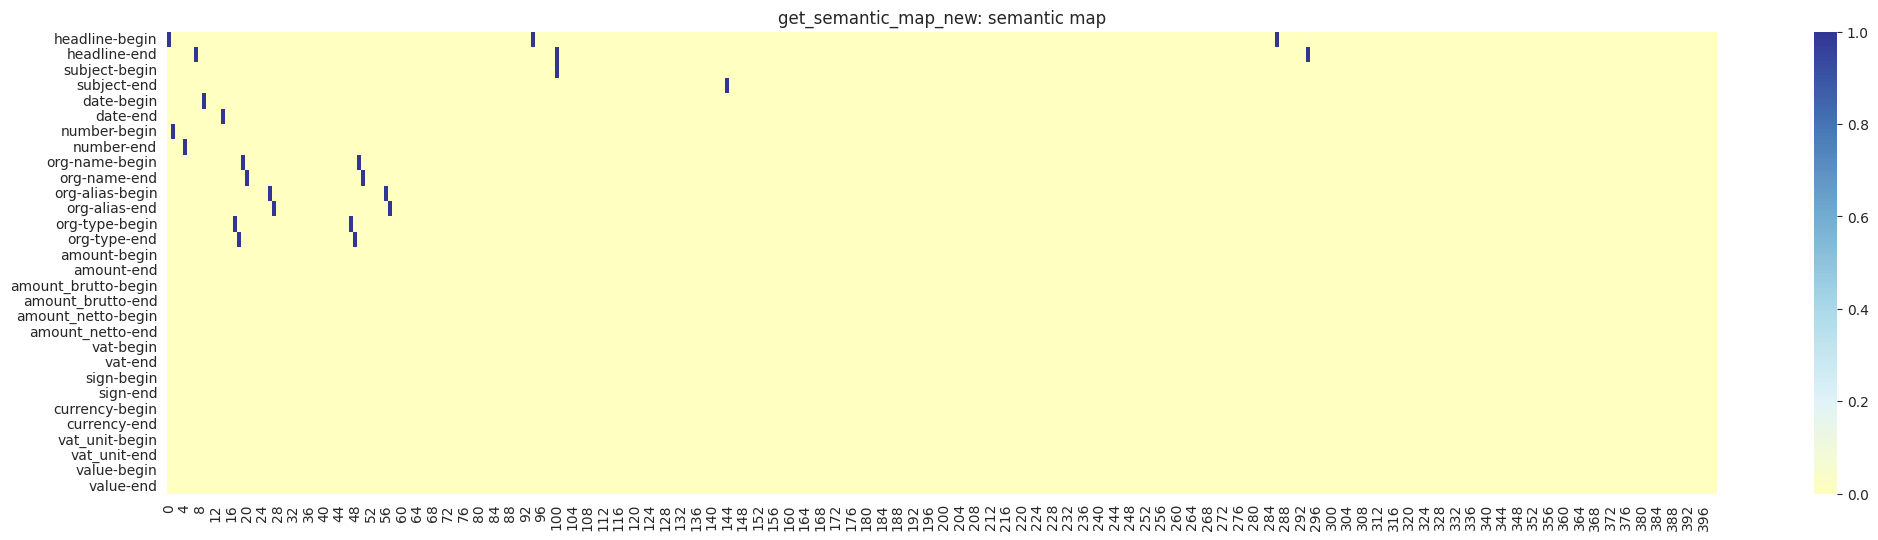

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [138]:
import json
 


semantic_map_keys = [
    'headline',
    'subject', 
    'date', 
    'number',
    'org-name', 
    'org-alias', 
    'org-type'
]

semantic_map_keys += ['amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']

semantic_map_keys_contract = []
for _name in semantic_map_keys:
    semantic_map_keys_contract.append(_name + "-begin")
    semantic_map_keys_contract.append(_name + "-end")

print(semantic_map_keys[8:14])
print(semantic_map_keys[4:7])

def get_semantic_map_new(doc: DbJsonDoc):
    
    _len = len(doc)
    df = DataFrame()
    
    for sl in semantic_map_keys_contract:    
        df[sl] = np.zeros(_len)
    
    attr_tree = doc.get_attributes_tree()
    
    def get_av(name):
        if name in df:
            return df[name]
        else:
            av = np.zeros(_len, np.float)
            df[name] = av
            return av

            
    def add_span_vectors(_name, span):
#         print('add_span_vectors',span)
        bn = _name + "-begin"
        en = _name + "-end"
        b = get_av(bn)
        e = get_av(en)
        if not span is None:
            df[bn][ span[0] ]=1.
            df[en][ span[1] ]=1.
 
        

    # Headers
    headers = doc.analysis['headers']
    for h in headers:
        add_span_vectors('headline', h['span'])
 
 
    for n in semantic_map_keys[1:4]:
        span = attr_tree.get(n, {}).get('span')
        add_span_vectors(n, span)

 
    for i in [1, 2]:
        for n in semantic_map_keys[4:7]:
            try:                
                _nm = n.replace('org-', f'')
                span = attr_tree['orgs'][i-1][_nm]['span']
                add_span_vectors(n, span)
            except Exception as e:
                logger.exception(e)
                print('ERROR (sp)', e, i, n,  _nm)
                if _DEBUG:
                    try:  
                        print(json.dumps( attr_tree['orgs'][i-1], sort_keys=True, indent=4))
                    except:
                        pass
                    print('ERROR', i, n, doc.get_id(), e, attr_tree.get('orgs', None))
 

    _value_tag = attr_tree.get('price', {})
    add_span_vectors("value", _value_tag.get('span'))
 
    if _value_tag is not None:
        amount = get_amount(attr_tree) 
        if amount:
            add_span_vectors('amount', amount.get('span'))
        for n in semantic_map_keys[8:14]:
            add_span_vectors(n, _value_tag.get(n,{}).get('span'))
           
    return df[semantic_map_keys_contract]



if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:400], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
ERROR - 2023-01-26 22:05:59,459 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2838516/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 22:05:59,459 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2838516/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 22:05:59,459 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2838516/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 22:05:59,459 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2838516/3368748694.py", line 71

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a005557ef 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48222b770574a005557ef 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48222b770574a005557ef 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48222b770574a005557ef 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48222b770574a005557ef 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48222b770574a005557ef 'type' [{}, {}]


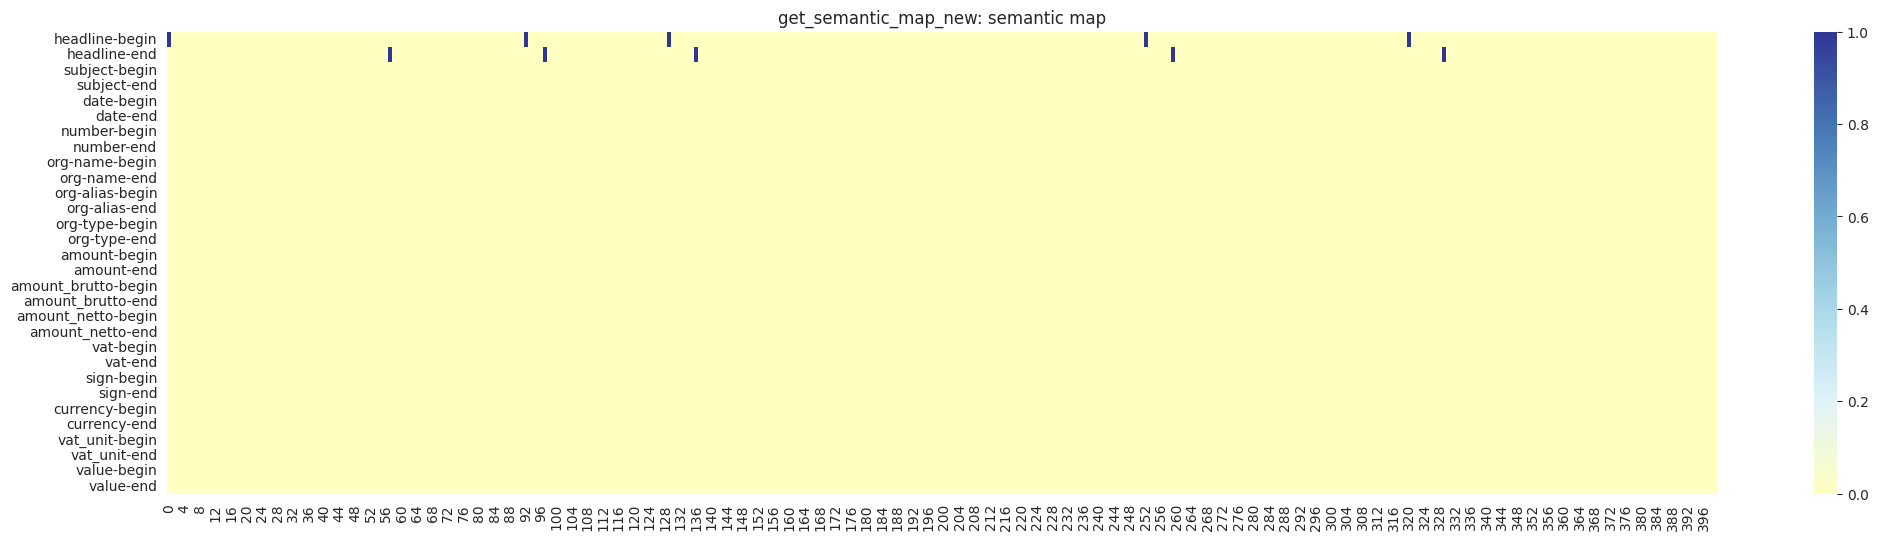

In [139]:
#test one

d = get_doc_by_id(ObjectId('5fe48222b770574a005557ef'))
jd = DbJsonDoc(d)
semantic_map: DataFrame = get_semantic_map_new(jd)
    

plot_embedding(semantic_map[0:400], f'get_semantic_map_new: semantic map')

In [140]:
# fff
files_dict = {}
if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
5fca2aab9083b679224c75ec     db  9a7cc5d577a838a5c9a48795467a8855  23.01.23   
5fc7a031c54bc33809e2617e     db  9a7cc5d577a838a5c9a48795467a8855  23.01.23   
5fdb213a542ce403c92b4506     db  4720ea3c63bcea41b29613f4703024e2  23.01.23   
5fdb213b542ce403c92b450c     db  411f876df894201af5374d1e18ade28e  23.01.23   
5fdb2143542ce403c92b45b0     db  4b4abf13cfde1ee07399bdadc093f996  23.01.23   

                                               export_date     len  \
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5847.0   
5fb376e2d8c9df1ed123726c  2022-12-11 06:49:05.679106+00:00  2794.0   
5fb399dc39d5e82e90818474  2022-12-11 06:49:05.693657+00:00  3742.0   
5fb3b97d00881c332b567292  2022-12-11 06:49:05.700408+00:00  2248.0   
5fb3b97e00881c332b5672bd  2022-12-11 06:49:05.712772+00:00  3546.0   
...                                                    ...     ...   
5fca2aab9083b679224c75ec        2023-01-26 18:13:04.065931  2007.0   
5fc7a031c54bc33809e2617e        2023-01-26 18:13:04.076632  2007.0   
5fdb213a542ce403c92b4506        2023-01-26 18:13:04.081512   122.0   
5fdb213b542ce403c92b450c        2023-01-26 18:13:04.086469     7.0   
5fdb2143542ce403c92b45b0        2023-01-26 18:13:04.101619  3075.0   

                                             analyze_date       value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  25236322.0   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00      2970.0   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00     90000.0   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00         NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  15482412.0   
...                                                   ...         ...   
5fca2aab9083b679224c75ec 2023-01-26 16:51:04.106000+00:00         NaN   
5fc7a031c54bc33809e2617e 2023-01-26 16:54:36.605000+00:00         NaN   
5fdb213a542ce403c92b4506 2023-01-26 17:05:14.465000+00:00         NaN   
5fdb213b542ce403c92b450c 2023-01-26 17:05:14.474000+00:00         NaN   
5fdb2143542ce403c92b45b0 2023-01-26 17:05:14.582000+00:00         NaN   

                          value_log1p  value_span currency  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB   
5fb3b97d00881c332b567292          NaN         NaN      NaN   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB   
...                               ...         ...      ...   
5fca2aab9083b679224c75ec          NaN         NaN      NaN   
5fc7a031c54bc33809e2617e          NaN         NaN      NaN   
5fdb213a542ce403c92b4506          NaN         NaN      NaN   
5fdb213b542ce403c92b450c          NaN         NaN      NaN   
5fdb2143542ce403c92b45b0          NaN         NaN      NaN   

                                                          org-1-name  \
5ec2b8da665f7603e03b1255       Газпромнефть научно-технический центр   
5fb376e2d8c9df1ed123726c  ХанымеГн-киіі неторнко-краевелческий музей   
5fb399dc39d5e82e90818474                      Газпромнефть-Заполярье   
5fb3b97d00881c332b567292                       Газпромнефть-Оренбург   
5fb3b97e00881c332b5672bd                       Газпромнефть-Оренбург   
...                                                              ...   
5fca2aab9083b679224c75ec                                         NaN   
5fc7a031c54bc33809e2617e             

In [141]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [142]:


# if True:
#     lastdate = date.today() + relativedelta(days=-15)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate

Timestamp('2023-01-27 02:26:19.017000+0000', tz='UTC')

In [143]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT","CONTRACT","SUPPLEMENTARY_AGREEMENT",] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего новых документов после 2023-01-27 02:26:19.017000+00:00 : 0

[]

# Prepare training set

In [144]:
# del seq_labels_contract

In [145]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

0


In [146]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [147]:
export_fn

'/root/artem/work/contract_trainset_meta.temp.csv'

In [148]:
for k, oid in enumerate(docs_ids):
    d = get_doc_by_id(oid)
#     print('fetching', oid)
    jd = DbJsonDoc(d)
    
    try:
        add_stats_record(jd, stats)
    except Exception as e:
        print(jd.get_id())
        print (e)
    
    if k % 100 == 0:
        print(f'{k} of {len(docs_ids)}')
        stats.to_csv(export_fn, index=True)
        print(f'stats saved to {export_fn}')
        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

stats saved to /root/artem/work/contract_trainset_meta.temp.csv


source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
5fca2aab9083b679224c75ec     db  9a7cc5d577a838a5c9a48795467a8855  23.01.23   
5fc7a031c54bc33809e2617e     db  9a7cc5d577a838a5c9a48795467a8855  23.01.23   
5fdb213a542ce403c92b4506     db  4720ea3c63bcea41b29613f4703024e2  23.01.23   
5fdb213b542ce403c92b450c     db  411f876df894201af5374d1e18ade28e  23.01.23   
5fdb2143542ce403c92b45b0     db  4b4abf13cfde1ee07399bdadc093f996  23.01.23   

                                               export_date     len  \
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5847.0   
5fb376e2d8c9df1ed123726c  2022-12-11 06:49:05.679106+00:00  2794.0   
5fb399dc39d5e82e90818474  2022-12-11 06:49:05.693657+00:00  3742.0   
5fb3b97d00881c332b567292  2022-12-11 06:49:05.700408+00:00  2248.0   
5fb3b97e00881c332b5672bd  2022-12-11 06:49:05.712772+00:00  3546.0   
...                                                    ...     ...   
5fca2aab9083b679224c75ec        2023-01-26 18:13:04.065931  2007.0   
5fc7a031c54bc33809e2617e        2023-01-26 18:13:04.076632  2007.0   
5fdb213a542ce403c92b4506        2023-01-26 18:13:04.081512   122.0   
5fdb213b542ce403c92b450c        2023-01-26 18:13:04.086469     7.0   
5fdb2143542ce403c92b45b0        2023-01-26 18:13:04.101619  3075.0   

                                             analyze_date       value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  25236322.0   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00      2970.0   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00     90000.0   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00         NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  15482412.0   
...                                                   ...         ...   
5fca2aab9083b679224c75ec 2023-01-26 16:51:04.106000+00:00         NaN   
5fc7a031c54bc33809e2617e 2023-01-26 16:54:36.605000+00:00         NaN   
5fdb213a542ce403c92b4506 2023-01-26 17:05:14.465000+00:00         NaN   
5fdb213b542ce403c92b450c 2023-01-26 17:05:14.474000+00:00         NaN   
5fdb2143542ce403c92b45b0 2023-01-26 17:05:14.582000+00:00         NaN   

                          value_log1p  value_span currency  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB   
5fb3b97d00881c332b567292          NaN         NaN      NaN   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB   
...                               ...         ...      ...   
5fca2aab9083b679224c75ec          NaN         NaN      NaN   
5fc7a031c54bc33809e2617e          NaN         NaN      NaN   
5fdb213a542ce403c92b4506          NaN         NaN      NaN   
5fdb213b542ce403c92b450c          NaN         NaN      NaN   
5fdb2143542ce403c92b45b0          NaN         NaN      NaN   

                                                          org-1-name  \
5ec2b8da665f7603e03b1255       Газпромнефть научно-технический центр   
5fb376e2d8c9df1ed123726c  ХанымеГн-киіі неторнко-краевелческий музей   
5fb399dc39d5e82e90818474                      Газпромнефть-Заполярье   
5fb3b97d00881c332b567292                       Газпромнефть-Оренбург   
5fb3b97e00881c332b5672bd                       Газпромнефть-Оренбург   
...                                                              ...   
5fca2aab9083b679224c75ec                                         NaN   
5fc7a031c54bc33809e2617e             

In [149]:
stats = stats[stats.valid!=False]
len(stats)

14000

In [150]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
63d24b69c25950de8f832c9f     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b69c25950de8f832c9e     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   
63d24b9d3554f2343d832c9b     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b9d3554f2343d832c9a     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   
63d24bf33554f2343d832c9d     db  b749fc61fbde1a224579121dc12f5035  23.01.23   

                                               export_date     len  \
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5847.0   
5fb376e2d8c9df1ed123726c  2022-12-11 06:49:05.679106+00:00  2794.0   
5fb399dc39d5e82e90818474  2022-12-11 06:49:05.693657+00:00  3742.0   
5fb3b97d00881c332b567292  2022-12-11 06:49:05.700408+00:00  2248.0   
5fb3b97e00881c332b5672bd  2022-12-11 06:49:05.712772+00:00  3546.0   
...                                                    ...     ...   
63d24b69c25950de8f832c9f        2023-01-26 18:13:03.589102   123.0   
63d24b69c25950de8f832c9e        2023-01-26 18:13:03.599658  2021.0   
63d24b9d3554f2343d832c9b        2023-01-26 18:13:03.604925   123.0   
63d24b9d3554f2343d832c9a        2023-01-26 18:13:03.615247  2021.0   
63d24bf33554f2343d832c9d        2023-01-26 18:13:03.622135  1014.0   

                                             analyze_date         value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00  2.970000e+03   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00  9.000000e+04   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00           NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  1.548241e+07   
...                                                   ...           ...   
63d24b69c25950de8f832c9f 2023-01-26 12:52:09.766000+00:00           NaN   
63d24b69c25950de8f832c9e 2023-01-26 12:53:05.865000+00:00  1.500000e+10   
63d24b9d3554f2343d832c9b 2023-01-26 12:53:08.673000+00:00           NaN   
63d24b9d3554f2343d832c9a 2023-01-26 12:53:12.433000+00:00  1.500000e+10   
63d24bf33554f2343d832c9d 2023-01-26 12:53:48.265000+00:00  3.000000e+10   

                          value_log1p  value_span currency  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB   
5fb3b97d00881c332b567292          NaN         NaN      NaN   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB   
...                               ...         ...      ...   
63d24b69c25950de8f832c9f          NaN         NaN      NaN   
63d24b69c25950de8f832c9e    23.431316       201.0      RUB   
63d24b9d3554f2343d832c9b          NaN         NaN      NaN   
63d24b9d3554f2343d832c9a    23.431316       201.0      RUB   
63d24bf33554f2343d832c9d    24.124463       158.0      RUB   

                                                          org-1-name  \
5ec2b8da665f7603e03b1255       газпромнефть научно-технический центр   
5fb376e2d8c9df1ed123726c  ханымегн-киіі неторнко-краевелческий музей   
5fb399dc39d5e82e90818474                      газпромнефть-заполярье   
5fb3b97d00881c332b567292                       газпромнефть-оренбург   
5fb3b97e00881c332b5672bd                       газпромнефть-оренбург   
...                                                              ...   
63d24b69c25950de8f832c9f                                         NaN   
63d24b69c2595

In [151]:
stats2['subject'].value_counts()

Other                                6552
Service                              2654
Deal                                  719
GeneralContract                       245
Renting                               218
Loans                                 203
Insurance                             128
AgencyContract                        116
DealIntellectualProperty              108
Charity                                84
RealEstate                             47
RealEstateTransactions                 27
ParticipationInOtherOrganizations      22
PledgeEncumbrance                      21
BankGuarantees                         21
SecuritiesTransactions                  8
AssetTransactions                       7
BigDeal                                 5
EmployeeContracts                       3
DealGeneralBusiness                     2
Name: subject, dtype: int64

In [152]:
stats2['org-1-alias'].value_counts()

заказчик         2530
исполнитель      1041
покупатель        713
поставщик         373
арендодатель      253
                 ... 
даритель            1
издатель            1
подрядчик» («       1
мтс                 1
лютик               1
Name: org-1-alias, Length: 148, dtype: int64

In [153]:
stats2['org-2-alias'].value_counts()

исполнитель              1832
заказчик                 1142
поставщик                 658
подрядчик                 581
покупатель                466
                         ... 
конечный пользователь       1
заемщик»                    1
оператор» либо «            1
сетевой                     1
ромашка                     1
Name: org-2-alias, Length: 138, dtype: int64

In [154]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

14000


source                          checksum   version  \
63453826172785f510f15e11     db  09574ba376188031d5b1efb10c7064b9     3.0.0   
6346a561172785f510f15e2a     db  1439eb4d76211bd57182395091226d86     3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6     3.0.0   
62d149474ae369b4976e31fc     db  143c98f4735bd58c5eeb4742ca8275b7     3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
633ea99b9d08c565cfa1231e     db  e88212da6eb7e31a30a6fea422bc58dc     3.0.0   
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
62d149484ae369b4976e3203     db  c7fa85ee2db44cc392342a492148b2d3     3.0.0   
634022659d08c565cfa1233f     db  50bb404584fcd58fdb01e279d3a55431     3.0.0   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a    1.11.2   
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d     3.0.0   
634698fc172785f510f15e27     db  bc7d70a32aed6af4ef6c7752a1b7674d     3.0.0   
633eca889d08c565cfa12324     db  1439eb4d76211bd57182395091226d86  23.01.23   
633c360f9d08c565cfa12311     db  e88212da6eb7e31a30a6fea422bc58dc     3.0.0   
633c28629d08c565cfa1230a     db  e88212da6eb7e31a30a6fea422bc58dc     3.0.0   
6246a3fa25a983726c7694af     db  61cfee32867b371843d1e95a194ea2a6     3.0.0   
633fd0a69d08c565cfa1232a     db  61cfee32867b371843d1e95a194ea2a6     3.0.0   
634515c4172785f510f15e05     db  1e0b396c361ad164ee654ffb57a3b508     3.0.0   
63908ca4a1bded13e629f2eb     db  3bc04887446d02692e886db2545bba61   22.12.7   
5fbbbd1ca2b4551c06107a5f     db  4c6124d0661a45e03c7dec4eba94bb0a     2.0.5   
5fbbe46ca2b4551c06107c21     db  c116f846e9ee6ececa07e15ae213552e     2.0.5   
5fb6750a33c72547b755010d     db  4c6124d0661a45e03c7dec4eba94bb0a     2.0.5   
636dfd1473925c8dae26f910     db  04a3e9defa47d894d07550ae99cf95d1     3.0.0   
636d031e73925c8dae26f90e     db  4abd6c70b4e58225b824357d6bf780a1     3.0.0   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e     2.0.2   
5ec2b8da665f7603e03b127e     db  71d364cbfd07a7a940a8d7de159e1229     1.6.5   
5e587dce99b345c81a70340d   file  c7638957131b716a710dcb357e4dc198    1.12.0   
5fe34f63b770574a005553db     db  b42ed28b9a72f51612db24cbd7b7a4f0    2.3.13   
60002adfb08473039387bcc5     db  57cce4467ee80797fbe4b8e5d69c8742   22.12.7   
5deba9034ddc27bcf92dd383   file  7e9e0a5f729f876a5b3055de5076db9d    1.10.0   
5ec2b8d9665f7603e03b1238     db  7e9e0a5f729f876a5b3055de5076db9d     1.6.5   
63c92b5cfb21317f1d5e0f7c     db  57cce4467ee80797fbe4b8e5d69c8742  23.01.04   
5fb399dd39d5e82e9081847d     db  5538125725572fda3b474800b12766f5     2.0.5   
635fa420bf4cb23cbb39282d     db  af0f27d99859108243db6d7fa3e3ae9c     3.0.0   
5e58df7823869ee435388239   file  bdccb8e9a4bccb217b504a67f12661f1    1.11.2   
5e5de70c01c6c73c19eebd38   file  bdccb8e9a4bccb217b504a67f12661f1    1.12.0   
63908ca3a1bded13e629f2de     db  03455452b993eb289683fa17c0b997fd   22.12.6   
5fbf75af5d05d73d0295fa99     db  9f0be084f7a24f3b408dd5baf95195c3     2.0.5   
635fa420bf4cb23cbb39282f     db  cae67be3fb8b4cf81a623922a8837c36     3.0.0   
6340086b9d08c565cfa12337     db  09574ba376188031d5b1efb10c7064b9     3.0.0   

                                               export_date      len  \
63453826172785f510f15e11  2022-12-10 06:23:47.615316+00:00  11375.0   
6346a561172785f510f15e2a  2022-12-10 06:23:47.793876+00:00   6920.0   
6285f9c04d1bfe5e5b297ddd  2022-12-10 06:20:32.397698+00:00   5556.0   
62d149474ae369b4976e31fc  2022-12-10 06:20:46.190889+00:00  31117.0   
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00   5847.0   
633ea99b9d08c565cfa1231e  2022-12-10 06:23:46.837617+00:00   6731.0   
6391b4771864c6df4d29f332  2022-12-11 06:49:28.432113+00:00   1990.0   
62d149484ae369b4976e3203  2022-12-10 06:20:46.250728+00:00   5351.0   
634022659d08c565cfa1233f  2022-12-10 06:23:47.129310+00:00    413.0   
5ded4e284ddc27bcf92dd6ce        2023-01-26 22:06:03.194998    460.0   
6340

In [155]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [156]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

source                          checksum   version  \
5fb39a0339d5e82e908184c7     db  5e434ac9b159e26022a68268778433a1    2.3.14   
5fb3b9b900881c332b5674ad     db  75bd2ed3c3d37d2b4759582970777148     2.4.4   
63ce4a83e83d1ee490f3fa00     db  7b5058426fb77030b47f8fe654103fa6  23.01.23   
5fb39a0339d5e82e908184c6     db  b3f13520a7cd4f96a73dcc28501449c5    2.3.14   
63ce4ae2e83d1ee490f3fe2c     db  42bbd6d60b5a2e17ae879191b09a12f6  23.01.23   
...                         ...                               ...       ...   
638085606a07f3e980b2c0b8     db  e26828f5b36248c96edca855d954acff     3.0.0   
63c506bde2456d59975e110f     db  e26828f5b36248c96edca855d954acff  23.01.04   
638f0a7fb1363747e929f2ed     db  e26828f5b36248c96edca855d954acff   22.12.6   
638085886a07f3e980b2c47a     db  bc8149015cac8e01db36e3b69a7b02b9     3.0.0   
638085896a07f3e980b2c486     db  b4689b39528772c1acae0fe4e454d5e7     3.0.0   

                                               export_date       len  \
5fb39a0339d5e82e908184c7  2022-12-10 06:19:34.937153+00:00  149800.0   
5fb3b9b900881c332b5674ad  2022-12-10 06:20:07.993460+00:00  142690.0   
63ce4a83e83d1ee490f3fa00  2023-01-25 19:06:03.981533+00:00  107860.0   
5fb39a0339d5e82e908184c6  2022-12-10 06:19:23.849474+00:00   79810.0   
63ce4ae2e83d1ee490f3fe2c        2023-01-26 18:12:35.753616   76040.0   
...                                                    ...       ...   
638085606a07f3e980b2c0b8  2022-12-10 06:24:02.726924+00:00       0.0   
63c506bde2456d59975e110f  2023-01-25 19:04:15.990731+00:00       0.0   
638f0a7fb1363747e929f2ed  2022-12-11 06:49:16.887197+00:00       0.0   
638085886a07f3e980b2c47a  2022-12-10 06:24:09.435915+00:00       0.0   
638085896a07f3e980b2c486  2022-12-10 06:24:09.622384+00:00       0.0   

                                             analyze_date  value  value_log1p  \
5fb39a0339d5e82e908184c7 2021-04-21 16:57:23.425000+00:00    NaN          NaN   
5fb3b9b900881c332b5674ad 2021-07-30 17:07:52.929000+00:00    NaN          NaN   
63ce4a83e83d1ee490f3fa00 2023-01-23 22:31:51.935000+00:00    NaN          NaN   
5fb39a0339d5e82e908184c6 2021-04-21 16:57:00.950000+00:00    NaN          NaN   
63ce4ae2e83d1ee490f3fe2c 2023-01-25 18:47:43.976000+00:00    NaN          NaN   
...                                                   ...    ...          ...   
638085606a07f3e980b2c0b8 2022-11-25 13:27:23.077000+00:00    NaN          NaN   
63c506bde2456d59975e110f 2023-01-16 11:36:52.451000+00:00    NaN          NaN   
638f0a7fb1363747e929f2ed 2022-12-06 12:27:52.469000+00:00    NaN          NaN   
638085886a07f3e980b2c47a 2022-11-25 15:43:12.269000+00:00    NaN          NaN   
638085896a07f3e980b2c486 2022-11-25 15:46:57.410000+00:00    NaN          NaN   

                          value_span currency  ...  \
5fb39a0339d5e82e908184c7         NaN      NaN  ...   
5fb3b9b900881c332b5674ad         NaN      NaN  ...   
63ce4a83e83d1ee490f3fa00         NaN      NaN  ...   
5fb39a0339d5e82e908184c6         NaN      NaN  ...   
63ce4ae2e83d1ee490f3fe2c         NaN      NaN  ...   
...                              ...      ...  ...   
638085606a07f3e980b2c0b8         NaN      NaN  ...   
63c506bde2456d59975e110f         NaN      NaN  ...   
638f0a7fb1363747e929f2ed         NaN      NaN  ...   
638085886a07f3e980b2c47a         NaN      NaN  ...   
638085896a07f3e980b2c486         NaN      NaN  ...   

                                                               org-2-name  \
5fb39a0339d5e82e908184c7                                              NaN   
5fb3b9b900881c332b5674ad  информационнотехнологическая сервисная компания   
63ce4a83e83d1ee490f3fa00                                              NaN   
5fb39a0339d5e82e908184c6                                              NaN   
63ce4ae2e83d1ee490f3fe2c                                              NaN   
...                                                                   ...   
638085606a07f3e980b2c0b8                          

In [157]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

14000


source                          checksum   version  \
5fb3b9b000881c332b56747d     db  aa2b2af6f487551ee96e41a2f6da6f1b     2.4.4   
63ce4a7ce83d1ee490f3f9d5     db  624d3e8e2d75318f63e29edb154a6e80  23.01.23   
5fb3b97c00881c332b567284     db  1d978b375bb322ace316edbf4545cbe1     2.0.5   
5fb3b97c00881c332b56727f     db  1d978b375bb322ace316edbf4545cbe1     2.0.5   
5fbbe467a2b4551c06107b06     db  e2a337e8312b91c03b48930fa2f8ba8c     2.0.5   
...                         ...                               ...       ...   
60ebe82ecddbb3c487368c26     db  d3840a41080eff183b1f1358bf5fdafb     2.4.4   
638085a76a07f3e980b2c686     db  6fca3d20c5fd045f026edc4610f33968     3.0.0   
63ce4b04e83d1ee490f4003b     db  e19c62812709a43fb5254d449fffd375  23.01.23   
5fe48219b770574a005555e0     db  95fab4987614d1a43eb03412d449bf97    2.3.13   
5efe9210777d4b67a92d5468   file  87d3fe627cad8a42438dbe709489e2ad     2.0.0   

                                               export_date     len  \
5fb3b9b000881c332b56747d  2022-12-10 06:19:53.054183+00:00  1720.0   
63ce4a7ce83d1ee490f3f9d5  2023-01-25 19:05:57.266522+00:00   320.0   
5fb3b97c00881c332b567284  2022-12-10 06:13:49.627197+00:00  1770.0   
5fb3b97c00881c332b56727f  2022-12-10 06:13:49.617871+00:00  1770.0   
5fbbe467a2b4551c06107b06  2022-12-10 06:14:15.071075+00:00  4560.0   
...                                                    ...     ...   
60ebe82ecddbb3c487368c26  2022-12-10 06:19:37.423498+00:00  1260.0   
638085a76a07f3e980b2c686  2022-12-11 06:49:13.249853+00:00  2760.0   
63ce4b04e83d1ee490f4003b        2023-01-26 18:12:54.631936  7210.0   
5fe48219b770574a005555e0  2022-12-10 06:15:43.202861+00:00   260.0   
5efe9210777d4b67a92d5468        2023-01-26 22:06:18.179892  2910.0   

                                             analyze_date     value  \
5fb3b9b000881c332b56747d 2021-07-30 15:53:55.187000+00:00       NaN   
63ce4a7ce83d1ee490f3f9d5 2023-01-23 22:05:59.350000+00:00   57103.9   
5fb3b97c00881c332b567284 2020-11-17 11:54:34.488000+00:00       NaN   
5fb3b97c00881c332b56727f 2020-11-17 11:54:33.977000+00:00       NaN   
5fbbe467a2b4551c06107b06 2020-11-23 18:02:52.673000+00:00  478300.0   
...                                                   ...       ...   
60ebe82ecddbb3c487368c26 2021-07-12 09:59:02.812000+00:00  180000.0   
638085a76a07f3e980b2c686 2022-11-25 12:34:14.427000+00:00       NaN   
63ce4b04e83d1ee490f4003b 2023-01-26 05:11:33.647000+00:00       NaN   
5fe48219b770574a005555e0 2020-12-24 15:05:52.965000+00:00       NaN   
5efe9210777d4b67a92d5468 2020-07-03 21:58:49.673000+00:00  500000.0   

                          value_log1p  value_span currency  ...  org-2-alias  \
5fb3b9b000881c332b56747d          NaN         NaN      NaN  ...          NaN   
63ce4a7ce83d1ee490f3f9d5    10.952645        84.0      NaN  ...          NaN   
5fb3b97c00881c332b567284          NaN         NaN      NaN  ...          NaN   
5fb3b97c00881c332b56727f          NaN         NaN      NaN  ...          NaN   
5fbbe467a2b4551c06107b06    13.077996      1030.0      RUB  ...   страховщик   
...                               ...         ...      ...  ...          ...   
60ebe82ecddbb3c487368c26    12.100718       483.0      RUB  ...          NaN   
638085a76a07f3e980b2c686          NaN         NaN      NaN  ...  исполнитель   
63ce4b04e83d1ee490f4003b          NaN         NaN      NaN  ...          NaN   
5fe48219b770574a005555e0          NaN         NaN      NaN  ...          NaN   
5efe9210777d4b67a92d5468    13.122365       401.0      RUB  ...     заказчик   

                                           subject subject confidence  \
5fb3b9b000881c332b56747d                       NaN                NaN   
63ce4a7ce83d1ee490f3f9d5                     Other           0.961220   
5fb3b97c00881c332b567284                       NaN                NaN   
5fb3b97c00881c332b56727f                       NaN                NaN   
5fbbe467a2b4551c06107b06                   BigDeal      

In [158]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

14000

### Drop duplicates

In [159]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

6443


## Remove rare subjects and very long docs

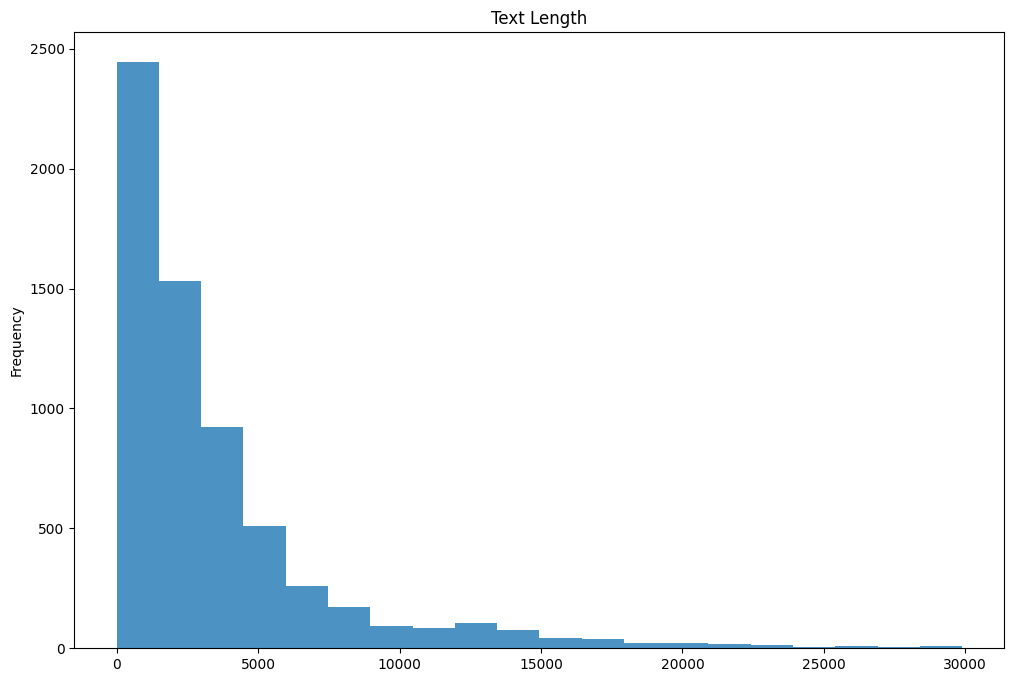

In [160]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.2041667524161293


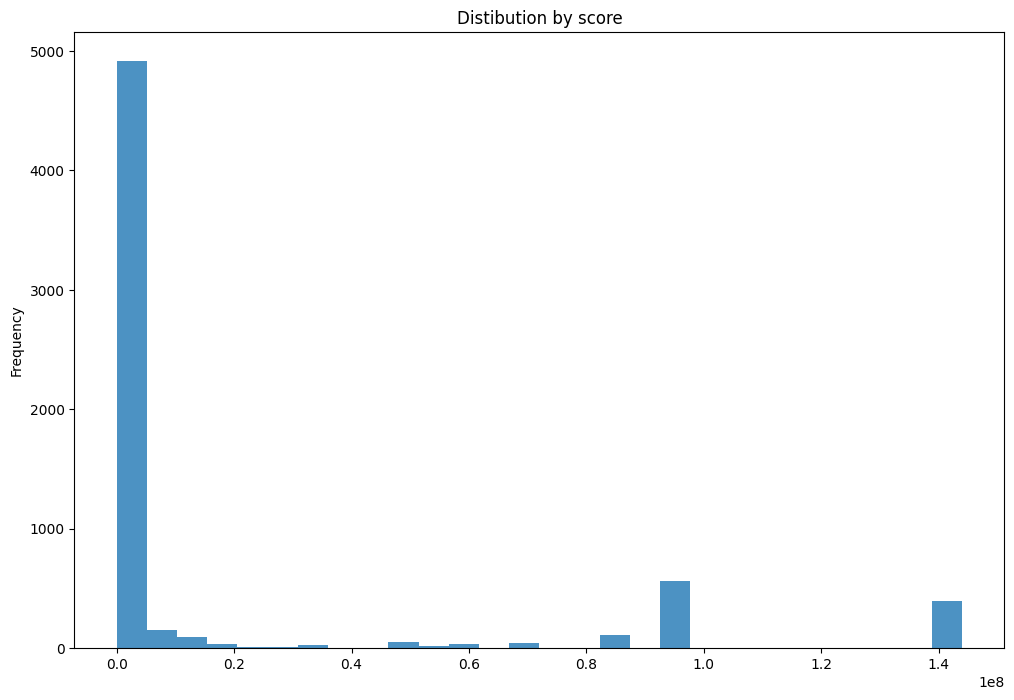

In [161]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [162]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 4:
            print ('excluding', row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding db GeneralContract 31110.0
excluding file GeneralContract 31090.0
excluding db GeneralContract 38360.0
excluding db GeneralContract 49040.0
excluding db GeneralContract 41250.0
excluding db GeneralContract 39310.0
excluding db GeneralContract 39000.0
excluding db GeneralContract 43930.0
excluding db GeneralContract 31170.0
excluding db Service 32720.0
excluding db Service 35710.0
excluding file GeneralContract 31090.0
excluding db Service 49340.0
excluding db Service 30250.0
excluding db nan 31090.0
excluding file Service 39860.0
excluding db Service 142690.0
excluding db Loans 35800.0
excluding db Other 31080.0
excluding db Service 35880.0
excluding db Other 39750.0
excluding db DealIntellectualProperty 35560.0
excluding db Other 36550.0
excluding db Other 45990.0
excluding db Other 65650.0
excluding db Other 58500.0
excluding db Other 107860.0
excluding db Other 76040.0
excluding db Other 31320.0
excluding db Other 30700.0
excluding db Other 46050.0


Other                                1948
Service                              1874
Deal                                  516
GeneralContract                       177
Renting                               157
Loans                                 126
Insurance                              88
AgencyContract                         87
DealIntellectualProperty               78
Charity                                57
RealEstate                             39
RealEstateTransactions                 21
BankGuarantees                         19
ParticipationInOtherOrganizations      14
PledgeEncumbrance                      13
SecuritiesTransactions                  7
AssetTransactions                       6
Name: subject, dtype: int64


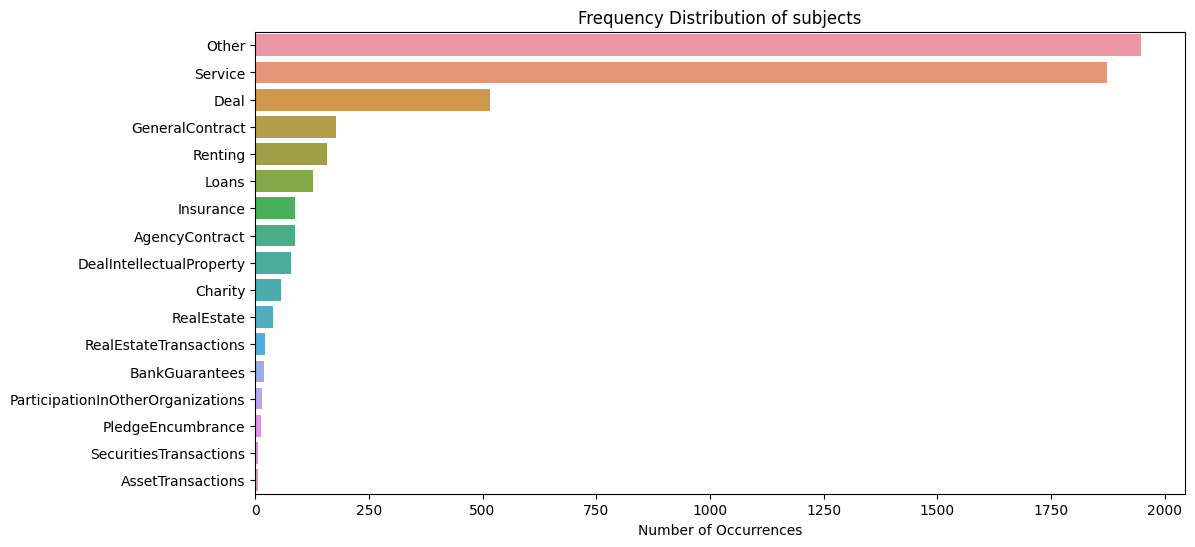

In [163]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [164]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 6386 - Всего новых документов в обучающем наборе на 2023-01-27 02:26:19.017000+00:00

source                          checksum version  \
_id                                                                         
63453826172785f510f15e11     db  09574ba376188031d5b1efb10c7064b9   3.0.0   
6346a561172785f510f15e2a     db  1439eb4d76211bd57182395091226d86   3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6   3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1   1.6.5   
633ea99b9d08c565cfa1231e     db  e88212da6eb7e31a30a6fea422bc58dc   3.0.0   
...                         ...                               ...     ...   
5fb674f933c72547b754ff86     db  004835d1f74696732975e2637c2eead5   2.4.4   
5fb376e4d8c9df1ed12372a9     db  9a5ebb7fc6ce2d08e8aa637ea0e6352a   2.5.3   
5fb3b97d00881c332b56728e     db  72fbdfd3e5501eef7a8debca525785ba   2.0.5   
5fb3b9a700881c332b567415     db  d2948bf88829c10b27978f22b9d331de   2.4.4   
5fb3b9b000881c332b56747d     db  aa2b2af6f487551ee96e41a2f6da6f1b   2.4.4   

                                               export_date      len  \
_id                                                                   
63453826172785f510f15e11  2022-12-10 06:23:47.615316+00:00  11370.0   
6346a561172785f510f15e2a  2022-12-10 06:23:47.793876+00:00   6920.0   
6285f9c04d1bfe5e5b297ddd  2022-12-10 06:20:32.397698+00:00   5550.0   
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00   5840.0   
633ea99b9d08c565cfa1231e  2022-12-10 06:23:46.837617+00:00   6730.0   
...                                                    ...      ...   
5fb674f933c72547b754ff86  2022-12-10 06:19:40.677707+00:00    200.0   
5fb376e4d8c9df1ed12372a9  2022-12-10 06:20:18.955163+00:00    130.0   
5fb3b97d00881c332b56728e  2022-12-10 06:13:49.671681+00:00   1690.0   
5fb3b9a700881c332b567415  2022-12-10 06:19:49.608862+00:00   5100.0   
5fb3b9b000881c332b56747d  2022-12-10 06:19:53.054183+00:00   1720.0   

                                             analyze_date         value  \
_id                                                                       
63453826172785f510f15e11 2022-10-11 12:32:58.467000+00:00  3.000000e+09   
6346a561172785f510f15e2a 2022-10-12 14:31:24.479000+00:00  1.000000e+09   
6285f9c04d1bfe5e5b297ddd 2022-05-19 11:03:36.611000+00:00  1.000000e+11   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
633ea99b9d08c565cfa1231e 2022-10-06 13:10:52.969000+00:00  5.000000e+10   
...                                                   ...           ...   
5fb674f933c72547b754ff86 2021-07-28 18:10:09.162000+00:00           NaN   
5fb376e4d8c9df1ed12372a9 2021-10-28 15:44:20.122000+00:00           NaN   
5fb3b97d00881c332b56728e 2020-11-17 11:54:35.530000+00:00           NaN   
5fb3b9a700881c332b567415 2021-07-30 15:44:04.678000+00:00           NaN   
5fb3b9b000881c332b56747d 2021-07-30 15:53:55.187000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
63453826172785f510f15e11    21.821878      2286.0      RUB  ...   
6346a561172785f510f15e2a    20.723266      1922.0      RUB  ...   
6285f9c04d1bfe5e5b297ddd    25.328436      1505.0      NaN  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
633ea99b9d08c565cfa1231e    24.635289       401.0      RUB  ...   
...                               ...         ...      ...  ...   
5fb674f933c72547b754ff86          NaN         NaN      NaN  ...   
5fb376e4d8c9df1ed12372a9          NaN         NaN      NaN  ...   
5fb3b97d00881c332b56728e          NaN         NaN      NaN  ...   
5fb3b9a700881c332b567415          NaN         NaN      NaN  ...   
5fb3b9b000881c332b56747d          NaN         NaN      NaN  ...   

                                         subject subject confidence  \
_id                                                                   
63453826172785f510f15e11          BankGuarantees                1.0   
6346a561172785f510f15e2a              

In [165]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [166]:
dups_s[dups_s['unseen']]

source                          checksum   version  \
_id                                                                           
5ec2b8d8665f7603e03b121a     db  74a7be7f14b129ce379aaa0920978a71     1.6.5   
638085946a07f3e980b2c52f     db  99eb2f07e9493a1e712529bc30359204     3.0.0   
63c506dce2456d59975e145c     db  88a0bf0e851b84960702680c7972f090  23.01.04   
6380858c6a07f3e980b2c4d4     db  6c3d58c52abbe2e020a912ec055b5b8b     3.0.0   
63ce4a67e83d1ee490f3f86c     db  e32d37eec5b91d8948c81e8794b87c9c  23.01.23   
...                         ...                               ...       ...   
5fb674f933c72547b754ff86     db  004835d1f74696732975e2637c2eead5     2.4.4   
5fb376e4d8c9df1ed12372a9     db  9a5ebb7fc6ce2d08e8aa637ea0e6352a     2.5.3   
5fb3b97d00881c332b56728e     db  72fbdfd3e5501eef7a8debca525785ba     2.0.5   
5fb3b9a700881c332b567415     db  d2948bf88829c10b27978f22b9d331de     2.4.4   
5fb3b9b000881c332b56747d     db  aa2b2af6f487551ee96e41a2f6da6f1b     2.4.4   

                                               export_date      len  \
_id                                                                   
5ec2b8d8665f7603e03b121a  2022-12-10 06:13:26.713676+00:00    550.0   
638085946a07f3e980b2c52f  2022-12-10 06:24:29.989854+00:00  10780.0   
63c506dce2456d59975e145c  2023-01-25 19:04:42.725762+00:00   3630.0   
6380858c6a07f3e980b2c4d4  2022-12-10 06:24:28.661100+00:00  12720.0   
63ce4a67e83d1ee490f3f86c  2023-01-25 19:05:52.660581+00:00   1270.0   
...                                                    ...      ...   
5fb674f933c72547b754ff86  2022-12-10 06:19:40.677707+00:00    200.0   
5fb376e4d8c9df1ed12372a9  2022-12-10 06:20:18.955163+00:00    130.0   
5fb3b97d00881c332b56728e  2022-12-10 06:13:49.671681+00:00   1690.0   
5fb3b9a700881c332b567415  2022-12-10 06:19:49.608862+00:00   5100.0   
5fb3b9b000881c332b56747d  2022-12-10 06:19:53.054183+00:00   1720.0   

                                             analyze_date         value  \
_id                                                                       
5ec2b8d8665f7603e03b121a 2020-05-18 16:35:16.047000+00:00  4.900000e+05   
638085946a07f3e980b2c52f 2022-11-25 19:47:29.189000+00:00  6.000000e+06   
63c506dce2456d59975e145c 2023-01-16 14:15:20.502000+00:00  4.000000e+06   
6380858c6a07f3e980b2c4d4 2022-11-25 19:28:07.196000+00:00  9.661022e+09   
63ce4a67e83d1ee490f3f86c 2023-01-23 20:07:02.512000+00:00  1.000000e+05   
...                                                   ...           ...   
5fb674f933c72547b754ff86 2021-07-28 18:10:09.162000+00:00           NaN   
5fb376e4d8c9df1ed12372a9 2021-10-28 15:44:20.122000+00:00           NaN   
5fb3b97d00881c332b56728e 2020-11-17 11:54:35.530000+00:00           NaN   
5fb3b9a700881c332b567415 2021-07-30 15:44:04.678000+00:00           NaN   
5fb3b9b000881c332b56747d 2021-07-30 15:53:55.187000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
5ec2b8d8665f7603e03b121a    13.102163       114.0      RUB  ...   
638085946a07f3e980b2c52f    15.607270      4608.0      RUB  ...   
63c506dce2456d59975e145c    15.201805       326.0      RUB  ...   
6380858c6a07f3e980b2c4d4    22.991365      5605.0      RUB  ...   
63ce4a67e83d1ee490f3f86c    11.512935       980.0      NaN  ...   
...                               ...         ...      ...  ...   
5fb674f933c72547b754ff86          NaN         NaN      NaN  ...   
5fb376e4d8c9df1ed12372a9          NaN         NaN      NaN  ...   
5fb3b97d00881c332b56728e          NaN         NaN      NaN  ...   
5fb3b9a700881c332b567415          NaN         NaN      NaN  ...   
5fb3b9b000881c332b56747d          NaN         NaN      NaN  ...   

                                    subject subject confidence  \
_id                                                              
5ec2b8d8665f7603e03b121a            Charity           0.744503   
638085946a07f3e980b2c52f   

# Make datapoints

In [167]:
work_dir

PosixPath('/root/artem/work')

In [168]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [169]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set

0

### Exclude docs with long subjects

In [177]:
ids = list(dups_s.index)


ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[oid, 'documentType'] = jd.documentType
            dups_s.at[oid, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            if span[0]==0:
                stats.at[oid, 'valid'] = False
                dups_s.at[oid, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[oid, 'valid'] = False
                dups_s.at[oid, 'valid'] = False
                
                stats.at[oid, 'subj_len'] = subject_len
                dups_s.at[oid, 'subj_len'] = subject_len
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


0 63453826172785f510f15e11 [137, 555] 418
Статья 1. Предмет Договора

45 5fca2ab09083b679224c7638 [181, 556] 375
2.1. Настоящий Договор является рамочным договором
68 6343fdcc172785f510f15df5 [65, 265] 200
1. ПРЕДМЕТ ДОГОВОРА.

156 63908ca4a1bded13e629f2ea [18, 296] 278
1. Публичное акционерное общество «Газпром нефть»,
250 5fe48218b770574a005555db [112, 333] 221
1.1. Арендодатель обязуется предоставить во времен
295 62d149474ae369b4976e31f6 [106, 398] 292
1. ПРЕДМЕТ ДОГОВОРА.

302 62d149484ae369b4976e31ff [904, 1156] 252
СТАТЬЯ 3. ПРЕДМЕТ ДОГОВОРА.

543 628793eb4d1bfe5e5b297dff [123, 335] 212
2.1. Заказчик поручает, а Исполнитель обязуется, н
717 63ac1fab862ea92bf713c51e [180, 380] 200
1.1. По настоящему договору Правообладатель обязуе
721 63c506e3e2456d59975e1529 [160, 360] 200
2.1. Предметом настоящего Договора является предос
729 63c506b9e2456d59975e10af [141, 341] 200
1.1. ГАРАНТ принимает на себя обязательство предос
794 63ce49f0e83d1ee490f3f179 [187, 387] 200
1.1. Лицензиат в со

In [49]:
len(ids_of_long_subject_docs)

140

In [178]:
dups_s

source                          checksum version  \
_id                                                                         
63453826172785f510f15e11     db  09574ba376188031d5b1efb10c7064b9   3.0.0   
6346a561172785f510f15e2a     db  1439eb4d76211bd57182395091226d86   3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6   3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1   1.6.5   
633ea99b9d08c565cfa1231e     db  e88212da6eb7e31a30a6fea422bc58dc   3.0.0   
...                         ...                               ...     ...   
5fb674f933c72547b754ff86     db  004835d1f74696732975e2637c2eead5   2.4.4   
5fb376e4d8c9df1ed12372a9     db  9a5ebb7fc6ce2d08e8aa637ea0e6352a   2.5.3   
5fb3b97d00881c332b56728e     db  72fbdfd3e5501eef7a8debca525785ba   2.0.5   
5fb3b9a700881c332b567415     db  d2948bf88829c10b27978f22b9d331de   2.4.4   
5fb3b9b000881c332b56747d     db  aa2b2af6f487551ee96e41a2f6da6f1b   2.4.4   

                                               export_date      len  \
_id                                                                   
63453826172785f510f15e11  2022-12-10 06:23:47.615316+00:00  11370.0   
6346a561172785f510f15e2a  2022-12-10 06:23:47.793876+00:00   6920.0   
6285f9c04d1bfe5e5b297ddd  2022-12-10 06:20:32.397698+00:00   5550.0   
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00   5840.0   
633ea99b9d08c565cfa1231e  2022-12-10 06:23:46.837617+00:00   6730.0   
...                                                    ...      ...   
5fb674f933c72547b754ff86  2022-12-10 06:19:40.677707+00:00    200.0   
5fb376e4d8c9df1ed12372a9  2022-12-10 06:20:18.955163+00:00    130.0   
5fb3b97d00881c332b56728e  2022-12-10 06:13:49.671681+00:00   1690.0   
5fb3b9a700881c332b567415  2022-12-10 06:19:49.608862+00:00   5100.0   
5fb3b9b000881c332b56747d  2022-12-10 06:19:53.054183+00:00   1720.0   

                                             analyze_date         value  \
_id                                                                       
63453826172785f510f15e11 2022-10-11 12:32:58.467000+00:00  3.000000e+09   
6346a561172785f510f15e2a 2022-10-12 14:31:24.479000+00:00  1.000000e+09   
6285f9c04d1bfe5e5b297ddd 2022-05-19 11:03:36.611000+00:00  1.000000e+11   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
633ea99b9d08c565cfa1231e 2022-10-06 13:10:52.969000+00:00  5.000000e+10   
...                                                   ...           ...   
5fb674f933c72547b754ff86 2021-07-28 18:10:09.162000+00:00           NaN   
5fb376e4d8c9df1ed12372a9 2021-10-28 15:44:20.122000+00:00           NaN   
5fb3b97d00881c332b56728e 2020-11-17 11:54:35.530000+00:00           NaN   
5fb3b9a700881c332b567415 2021-07-30 15:44:04.678000+00:00           NaN   
5fb3b9b000881c332b56747d 2021-07-30 15:53:55.187000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
63453826172785f510f15e11    21.821878      2286.0      RUB  ...   
6346a561172785f510f15e2a    20.723266      1922.0      RUB  ...   
6285f9c04d1bfe5e5b297ddd    25.328436      1505.0      NaN  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
633ea99b9d08c565cfa1231e    24.635289       401.0      RUB  ...   
...                               ...         ...      ...  ...   
5fb674f933c72547b754ff86          NaN         NaN      NaN  ...   
5fb376e4d8c9df1ed12372a9          NaN         NaN      NaN  ...   
5fb3b97d00881c332b56728e          NaN         NaN      NaN  ...   
5fb3b9a700881c332b567415          NaN         NaN      NaN  ...   
5fb3b9b000881c332b56747d          NaN         NaN      NaN  ...   

                         subject confidence             user_correction_date  \
_id                                                                            
63453826172785f510f15e11                1.0 2022-10-11 09:41:06.280000+00:00   
6346a561172

In [176]:
stats.to_csv(export_fn, index=True)

In [58]:


for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


DEBUG:gpn:skipping embedding doc b9e2bfd252083604e304f31538d88d3c ...., /root/artem/work/datasets/cache-b9e2bfd252083604e304f31538d88d3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (141, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fd35 chs=b9e2bfd252083604e304f31538d88d3c
ERROR - 2023-01-26 21:23:02,146 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:23:02,147 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.p

6130d65d4f22ff1b7e02fd35 0 of 6385 db
141
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fd35 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fd35 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fd35 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fd35 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fd35 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fd35 list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd35-datapoint-embeddings.npy (141, 1024)
612344edb8ceba5a6803d24a 1 of 6385 db
458
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 612344edb8ceba

DEBUG:gpn:skipping embedding doc 8d5f0ef2d72863fa025b4dceabd67835 ...., /root/artem/work/datasets/cache-8d5f0ef2d72863fa025b4dceabd67835-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (28435, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a87b1363747e929f34d chs=8d5f0ef2d72863fa025b4dceabd67835
ERROR - 2023-01-26 21:23:03,037 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:03,038 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

28435
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a87b1363747e929f34d 'orgs' None


DEBUG:gpn:skipping embedding doc adb1071a75482b3fdbb95d4f49b36366 ...., /root/artem/work/datasets/cache-adb1071a75482b3fdbb95d4f49b36366-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (219, 1024)
DEBUG:gpn:getting embedding from cache id=638085aa6a07f3e980b2c6ef chs=adb1071a75482b3fdbb95d4f49b36366
ERROR - 2023-01-26 21:23:03,168 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:03,169 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/638f0a87b1363747e929f34d-datapoint-embeddings.npy (28435, 1024)
638085aa6a07f3e980b2c6ef 6 of 6385 db
219
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085aa6a07f3e980b2c6ef 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085aa6a07f3e980b2c6ef 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085aa6a07f3e980b2c6ef 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085aa6a07f3e980b2c6ef 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085aa6a07f3e980b2c6ef 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085aa6a07f3e980b2c6ef 'orgs' None
embeddings saved to /root/artem/work/datasets/638085aa6a07f3e980b2c6ef-datapoint-embeddings.npy (219, 1024)
62c43ce0e599c73b751b78a3 7 of 6385 db
478
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c43ce0e599c73b751b78a3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c43ce0e599c73b751b78

ERROR - 2023-01-26 21:23:03,372 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:23:03,373 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fd2e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fd2e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fd2e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fd2e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fd2e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fd2e list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd2e-datapoint-embeddings.npy (12583, 1024)
6130d65d4f22ff1b7e02fce3 10 of 6385 db
4098
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fce3 list index out of range []


DEBUG:gpn:skipping embedding doc a06cc56861ab06d1d67f82eb0bb5d279 ...., /root/artem/work/datasets/cache-a06cc56861ab06d1d67f82eb0bb5d279-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18263, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a6fe83d1ee490f3f8d2 chs=a06cc56861ab06d1d67f82eb0bb5d279
ERROR - 2023-01-26 21:23:03,890 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:03,891 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

18263
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6fe83d1ee490f3f8d2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6fe83d1ee490f3f8d2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6fe83d1ee490f3f8d2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6fe83d1ee490f3f8d2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6fe83d1ee490f3f8d2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6fe83d1ee490f3f8d2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6fe83d1ee490f3f8d2-datapoint-embeddings.npy (18263, 1024)
6166e28787f1d9065bb8b948 14 of 6385 db
1335
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR

DEBUG:gpn:skipping embedding doc d6e29ec1bdd6fd0162e01a00981021f8 ...., /root/artem/work/datasets/cache-d6e29ec1bdd6fd0162e01a00981021f8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7820, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e4e2456d59975e1540 chs=d6e29ec1bdd6fd0162e01a00981021f8
ERROR - 2023-01-26 21:23:04,093 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:04,094 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/62bafe1d6e75fae95cce24e0-datapoint-embeddings.npy (340, 1024)
63c506e4e2456d59975e1540 17 of 6385 db
7820
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e4e2456d59975e1540 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e4e2456d59975e1540 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e4e2456d59975e1540 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e4e2456d59975e1540 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e4e2456d59975e1540 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e4e2456d59975e1540 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e1540-datapoint-embeddings.npy (7820, 1024)
6152df068558145da68d875f 18 of 6385 db
2948
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152df068558145da68d875f list index out of range []
ERROR (sp) list index out of range 1 org-

ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:04,192 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:04,193 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4afae83d1ee490f3ff94 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4afae83d1ee490f3ff94 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4afae83d1ee490f3ff94 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4afae83d1ee490f3ff94 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4afae83d1ee490f3ff94 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4afae83d1ee490f3ff94 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4afae83d1ee490f3ff94-datapoint-embeddings.npy (1606, 1024)
63ce4a68e83d1ee490f3f88f 20 of 6385 db
44
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a68e83d1ee490f3f88f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a68e83d1ee490f3f88f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a68e83d1ee490f3f88f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-na

ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:04,393 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:04,394 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a31e83d1ee490f3f53e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a31e83d1ee490f3f53e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a31e83d1ee490f3f53e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a31e83d1ee490f3f53e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a31e83d1ee490f3f53e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a31e83d1ee490f3f53e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a31e83d1ee490f3f53e-datapoint-embeddings.npy (2117, 1024)
6380857a6a07f3e980b2c2da 29 of 6385 db
199
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857a6a07f3e980b2c2da 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857a6a07f3e980b2c2da 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857a6a07f3e980b2c2da 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

ERROR - 2023-01-26 21:23:04,594 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:23:04,595 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fce1 list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fce1-datapoint-embeddings.npy (8533, 1024)
638085a86a07f3e980b2c6b3 34 of 6385 db
847
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a86a07f3e980b2c6b3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alia

DEBUG:gpn:skipping embedding doc 792804e4d433fa5aa63caf55f0402d12 ...., /root/artem/work/datasets/cache-792804e4d433fa5aa63caf55f0402d12-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10673, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c707 chs=792804e4d433fa5aa63caf55f0402d12
ERROR - 2023-01-26 21:23:04,906 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:04,907 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

10673
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ab6a07f3e980b2c707 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ab6a07f3e980b2c707 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ab6a07f3e980b2c707 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ab6a07f3e980b2c707 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ab6a07f3e980b2c707 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ab6a07f3e980b2c707 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c707-datapoint-embeddings.npy (10673, 1024)
6130d65d4f22ff1b7e02fced 40 of 6385 db


DEBUG:gpn:skipping embedding doc 80c85fc6d8a984dfc19530a57c37a3c0 ...., /root/artem/work/datasets/cache-80c85fc6d8a984dfc19530a57c37a3c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26711, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fced chs=80c85fc6d8a984dfc19530a57c37a3c0
ERROR - 2023-01-26 21:23:05,683 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:23:05,684 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

26711
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fced list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fced list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fced list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fced list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fced list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fced list index out of range []


DEBUG:gpn:skipping embedding doc f91a031d5d6665348bf6a111b9277a19 ...., /root/artem/work/datasets/cache-f91a031d5d6665348bf6a111b9277a19-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2126, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fcf0 chs=f91a031d5d6665348bf6a111b9277a19
ERROR - 2023-01-26 21:23:05,775 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:23:05,776 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fced-datapoint-embeddings.npy (26711, 1024)
6130d65d4f22ff1b7e02fcf0 41 of 6385 db
2126
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fcf0 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fcf0 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fcf0 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fcf0 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fcf0 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fcf0 list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fcf0-datapoint-embeddings.npy (2126, 1024)
638085936a0

DEBUG:gpn:skipping embedding doc 4c8e7d3bd51b72b5d93e92a40260d74f ...., /root/artem/work/datasets/cache-4c8e7d3bd51b72b5d93e92a40260d74f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12143, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fceb chs=4c8e7d3bd51b72b5d93e92a40260d74f
ERROR - 2023-01-26 21:23:06,120 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:23:06,121 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

12143
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fceb list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fceb list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fceb list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fceb list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fceb list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fceb list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fceb-datapoint-embeddings.npy (12143, 1024)
62befa1d6e75fae95cce269e 47 of 6385 db
891
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62befa1d6e75fae95cce269e 'orgs' None
ERROR (sp) 'orgs' 1 org-ali

ERROR - 2023-01-26 21:23:06,286 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:23:06,286 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:23:06,287 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  F

ERROR (sp) 'name' 1 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.3163062632083893,
        "kind": "org-2-type",
        "span": [
            392,
            393
        ],
        "span_map": "words",
        "value": "("
    }
}
ERROR 1 org-name 6152d68b8558145da68d875d 'name' [{'type': {'confidence': 0.3163062632083893, 'value': '(', 'kind': 'org-2-type', 'span': [392, 393], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.3163062632083893,
        "kind": "org-2-type",
        "span": [
            392,
            393
        ],
        "span_map": "words",
        "value": "("
    }
}
ERROR 1 org-alias 6152d68b8558145da68d875d 'alias' [{'type': {'confidence': 0.3163062632083893, 'value': '(', 'kind': 'org-2-type', 'span': [392, 393], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) list index out of range 2 

DEBUG:gpn:skipping embedding doc 3f913c11ab9bd479d6f5435db5a9a586 ...., /root/artem/work/datasets/cache-3f913c11ab9bd479d6f5435db5a9a586-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (365, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a94e83d1ee490f3fafd chs=3f913c11ab9bd479d6f5435db5a9a586
ERROR - 2023-01-26 21:23:06,525 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:06,526 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4c3-datapoint-embeddings.npy (10652, 1024)
63ce4a94e83d1ee490f3fafd 52 of 6385 db
365
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a94e83d1ee490f3fafd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a94e83d1ee490f3fafd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a94e83d1ee490f3fafd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a94e83d1ee490f3fafd 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a94e83d1ee490f3fafd 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a94e83d1ee490f3fafd 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a94e83d1ee490f3fafd-datapoint-embeddings.npy (365, 1024)
638f0a82b1363747e929f305 53 of 6385 db
311
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a82b1363747e929f305 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a82b1363747e929

ERROR - 2023-01-26 21:23:06,740 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:06,741 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:06,741 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6336ec8e95ac5b767c16ab56 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6336ec8e95ac5b767c16ab56 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6336ec8e95ac5b767c16ab56 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6336ec8e95ac5b767c16ab56 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6336ec8e95ac5b767c16ab56 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6336ec8e95ac5b767c16ab56 'orgs' None
embeddings saved to /root/artem/work/datasets/6336ec8e95ac5b767c16ab56-datapoint-embeddings.npy (6045, 1024)
638085ba6a07f3e980b2c8a3 59 of 6385 db
14519


DEBUG:gpn:skipping embedding doc e763076767ebfba9c4f9b19c8b56577f ...., /root/artem/work/datasets/cache-e763076767ebfba9c4f9b19c8b56577f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14519, 1024)
DEBUG:gpn:getting embedding from cache id=638085ba6a07f3e980b2c8a3 chs=e763076767ebfba9c4f9b19c8b56577f
ERROR - 2023-01-26 21:23:07,025 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:07,026 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ba6a07f3e980b2c8a3 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8a3-datapoint-embeddings.npy (14519, 1024)
6130d65d4f22ff1b7e02fcf7 60 of 6385 db
2223
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fcf7 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fcf7 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6

ERROR - 2023-01-26 21:23:07,253 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:23:07,253 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6151a44f8558145da68d8737 list index out of range []
embeddings saved to /root/artem/work/datasets/6151a44f8558145da68d8737-datapoint-embeddings.npy (5956, 1024)
6130d65d4f22ff1b7e02fcf4 64 of 6385 db
1344
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fcf4 list index out of range []
E

DEBUG:gpn:skipping embedding doc c32baa973f2898c27efd7645974c8a58 ...., /root/artem/work/datasets/cache-c32baa973f2898c27efd7645974c8a58-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (205, 1024)
DEBUG:gpn:getting embedding from cache id=60df005595588e4cfb432c2d chs=c32baa973f2898c27efd7645974c8a58
ERROR - 2023-01-26 21:23:07,476 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:23:07,477 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.p

embeddings saved to /root/artem/work/datasets/63ce4a2ee83d1ee490f3f505-datapoint-embeddings.npy (10754, 1024)
60df005595588e4cfb432c2d 66 of 6385 db
205
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 60df005595588e4cfb432c2d list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 60df005595588e4cfb432c2d list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 60df005595588e4cfb432c2d list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 60df005595588e4cfb432c2d list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 60df005595588e4cfb432c2d list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 60df005595588e4cfb432c2d list index out of range []
embeddings saved to /root/artem/work/datasets/60df005595588e4cfb432c2d-datapoint-embeddings.npy (205, 1024)
6130d65d4f22f

ERROR - 2023-01-26 21:23:07,667 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:07,668 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:07,669 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a61e83d1ee490f3f81a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a61e83d1ee490f3f81a-datapoint-embeddings.npy (4583, 1024)
6380857f6a07f3e980b2c36c 73 of 6385 db
409
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857f6a07f3e980b2c36c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857f6a07f3e980b2c36c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857f6a07f3e980b2c36c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

DEBUG:gpn:getting embedding from cache id=63ce4b01e83d1ee490f3fff9 chs=3e8bf779c8ba5a95f401e1cb38b8f780
ERROR - 2023-01-26 21:23:07,887 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:07,888 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3fff9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3fff9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3fff9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f3fff9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f3fff9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f3fff9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff9-datapoint-embeddings.npy (2394, 1024)
63ce4a00e83d1ee490f3f2af 78 of 6385 db
11629
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a00e83d1ee490f3f2af 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a00e83d1ee490f3f2af 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a00e83d1ee490f3f2af 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffdc chs=74d30e423fb4f1e566a87530ec617049
ERROR - 2023-01-26 21:23:08,119 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:08,120 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffdc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffdc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffdc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffdc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffdc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffdc 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffdc-datapoint-embeddings.npy (4958, 1024)
63ce4a75e83d1ee490f3f92a 80 of 6385 db
4612
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a75e83d1ee490f3f92a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a75e83d1ee490f3f92a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a75e83d1ee490f3f92a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:skipping embedding doc 454ccdaaeccbe68be36dd1d5a865755c ...., /root/artem/work/datasets/cache-454ccdaaeccbe68be36dd1d5a865755c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5039, 1024)
DEBUG:gpn:getting embedding from cache id=638085696a07f3e980b2c13a chs=454ccdaaeccbe68be36dd1d5a865755c
ERROR - 2023-01-26 21:23:08,363 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:08,364 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

5039
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085696a07f3e980b2c13a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085696a07f3e980b2c13a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085696a07f3e980b2c13a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085696a07f3e980b2c13a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085696a07f3e980b2c13a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085696a07f3e980b2c13a 'orgs' None
embeddings saved to /root/artem/work/datasets/638085696a07f3e980b2c13a-datapoint-embeddings.npy (5039, 1024)
63ce4a6fe83d1ee490f3f8d4 84 of 6385 db
12851


ERROR - 2023-01-26 21:23:08,562 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:08,562 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:08,563 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6fe83d1ee490f3f8d4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6fe83d1ee490f3f8d4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6fe83d1ee490f3f8d4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6fe83d1ee490f3f8d4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6fe83d1ee490f3f8d4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6fe83d1ee490f3f8d4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6fe83d1ee490f3f8d4-datapoint-embeddings.npy (12851, 1024)
638085a66a07f3e980b2c669 85 of 6385 db
413
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a66a07f3e980b2c669 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a66a07f3e980b2c669 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a66a07f3e980b2c669 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:skipping embedding doc 7a94e177cbc9025c090b4ec01af7ba6f ...., /root/artem/work/datasets/cache-7a94e177cbc9025c090b4ec01af7ba6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (494, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f674 chs=7a94e177cbc9025c090b4ec01af7ba6f
ERROR - 2023-01-26 21:23:08,804 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:08,805 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/638085926a07f3e980b2c51f-datapoint-embeddings.npy (12079, 1024)
63ce4a46e83d1ee490f3f674 87 of 6385 db
494
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f674 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f674 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f674 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f674 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f674 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f674 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f674-datapoint-embeddings.npy (494, 1024)
62a995e1326a4191e5f1735c 88 of 6385 db
312
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a995e1326a4191e5f1735c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a995e1326a4191e5f1

DEBUG:gpn:skipping embedding doc aca2bd6337ba9869dd67dec10d1ff856 ...., /root/artem/work/datasets/cache-aca2bd6337ba9869dd67dec10d1ff856-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18198, 1024)
DEBUG:gpn:getting embedding from cache id=6380859f6a07f3e980b2c5d7 chs=aca2bd6337ba9869dd67dec10d1ff856
ERROR - 2023-01-26 21:23:09,239 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:09,239 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

18198
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859f6a07f3e980b2c5d7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859f6a07f3e980b2c5d7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859f6a07f3e980b2c5d7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380859f6a07f3e980b2c5d7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380859f6a07f3e980b2c5d7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380859f6a07f3e980b2c5d7 'orgs' None
embeddings saved to /root/artem/work/datasets/6380859f6a07f3e980b2c5d7-datapoint-embeddings.npy (18198, 1024)
63ce4a51e83d1ee490f3f727 93 of 6385 db
2438
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a51e83d1ee490f3f727 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a51e83d1ee490f3f727 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a51e83d1ee490f3f727 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR

DEBUG:gpn:skipping embedding doc 45fd9bbc072269dfd375c7f3aa3f51e2 ...., /root/artem/work/datasets/cache-45fd9bbc072269dfd375c7f3aa3f51e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7445, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41ebf4cb23cbb39280b chs=45fd9bbc072269dfd375c7f3aa3f51e2
ERROR - 2023-01-26 21:23:09,413 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:09,414 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

635fa41ebf4cb23cbb39280b 94 of 6385 db
7445
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41ebf4cb23cbb39280b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41ebf4cb23cbb39280b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41ebf4cb23cbb39280b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa41ebf4cb23cbb39280b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa41ebf4cb23cbb39280b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa41ebf4cb23cbb39280b 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa41ebf4cb23cbb39280b-datapoint-embeddings.npy (7445, 1024)
63ce4a2be83d1ee490f3f4ce 95 of 6385 db
10304
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2be83d1ee490f3f4ce 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2be83d1ee490f3f4ce 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2be83d1ee490f3f4ce 'orgs' None
E

DEBUG:gpn:skipping embedding doc bdf630b5c50b8e06c6b4e1a8c804790b ...., /root/artem/work/datasets/cache-bdf630b5c50b8e06c6b4e1a8c804790b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8573, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa8e83d1ee490f3fbb0 chs=bdf630b5c50b8e06c6b4e1a8c804790b
ERROR - 2023-01-26 21:23:09,675 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:09,675 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4a2be83d1ee490f3f4ce-datapoint-embeddings.npy (10304, 1024)
63ce4aa8e83d1ee490f3fbb0 96 of 6385 db
8573
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa8e83d1ee490f3fbb0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa8e83d1ee490f3fbb0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa8e83d1ee490f3fbb0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa8e83d1ee490f3fbb0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa8e83d1ee490f3fbb0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa8e83d1ee490f3fbb0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa8e83d1ee490f3fbb0-datapoint-embeddings.npy (8573, 1024)
63ce4a87e83d1ee490f3fa58 97 of 6385 db
5378
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a87e83d1ee490f3fa58 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a87e83d1ee49

DEBUG:gpn:getting embedding from cache id=63ce4a28e83d1ee490f3f4ae chs=01fd18711799af9d61d0ad7b3238486b
ERROR - 2023-01-26 21:23:09,820 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:09,821 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a28e83d1ee490f3f4ae 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a28e83d1ee490f3f4ae 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a28e83d1ee490f3f4ae 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a28e83d1ee490f3f4ae 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a28e83d1ee490f3f4ae 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a28e83d1ee490f3f4ae 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a28e83d1ee490f3f4ae-datapoint-embeddings.npy (4856, 1024)
63c506b9e2456d59975e10b0 99 of 6385 db
342
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b9e2456d59975e10b0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b9e2456d59975e10b0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b9e2456d59975e10b0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

ERROR - 2023-01-26 21:23:10,023 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:10,023 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:10,024 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aefe83d1ee490f3fea1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aefe83d1ee490f3fea1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aefe83d1ee490f3fea1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aefe83d1ee490f3fea1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aefe83d1ee490f3fea1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aefe83d1ee490f3fea1 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aefe83d1ee490f3fea1-datapoint-embeddings.npy (5666, 1024)
63ce4b11e83d1ee490f40102 102 of 6385 db
6922
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b11e83d1ee490f40102 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b11e83d1ee490f40102 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b11e83d1ee490f40102 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 1955e0ce67128295d2ab62e84a5c940e ...., /root/artem/work/datasets/cache-1955e0ce67128295d2ab62e84a5c940e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2517, 1024)
DEBUG:gpn:getting embedding from cache id=6380855e6a07f3e980b2c09e chs=1955e0ce67128295d2ab62e84a5c940e
ERROR - 2023-01-26 21:23:10,256 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:10,257 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40188-datapoint-embeddings.npy (6041, 1024)
6380855e6a07f3e980b2c09e 104 of 6385 db
2517
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855e6a07f3e980b2c09e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855e6a07f3e980b2c09e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855e6a07f3e980b2c09e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855e6a07f3e980b2c09e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855e6a07f3e980b2c09e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855e6a07f3e980b2c09e 'orgs' None
embeddings saved to /root/artem/work/datasets/6380855e6a07f3e980b2c09e-datapoint-embeddings.npy (2517, 1024)
63ce4a4de83d1ee490f3f6f8 105 of 6385 db


DEBUG:gpn:skipping embedding doc a6d7e572925f827123ce7ac6a493a468 ...., /root/artem/work/datasets/cache-a6d7e572925f827123ce7ac6a493a468-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (22696, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4de83d1ee490f3f6f8 chs=a6d7e572925f827123ce7ac6a493a468
ERROR - 2023-01-26 21:23:10,600 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:10,601 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

22696
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4de83d1ee490f3f6f8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4de83d1ee490f3f6f8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4de83d1ee490f3f6f8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a4de83d1ee490f3f6f8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a4de83d1ee490f3f6f8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a4de83d1ee490f3f6f8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a4de83d1ee490f3f6f8-datapoint-embeddings.npy (22696, 1024)
63ce4ab2e83d1ee490f3fc01 106 of 6385 db
364
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ab2e83d1ee490f3fc01 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ab2e83d1ee490f3fc01 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ab2e83d1ee490f3fc01 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR

DEBUG:gpn:skipping embedding doc 538da7457f07345301f8b1afdb68a9c7 ...., /root/artem/work/datasets/cache-538da7457f07345301f8b1afdb68a9c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (396, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13c3 chs=538da7457f07345301f8b1afdb68a9c7
ERROR - 2023-01-26 21:23:10,696 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:10,696 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/63ce4ab2e83d1ee490f3fc01-datapoint-embeddings.npy (364, 1024)
63c506d6e2456d59975e13c3 107 of 6385 db
396
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d6e2456d59975e13c3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d6e2456d59975e13c3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d6e2456d59975e13c3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d6e2456d59975e13c3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d6e2456d59975e13c3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d6e2456d59975e13c3 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13c3-datapoint-embeddings.npy (396, 1024)
63ce49eae83d1ee490f3f13a 108 of 6385 db
4335
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49eae83d1ee490f3f13a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49eae83d1ee490f

ERROR - 2023-01-26 21:23:10,899 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:10,900 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:10,900 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a86a07f3e980b2c6ba 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a86a07f3e980b2c6ba 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a86a07f3e980b2c6ba 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a86a07f3e980b2c6ba 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a86a07f3e980b2c6ba 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a86a07f3e980b2c6ba 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6ba-datapoint-embeddings.npy (1782, 1024)
63ce4a4de83d1ee490f3f6f7 113 of 6385 db


DEBUG:gpn:skipping embedding doc 3cfdad43b933d0f47927b8d0ef85604b ...., /root/artem/work/datasets/cache-3cfdad43b933d0f47927b8d0ef85604b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26254, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4de83d1ee490f3f6f7 chs=3cfdad43b933d0f47927b8d0ef85604b
ERROR - 2023-01-26 21:23:11,354 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:11,355 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

26254
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4de83d1ee490f3f6f7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4de83d1ee490f3f6f7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4de83d1ee490f3f6f7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a4de83d1ee490f3f6f7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a4de83d1ee490f3f6f7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a4de83d1ee490f3f6f7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a4de83d1ee490f3f6f7-datapoint-embeddings.npy (26254, 1024)
63ce4aece83d1ee490f3fe66 114 of 6385 db


DEBUG:gpn:skipping embedding doc bf30c3bbe57029606e980ee2ca75b356 ...., /root/artem/work/datasets/cache-bf30c3bbe57029606e980ee2ca75b356-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (23116, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aece83d1ee490f3fe66 chs=bf30c3bbe57029606e980ee2ca75b356
ERROR - 2023-01-26 21:23:11,890 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:11,891 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

23116
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aece83d1ee490f3fe66 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aece83d1ee490f3fe66 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aece83d1ee490f3fe66 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aece83d1ee490f3fe66 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aece83d1ee490f3fe66 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aece83d1ee490f3fe66 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aece83d1ee490f3fe66-datapoint-embeddings.npy (23116, 1024)
63ce4b00e83d1ee490f3ffb9 115 of 6385 db


DEBUG:gpn:skipping embedding doc ff1b687ca40a4f1fc1990b36b0c571c0 ...., /root/artem/work/datasets/cache-ff1b687ca40a4f1fc1990b36b0c571c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9359, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffb9 chs=ff1b687ca40a4f1fc1990b36b0c571c0
ERROR - 2023-01-26 21:23:12,060 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:12,061 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

9359
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffb9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffb9-datapoint-embeddings.npy (9359, 1024)
63c506c1e2456d59975e1190 116 of 6385 db
4071
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c1e2456d59975e1190 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c1e2456d59975e1190 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c1e2456d59975e1190 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 

DEBUG:gpn:skipping embedding doc 69dc44b6bc1b55831dc49fc2472fb9b1 ...., /root/artem/work/datasets/cache-69dc44b6bc1b55831dc49fc2472fb9b1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18077, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ae5e83d1ee490f3fe35 chs=69dc44b6bc1b55831dc49fc2472fb9b1
ERROR - 2023-01-26 21:23:12,522 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:12,523 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

18077
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe35 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe35 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe35 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe35 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe35 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe35 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe35-datapoint-embeddings.npy (18077, 1024)
62a9bf57326a4191e5f17475 118 of 6385 db
3577
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a9bf57326a4191e5f17475 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a9bf57326a4191e5f17475 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a9bf57326a4191e5f17475 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERRO

DEBUG:gpn:skipping embedding doc 4d99641848927c84852a9af7b051e7c9 ...., /root/artem/work/datasets/cache-4d99641848927c84852a9af7b051e7c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2779, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c3fa chs=4d99641848927c84852a9af7b051e7c9
ERROR - 2023-01-26 21:23:12,657 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:12,658 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/62a9bf57326a4191e5f17475-datapoint-embeddings.npy (3577, 1024)
638085846a07f3e980b2c3fa 119 of 6385 db
2779
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085846a07f3e980b2c3fa 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085846a07f3e980b2c3fa 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085846a07f3e980b2c3fa 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085846a07f3e980b2c3fa 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085846a07f3e980b2c3fa 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085846a07f3e980b2c3fa 'orgs' None
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c3fa-datapoint-embeddings.npy (2779, 1024)
6380855e6a07f3e980b2c097 120 of 6385 db
1979


ERROR - 2023-01-26 21:23:13,100 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:13,101 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:13,101 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855e6a07f3e980b2c097 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855e6a07f3e980b2c097 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855e6a07f3e980b2c097 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855e6a07f3e980b2c097 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855e6a07f3e980b2c097 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855e6a07f3e980b2c097 'orgs' None
embeddings saved to /root/artem/work/datasets/6380855e6a07f3e980b2c097-datapoint-embeddings.npy (1979, 1024)
63ce4a8ee83d1ee490f3fa7c 121 of 6385 db
5767
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8ee83d1ee490f3fa7c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8ee83d1ee490f3fa7c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8ee83d1ee490f3fa7c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:23:13,352 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:13,353 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:13,353 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a9de83d1ee490f3fb2a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a9de83d1ee490f3fb2a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a9de83d1ee490f3fb2a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a9de83d1ee490f3fb2a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a9de83d1ee490f3fb2a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a9de83d1ee490f3fb2a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a9de83d1ee490f3fb2a-datapoint-embeddings.npy (13829, 1024)
6380855d6a07f3e980b2c090 123 of 6385 db
5691
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855d6a07f3e980b2c090 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855d6a07f3e980b2c090 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855d6a07f3e980b2c090 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc eca0cdba5a198fb4335a6d776d225105 ...., /root/artem/work/datasets/cache-eca0cdba5a198fb4335a6d776d225105-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (27451, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a98e83d1ee490f3fb1e chs=eca0cdba5a198fb4335a6d776d225105
ERROR - 2023-01-26 21:23:14,024 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:14,025 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

27451
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a98e83d1ee490f3fb1e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a98e83d1ee490f3fb1e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a98e83d1ee490f3fb1e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a98e83d1ee490f3fb1e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a98e83d1ee490f3fb1e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a98e83d1ee490f3fb1e 'orgs' None


DEBUG:gpn:skipping embedding doc e70affadac0fcdbcffaeeb5a9ae02b4e ...., /root/artem/work/datasets/cache-e70affadac0fcdbcffaeeb5a9ae02b4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (323, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6b4 chs=e70affadac0fcdbcffaeeb5a9ae02b4e
ERROR - 2023-01-26 21:23:14,102 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:14,103 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/63ce4a98e83d1ee490f3fb1e-datapoint-embeddings.npy (27451, 1024)
638085a86a07f3e980b2c6b4 125 of 6385 db
323
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a86a07f3e980b2c6b4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a86a07f3e980b2c6b4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a86a07f3e980b2c6b4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a86a07f3e980b2c6b4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a86a07f3e980b2c6b4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a86a07f3e980b2c6b4 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b4-datapoint-embeddings.npy (323, 1024)
63ce4ab1e83d1ee490f3fbd6 126 of 6385 db
5684
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ab1e83d1ee490f3fbd6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ab1e83d1ee49

DEBUG:gpn:skipping embedding doc 6b784f04618112ef5a8e52f87e169a23 ...., /root/artem/work/datasets/cache-6b784f04618112ef5a8e52f87e169a23-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (22763, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffe1 chs=6b784f04618112ef5a8e52f87e169a23
ERROR - 2023-01-26 21:23:14,725 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:14,726 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

22763
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffe1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffe1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffe1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffe1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffe1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffe1 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffe1-datapoint-embeddings.npy (22763, 1024)
63ce4a8de83d1ee490f3fa67 130 of 6385 db
1810


DEBUG:gpn:skipping embedding doc c9c1328e863552ec15727a353a28bd41 ...., /root/artem/work/datasets/cache-c9c1328e863552ec15727a353a28bd41-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1810, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a8de83d1ee490f3fa67 chs=c9c1328e863552ec15727a353a28bd41
ERROR - 2023-01-26 21:23:14,804 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:14,804 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8de83d1ee490f3fa67 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8de83d1ee490f3fa67 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8de83d1ee490f3fa67 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a8de83d1ee490f3fa67 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a8de83d1ee490f3fa67 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a8de83d1ee490f3fa67 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a8de83d1ee490f3fa67-datapoint-embeddings.npy (1810, 1024)
63ce4b10e83d1ee490f400f7 131 of 6385 db
10272
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b10e83d1ee490f400f7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b10e83d1ee490f400f7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b10e83d1ee490f400f7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-26 21:23:15,043 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:15,044 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:15,045 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856b6a07f3e980b2c15e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856b6a07f3e980b2c15e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856b6a07f3e980b2c15e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856b6a07f3e980b2c15e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856b6a07f3e980b2c15e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856b6a07f3e980b2c15e 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856b6a07f3e980b2c15e-datapoint-embeddings.npy (8258, 1024)
63ce4af3e83d1ee490f3fefe 133 of 6385 db
7760
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af3e83d1ee490f3fefe 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af3e83d1ee490f3fefe 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af3e83d1ee490f3fefe 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:23:15,266 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:15,267 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:15,267 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a5be83d1ee490f3f7c0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a5be83d1ee490f3f7c0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a5be83d1ee490f3f7c0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a5be83d1ee490f3f7c0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a5be83d1ee490f3f7c0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a5be83d1ee490f3f7c0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a5be83d1ee490f3f7c0-datapoint-embeddings.npy (4436, 1024)
63ce4a11e83d1ee490f3f3ae 137 of 6385 db
9902
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a11e83d1ee490f3f3ae 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a11e83d1ee490f3f3ae 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a11e83d1ee490f3f3ae 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:23:15,467 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:15,469 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:15,469 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a02e83d1ee490f3f2c6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a02e83d1ee490f3f2c6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a02e83d1ee490f3f2c6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a02e83d1ee490f3f2c6 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a02e83d1ee490f3f2c6-datapoint-embeddings.npy (3262, 1024)
63ce4a5be83d1ee490f3f7d2 139 of 6385 db
11303
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a5be83d1ee490f3f7d2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a5be83d1ee490f3f7d2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a5be83d1ee490f3f7d2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a5be83d1ee490f3f7d2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a5be83d1ee490f3f7d2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 or

DEBUG:gpn:skipping embedding doc 5a0910431d40bdf2546e5efbe0ee9526 ...., /root/artem/work/datasets/cache-5a0910431d40bdf2546e5efbe0ee9526-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7306, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a70e83d1ee490f3f8e3 chs=5a0910431d40bdf2546e5efbe0ee9526
ERROR - 2023-01-26 21:23:15,770 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:15,771 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4a5be83d1ee490f3f7d2-datapoint-embeddings.npy (11303, 1024)
63ce4a70e83d1ee490f3f8e3 140 of 6385 db
7306
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a70e83d1ee490f3f8e3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a70e83d1ee490f3f8e3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a70e83d1ee490f3f8e3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a70e83d1ee490f3f8e3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a70e83d1ee490f3f8e3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a70e83d1ee490f3f8e3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a70e83d1ee490f3f8e3-datapoint-embeddings.npy (7306, 1024)
6380856b6a07f3e980b2c154 141 of 6385 db


DEBUG:gpn:skipping embedding doc e181358529372cf730e424dc69da8d1b ...., /root/artem/work/datasets/cache-e181358529372cf730e424dc69da8d1b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (22060, 1024)
DEBUG:gpn:getting embedding from cache id=6380856b6a07f3e980b2c154 chs=e181358529372cf730e424dc69da8d1b
ERROR - 2023-01-26 21:23:16,218 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:16,219 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

22060
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856b6a07f3e980b2c154 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856b6a07f3e980b2c154 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856b6a07f3e980b2c154 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856b6a07f3e980b2c154 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856b6a07f3e980b2c154 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856b6a07f3e980b2c154 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856b6a07f3e980b2c154-datapoint-embeddings.npy (22060, 1024)
635fa422bf4cb23cbb392848 142 of 6385 db


DEBUG:gpn:skipping embedding doc bdbf32012db4c254942aa3ae79a35ea3 ...., /root/artem/work/datasets/cache-bdbf32012db4c254942aa3ae79a35ea3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15808, 1024)
DEBUG:gpn:getting embedding from cache id=635fa422bf4cb23cbb392848 chs=bdbf32012db4c254942aa3ae79a35ea3
ERROR - 2023-01-26 21:23:16,560 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:16,560 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

15808
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa422bf4cb23cbb392848 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa422bf4cb23cbb392848 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa422bf4cb23cbb392848 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa422bf4cb23cbb392848 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa422bf4cb23cbb392848 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa422bf4cb23cbb392848 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb392848-datapoint-embeddings.npy (15808, 1024)
63ce4a22e83d1ee490f3f47b 143 of 6385 db
591
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a22e83d1ee490f3f47b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a22e83d1ee490f3f47b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a22e83d1ee490f3f47b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR

DEBUG:gpn:skipping embedding doc f242fe55952e0f263b2833c45681b32d ...., /root/artem/work/datasets/cache-f242fe55952e0f263b2833c45681b32d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10059, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b10e83d1ee490f400fc chs=f242fe55952e0f263b2833c45681b32d
ERROR - 2023-01-26 21:23:16,769 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:16,769 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

10059
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b10e83d1ee490f400fc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b10e83d1ee490f400fc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b10e83d1ee490f400fc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b10e83d1ee490f400fc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b10e83d1ee490f400fc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b10e83d1ee490f400fc 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b10e83d1ee490f400fc-datapoint-embeddings.npy (10059, 1024)
63c506d6e2456d59975e13b8 146 of 6385 db


DEBUG:gpn:skipping embedding doc 5342d34ef0cac685da889dbec99b053e ...., /root/artem/work/datasets/cache-5342d34ef0cac685da889dbec99b053e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12926, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13b8 chs=5342d34ef0cac685da889dbec99b053e
ERROR - 2023-01-26 21:23:17,013 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:17,014 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

12926
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d6e2456d59975e13b8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d6e2456d59975e13b8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d6e2456d59975e13b8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d6e2456d59975e13b8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d6e2456d59975e13b8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d6e2456d59975e13b8 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13b8-datapoint-embeddings.npy (12926, 1024)
63ce49ece83d1ee490f3f14f 147 of 6385 db
9049


ERROR - 2023-01-26 21:23:17,164 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:17,164 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:17,165 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49ece83d1ee490f3f14f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49ece83d1ee490f3f14f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49ece83d1ee490f3f14f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49ece83d1ee490f3f14f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49ece83d1ee490f3f14f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49ece83d1ee490f3f14f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49ece83d1ee490f3f14f-datapoint-embeddings.npy (9049, 1024)
635fa41ebf4cb23cbb39280c 148 of 6385 db
6619
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41ebf4cb23cbb39280c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41ebf4cb23cbb39280c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41ebf4cb23cbb39280c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 598139fe56c470ab45589969c8a38150 ...., /root/artem/work/datasets/cache-598139fe56c470ab45589969c8a38150-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11775, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a92e83d1ee490f3fad8 chs=598139fe56c470ab45589969c8a38150
ERROR - 2023-01-26 21:23:17,427 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:17,428 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a92e83d1ee490f3fad8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a92e83d1ee490f3fad8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a92e83d1ee490f3fad8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a92e83d1ee490f3fad8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a92e83d1ee490f3fad8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a92e83d1ee490f3fad8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a92e83d1ee490f3fad8-datapoint-embeddings.npy (11775, 1024)
63ce49f3e83d1ee490f3f1b9 150 of 6385 db
63ce4a22e83d1ee490f3f47a 151 of 6385 db
500


ERROR - 2023-01-26 21:23:17,931 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:17,932 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:17,933 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a22e83d1ee490f3f47a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a22e83d1ee490f3f47a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a22e83d1ee490f3f47a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a22e83d1ee490f3f47a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a22e83d1ee490f3f47a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a22e83d1ee490f3f47a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a22e83d1ee490f3f47a-datapoint-embeddings.npy (500, 1024)
63ce4ae2e83d1ee490f3fe2b 152 of 6385 db
9489


DEBUG:gpn:id=63ce4ae2e83d1ee490f3fe2b chs=a7bdca4c7d2a630fee54bc7ee93fa6bf Embedding region: 8000, 1489
ERROR - 2023-01-26 21:23:25,574 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:25,575 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae2e83d1ee490f3fe2b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae2e83d1ee490f3fe2b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae2e83d1ee490f3fe2b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae2e83d1ee490f3fe2b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae2e83d1ee490f3fe2b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae2e83d1ee490f3fe2b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae2e83d1ee490f3fe2b-datapoint-embeddings.npy (9489, 1024)
63ce4ac2e83d1ee490f3fcfb 153 of 6385 db
153
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac2e83d1ee490f3fcfb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac2e83d1ee490f3fcfb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac2e83d1ee490f3fcfb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4af3e83d1ee490f3ff04 chs=45c36661c5767a4ea1427e372969e398
INFO:gpn:embedding doc id=63ce4af3e83d1ee490f3ff04 chs=45c36661c5767a4ea1427e372969e398


embeddings saved to /root/artem/work/datasets/63ce4aa5e83d1ee490f3fb6c-datapoint-embeddings.npy (9642, 1024)
63ce4af3e83d1ee490f3ff04 155 of 6385 db
7588


ERROR - 2023-01-26 21:23:31,920 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:31,921 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:31,922 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af3e83d1ee490f3ff04 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af3e83d1ee490f3ff04 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af3e83d1ee490f3ff04 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af3e83d1ee490f3ff04 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af3e83d1ee490f3ff04 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af3e83d1ee490f3ff04 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3ff04-datapoint-embeddings.npy (7588, 1024)
63ce4a46e83d1ee490f3f664 156 of 6385 db
61
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f664 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f664 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f664 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

ERROR - 2023-01-26 21:23:32,443 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:32,444 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:32,444 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c54d98e599c73b751b7a75 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c54d98e599c73b751b7a75 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c54d98e599c73b751b7a75 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62c54d98e599c73b751b7a75 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62c54d98e599c73b751b7a75 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62c54d98e599c73b751b7a75 'orgs' None
embeddings saved to /root/artem/work/datasets/62c54d98e599c73b751b7a75-datapoint-embeddings.npy (578, 1024)
638085886a07f3e980b2c479 158 of 6385 db
6172
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085886a07f3e980b2c479 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085886a07f3e980b2c479 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085886a07f3e980b2c479 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:23:32,680 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:32,680 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:32,681 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa2e83d1ee490f3fb4e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa2e83d1ee490f3fb4e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa2e83d1ee490f3fb4e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa2e83d1ee490f3fb4e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa2e83d1ee490f3fb4e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa2e83d1ee490f3fb4e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa2e83d1ee490f3fb4e-datapoint-embeddings.npy (6210, 1024)
63ce4a77e83d1ee490f3f972 160 of 6385 db
8711
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a77e83d1ee490f3f972 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a77e83d1ee490f3f972 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a77e83d1ee490f3f972 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc fd8241becd3df5d46758b22d5d0c54c4 ...., /root/artem/work/datasets/cache-fd8241becd3df5d46758b22d5d0c54c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7948, 1024)
DEBUG:gpn:getting embedding from cache id=638085ac6a07f3e980b2c72a chs=fd8241becd3df5d46758b22d5d0c54c4
ERROR - 2023-01-26 21:23:33,088 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:33,088 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

7948
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ac6a07f3e980b2c72a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ac6a07f3e980b2c72a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ac6a07f3e980b2c72a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ac6a07f3e980b2c72a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ac6a07f3e980b2c72a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ac6a07f3e980b2c72a 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c72a-datapoint-embeddings.npy (7948, 1024)
63ce4a50e83d1ee490f3f71e 162 of 6385 db


DEBUG:gpn:skipping embedding doc bcb6ea738ce37ac6f73a7b219e64cabe ...., /root/artem/work/datasets/cache-bcb6ea738ce37ac6f73a7b219e64cabe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5267, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a50e83d1ee490f3f71e chs=bcb6ea738ce37ac6f73a7b219e64cabe
ERROR - 2023-01-26 21:23:33,192 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:33,193 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

5267
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a50e83d1ee490f3f71e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a50e83d1ee490f3f71e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a50e83d1ee490f3f71e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a50e83d1ee490f3f71e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a50e83d1ee490f3f71e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a50e83d1ee490f3f71e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a50e83d1ee490f3f71e-datapoint-embeddings.npy (5267, 1024)
63ce49ece83d1ee490f3f148 163 of 6385 db
8989


ERROR - 2023-01-26 21:23:33,367 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:33,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:33,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49ece83d1ee490f3f148 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49ece83d1ee490f3f148 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49ece83d1ee490f3f148 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49ece83d1ee490f3f148 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49ece83d1ee490f3f148 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49ece83d1ee490f3f148 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49ece83d1ee490f3f148-datapoint-embeddings.npy (8989, 1024)
63ce49ece83d1ee490f3f14b 164 of 6385 db
2209
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49ece83d1ee490f3f14b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49ece83d1ee490f3f14b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49ece83d1ee490f3f14b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:23:39,671 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:39,672 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:39,673 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4afbe83d1ee490f3ffa8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4afbe83d1ee490f3ffa8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4afbe83d1ee490f3ffa8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4afbe83d1ee490f3ffa8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4afbe83d1ee490f3ffa8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4afbe83d1ee490f3ffa8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4afbe83d1ee490f3ffa8-datapoint-embeddings.npy (7659, 1024)
638085786a07f3e980b2c2ba 166 of 6385 db
3858


DEBUG:gpn:loaded embedding shape is: (3858, 1024)
DEBUG:gpn:getting embedding from cache id=638085786a07f3e980b2c2ba chs=4ee3dfbaf4e47adc4fe5667aa6799a05
ERROR - 2023-01-26 21:23:40,031 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:40,031 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085786a07f3e980b2c2ba 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085786a07f3e980b2c2ba 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085786a07f3e980b2c2ba 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085786a07f3e980b2c2ba 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085786a07f3e980b2c2ba 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085786a07f3e980b2c2ba 'orgs' None


DEBUG:gpn:skipping embedding doc 041dcd45de6218eeb50847085f19fa39 ...., /root/artem/work/datasets/cache-041dcd45de6218eeb50847085f19fa39-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085786a07f3e980b2c2ba-datapoint-embeddings.npy (3858, 1024)
6380856b6a07f3e980b2c155 167 of 6385 db
11224


DEBUG:gpn:loaded embedding shape is: (11224, 1024)
DEBUG:gpn:getting embedding from cache id=6380856b6a07f3e980b2c155 chs=041dcd45de6218eeb50847085f19fa39
ERROR - 2023-01-26 21:23:40,902 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:40,902 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856b6a07f3e980b2c155 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856b6a07f3e980b2c155 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856b6a07f3e980b2c155 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856b6a07f3e980b2c155 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856b6a07f3e980b2c155 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856b6a07f3e980b2c155 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856b6a07f3e980b2c155-datapoint-embeddings.npy (11224, 1024)
638085806a07f3e980b2c385 168 of 6385 db
212


ERROR - 2023-01-26 21:23:41,228 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:41,229 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:41,229 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085806a07f3e980b2c385 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085806a07f3e980b2c385 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085806a07f3e980b2c385 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085806a07f3e980b2c385 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085806a07f3e980b2c385 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085806a07f3e980b2c385 'orgs' None
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c385-datapoint-embeddings.npy (212, 1024)
63ce4a6fe83d1ee490f3f8d3 169 of 6385 db
4695


DEBUG:gpn:loaded embedding shape is: (4695, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a6fe83d1ee490f3f8d3 chs=c1a35dab907b1cae0571b9838c22f5c9
ERROR - 2023-01-26 21:23:41,594 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:41,595 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6fe83d1ee490f3f8d3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6fe83d1ee490f3f8d3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6fe83d1ee490f3f8d3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6fe83d1ee490f3f8d3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6fe83d1ee490f3f8d3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6fe83d1ee490f3f8d3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6fe83d1ee490f3f8d3-datapoint-embeddings.npy (4695, 1024)
63ce4ae5e83d1ee490f3fe34 170 of 6385 db
9295


DEBUG:gpn:id=63ce4ae5e83d1ee490f3fe34 chs=a6e55d866faf49182939d7af3bd18b26 Embedding region: 8000, 1295
ERROR - 2023-01-26 21:23:49,128 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:49,129 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe34 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe34 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe34 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe34 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe34 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe34 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe34-datapoint-embeddings.npy (9295, 1024)
63ce4a28e83d1ee490f3f4b0 171 of 6385 db
3606


DEBUG:gpn:loaded embedding shape is: (3606, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a28e83d1ee490f3f4b0 chs=b92742a11d5f8480edc4bd409db2396a
ERROR - 2023-01-26 21:23:49,513 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:49,514 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a28e83d1ee490f3f4b0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a28e83d1ee490f3f4b0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a28e83d1ee490f3f4b0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a28e83d1ee490f3f4b0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a28e83d1ee490f3f4b0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a28e83d1ee490f3f4b0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a28e83d1ee490f3f4b0-datapoint-embeddings.npy (3606, 1024)
638085696a07f3e980b2c143 172 of 6385 db


DEBUG:gpn:skipping embedding doc f189233a3142fcc3c848cd1e6cb37cec ...., /root/artem/work/datasets/cache-f189233a3142fcc3c848cd1e6cb37cec-embeddings-ElmoEmbedder.npy exists, loading


3789


DEBUG:gpn:loaded embedding shape is: (3789, 1024)
DEBUG:gpn:getting embedding from cache id=638085696a07f3e980b2c143 chs=f189233a3142fcc3c848cd1e6cb37cec
ERROR - 2023-01-26 21:23:50,115 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:50,116 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085696a07f3e980b2c143 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085696a07f3e980b2c143 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085696a07f3e980b2c143 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085696a07f3e980b2c143 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085696a07f3e980b2c143 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085696a07f3e980b2c143 'orgs' None


DEBUG:gpn:skipping embedding doc 2628dbfa46813bc351104e1ebdc6d6a2 ...., /root/artem/work/datasets/cache-2628dbfa46813bc351104e1ebdc6d6a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2174, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e1389 chs=2628dbfa46813bc351104e1ebdc6d6a2
ERROR - 2023-01-26 21:23:50,480 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:50,481 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085696a07f3e980b2c143-datapoint-embeddings.npy (3789, 1024)
63c506d5e2456d59975e1389 173 of 6385 db
2174
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d5e2456d59975e1389 'orgs' None


DEBUG:gpn:skipping embedding doc 13885920f4b8f1ab1243eed72c247605 ...., /root/artem/work/datasets/cache-13885920f4b8f1ab1243eed72c247605-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e1389-datapoint-embeddings.npy (2174, 1024)
63ce4a0ee83d1ee490f3f379 174 of 6385 db
2825


DEBUG:gpn:loaded embedding shape is: (2825, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ee83d1ee490f3f379 chs=13885920f4b8f1ab1243eed72c247605
ERROR - 2023-01-26 21:23:51,003 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:51,004 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0ee83d1ee490f3f379 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0ee83d1ee490f3f379 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0ee83d1ee490f3f379 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a0ee83d1ee490f3f379 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a0ee83d1ee490f3f379 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a0ee83d1ee490f3f379 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f379-datapoint-embeddings.npy (2825, 1024)
63ce4a32e83d1ee490f3f551 175 of 6385 db


DEBUG:gpn:skipping embedding doc ddf606bfe43a3f8a10b92b832319b987 ...., /root/artem/work/datasets/cache-ddf606bfe43a3f8a10b92b832319b987-embeddings-ElmoEmbedder.npy exists, loading


20815


DEBUG:gpn:loaded embedding shape is: (20815, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a32e83d1ee490f3f551 chs=ddf606bfe43a3f8a10b92b832319b987
ERROR - 2023-01-26 21:23:52,587 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:52,588 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a32e83d1ee490f3f551 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a32e83d1ee490f3f551 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a32e83d1ee490f3f551 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a32e83d1ee490f3f551 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a32e83d1ee490f3f551 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a32e83d1ee490f3f551 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a32e83d1ee490f3f551-datapoint-embeddings.npy (20815, 1024)
63ce4b13e83d1ee490f4011d 176 of 6385 db
4874


ERROR - 2023-01-26 21:23:56,711 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:56,712 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:56,712 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b13e83d1ee490f4011d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b13e83d1ee490f4011d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b13e83d1ee490f4011d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b13e83d1ee490f4011d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b13e83d1ee490f4011d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b13e83d1ee490f4011d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b13e83d1ee490f4011d-datapoint-embeddings.npy (4874, 1024)
63ce4a83e83d1ee490f3f9f0 177 of 6385 db
3074
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a83e83d1ee490f3f9f0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a83e83d1ee490f3f9f0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a83e83d1ee490f3f9f0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (3055, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa3e83d1ee490f3fb5d chs=f51877777fa21552558d3aed11d1a341
ERROR - 2023-01-26 21:23:57,069 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:57,070 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa3e83d1ee490f3fb5d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa3e83d1ee490f3fb5d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa3e83d1ee490f3fb5d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa3e83d1ee490f3fb5d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa3e83d1ee490f3fb5d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa3e83d1ee490f3fb5d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa3e83d1ee490f3fb5d-datapoint-embeddings.npy (3055, 1024)
63ce49f7e83d1ee490f3f20c 180 of 6385 db
2700
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f7e83d1ee490f3f20c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f7e83d1ee490f3f20c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f7e83d1ee490f3f20c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:23:57,424 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:57,424 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:57,425 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b03a4c19fe482375444 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b03a4c19fe482375444 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b03a4c19fe482375444 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63761b03a4c19fe482375444 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63761b03a4c19fe482375444 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63761b03a4c19fe482375444 'orgs' None
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe482375444-datapoint-embeddings.npy (171, 1024)
63ce4a27e83d1ee490f3f4a8 182 of 6385 db
13520


ERROR - 2023-01-26 21:23:57,665 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:57,665 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:23:57,666 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a27e83d1ee490f3f4a8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a27e83d1ee490f3f4a8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a27e83d1ee490f3f4a8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a27e83d1ee490f3f4a8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a27e83d1ee490f3f4a8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a27e83d1ee490f3f4a8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a27e83d1ee490f3f4a8-datapoint-embeddings.npy (13520, 1024)
63ce4b0ee83d1ee490f400ca 183 of 6385 db
7399


ERROR - 2023-01-26 21:24:03,686 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:03,687 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:03,688 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0ee83d1ee490f400ca 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0ee83d1ee490f400ca 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0ee83d1ee490f400ca 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0ee83d1ee490f400ca 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0ee83d1ee490f400ca 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0ee83d1ee490f400ca 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0ee83d1ee490f400ca-datapoint-embeddings.npy (7399, 1024)
63ce4b0ae83d1ee490f4009b 184 of 6385 db
15626


DEBUG:gpn:id=63ce4b0ae83d1ee490f4009b chs=fd1163fac9897ac0ad5357cae5fece42 Embedding region: 8000, 7626
ERROR - 2023-01-26 21:24:16,271 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:16,272 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0ae83d1ee490f4009b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0ae83d1ee490f4009b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0ae83d1ee490f4009b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0ae83d1ee490f4009b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0ae83d1ee490f4009b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0ae83d1ee490f4009b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0ae83d1ee490f4009b-datapoint-embeddings.npy (15626, 1024)
6380856d6a07f3e980b2c1a5 185 of 6385 db
2766
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856d6a07f3e980b2c1a5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856d6a07f3e980b2c1a5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856d6a07f3e980b2c1a5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-26 21:24:21,050 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:21,051 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:21,052 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe32 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe32 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe32 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe32 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe32 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe32 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe32-datapoint-embeddings.npy (5805, 1024)
638085916a07f3e980b2c502 187 of 6385 db
198
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085916a07f3e980b2c502 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085916a07f3e980b2c502 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085916a07f3e980b2c502 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (5084, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4abbe83d1ee490f3fca5 chs=9363178739604748c8a3bbc186ad312e
ERROR - 2023-01-26 21:24:21,300 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:21,301 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4abbe83d1ee490f3fca5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4abbe83d1ee490f3fca5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4abbe83d1ee490f3fca5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4abbe83d1ee490f3fca5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4abbe83d1ee490f3fca5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4abbe83d1ee490f3fca5 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4abbe83d1ee490f3fca5-datapoint-embeddings.npy (5084, 1024)
635fa41bbf4cb23cbb3927f6 189 of 6385 db
5460
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb3927f6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb3927f6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb3927f6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:24:21,633 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:21,634 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:21,634 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506ade2456d59975e0fb0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506ade2456d59975e0fb0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506ade2456d59975e0fb0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506ade2456d59975e0fb0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506ade2456d59975e0fb0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506ade2456d59975e0fb0 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fb0-datapoint-embeddings.npy (187, 1024)
63ce4a2ce83d1ee490f3f4e1 191 of 6385 db
2684
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2ce83d1ee490f3f4e1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2ce83d1ee490f3f4e1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2ce83d1ee490f3f4e1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4aede83d1ee490f3fe78 chs=6675f505c7d23c6342078ac218efc686
INFO:gpn:embedding doc id=63ce4aede83d1ee490f3fe78 chs=6675f505c7d23c6342078ac218efc686
[embedding_tools.py:122 -         embedd_large() ] id=63ce4aede83d1ee490f3fe78 chs=6675f505c7d23c6342078ac218efc686 18088 max_tokens=8000
INFO:gpn:id=63ce4aede83d1ee490f3fe78 chs=6675f505c7d23c6342078ac218efc686 18088 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=63ce4aede83d1ee490f3fe78 chs=6675f505c7d23c6342078ac218efc686 Document is too large for embedding: 18088 tokens. Splitting into 3 windows overlapping with 400 tokens 
DEBUG:gpn:id=63ce4aede83d1ee490f3fe78 chs=6675f505c7d23c6342078ac218efc686 Embedding region: 0, 8400


18088


DEBUG:gpn:id=63ce4aede83d1ee490f3fe78 chs=6675f505c7d23c6342078ac218efc686 Embedding region: 8000, 8400
DEBUG:gpn:id=63ce4aede83d1ee490f3fe78 chs=6675f505c7d23c6342078ac218efc686 Embedding region: 16000, 2088
ERROR - 2023-01-26 21:24:36,357 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:36,358 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aede83d1ee490f3fe78 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aede83d1ee490f3fe78 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aede83d1ee490f3fe78 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aede83d1ee490f3fe78 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aede83d1ee490f3fe78 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aede83d1ee490f3fe78 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aede83d1ee490f3fe78-datapoint-embeddings.npy (18088, 1024)
6380855d6a07f3e980b2c088 193 of 6385 db
13090


DEBUG:gpn:loaded embedding shape is: (13090, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c088 chs=07d5712ba5dfdf47a7330ff9f88a3406
ERROR - 2023-01-26 21:24:36,684 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:36,685 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855d6a07f3e980b2c088 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855d6a07f3e980b2c088 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855d6a07f3e980b2c088 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855d6a07f3e980b2c088 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855d6a07f3e980b2c088 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855d6a07f3e980b2c088 'orgs' None
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c088-datapoint-embeddings.npy (13090, 1024)
6380856b6a07f3e980b2c159 194 of 6385 db
8734
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856b6a07f3e980b2c159 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856b6a07f3e980b2c159 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856b6a07f3e980b2c159 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b00e83d1ee490f3ffba chs=1854fb5bc571528a95a025f4a7260766
INFO:gpn:embedding doc id=63ce4b00e83d1ee490f3ffba chs=1854fb5bc571528a95a025f4a7260766
[embedding_tools.py:122 -         embedd_large() ] id=63ce4b00e83d1ee490f3ffba chs=1854fb5bc571528a95a025f4a7260766 17322 max_tokens=8000
INFO:gpn:id=63ce4b00e83d1ee490f3ffba chs=1854fb5bc571528a95a025f4a7260766 17322 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=63ce4b00e83d1ee490f3ffba chs=1854fb5bc571528a95a025f4a7260766 Document is too large for embedding: 17322 tokens. Splitting into 3 windows overlapping with 400 tokens 
DEBUG:gpn:id=63ce4b00e83d1ee490f3ffba chs=1854fb5bc571528a95a025f4a7260766 Embedding region: 0, 8400


17322


DEBUG:gpn:id=63ce4b00e83d1ee490f3ffba chs=1854fb5bc571528a95a025f4a7260766 Embedding region: 8000, 8400
DEBUG:gpn:id=63ce4b00e83d1ee490f3ffba chs=1854fb5bc571528a95a025f4a7260766 Embedding region: 16000, 1322
ERROR - 2023-01-26 21:24:50,957 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:50,958 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffba 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffba 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffba 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffba 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffba 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffba 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffba-datapoint-embeddings.npy (17322, 1024)
635fa424bf4cb23cbb39285d 196 of 6385 db
11436


DEBUG:gpn:loaded embedding shape is: (11436, 1024)
DEBUG:gpn:getting embedding from cache id=635fa424bf4cb23cbb39285d chs=e718bc10ec6a8b29b997d78f2809b3f2
ERROR - 2023-01-26 21:24:51,550 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:51,551 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa424bf4cb23cbb39285d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa424bf4cb23cbb39285d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa424bf4cb23cbb39285d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa424bf4cb23cbb39285d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa424bf4cb23cbb39285d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa424bf4cb23cbb39285d 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa424bf4cb23cbb39285d-datapoint-embeddings.npy (11436, 1024)
63ce4a28e83d1ee490f3f4ad 197 of 6385 db
4996


DEBUG:gpn:loaded embedding shape is: (4996, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a28e83d1ee490f3f4ad chs=d6f59d0b82ca20cf2a80046c01dd7b11
ERROR - 2023-01-26 21:24:52,026 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:52,027 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a28e83d1ee490f3f4ad 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a28e83d1ee490f3f4ad 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a28e83d1ee490f3f4ad 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a28e83d1ee490f3f4ad 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a28e83d1ee490f3f4ad 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a28e83d1ee490f3f4ad 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a28e83d1ee490f3f4ad-datapoint-embeddings.npy (4996, 1024)
62c5481ae599c73b751b792c 198 of 6385 db
259
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c5481ae599c73b751b792c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c5481ae599c73b751b792c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c5481ae599c73b751b792c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (2465, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ab1e83d1ee490f3fbe7 chs=55bd007c0e975e3a8ca92b6c9de80472
ERROR - 2023-01-26 21:24:52,406 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:52,407 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ab1e83d1ee490f3fbe7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ab1e83d1ee490f3fbe7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ab1e83d1ee490f3fbe7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ab1e83d1ee490f3fbe7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ab1e83d1ee490f3fbe7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ab1e83d1ee490f3fbe7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ab1e83d1ee490f3fbe7-datapoint-embeddings.npy (2465, 1024)
63ce49e9e83d1ee490f3f134 200 of 6385 db
3147


DEBUG:gpn:loaded embedding shape is: (3147, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e9e83d1ee490f3f134 chs=b9b303cecce2e7dd9d9a8161d6b61610
ERROR - 2023-01-26 21:24:52,826 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:52,827 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49e9e83d1ee490f3f134 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49e9e83d1ee490f3f134 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49e9e83d1ee490f3f134 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49e9e83d1ee490f3f134 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49e9e83d1ee490f3f134 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49e9e83d1ee490f3f134 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49e9e83d1ee490f3f134-datapoint-embeddings.npy (3147, 1024)
635fa41bbf4cb23cbb3927f4 201 of 6385 db
15820


DEBUG:gpn:loaded embedding shape is: (15820, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb3927f4 chs=7336461da774d33237b867f23c0869f3
ERROR - 2023-01-26 21:24:53,174 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:53,175 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb3927f4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb3927f4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb3927f4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa41bbf4cb23cbb3927f4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa41bbf4cb23cbb3927f4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa41bbf4cb23cbb3927f4 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927f4-datapoint-embeddings.npy (15820, 1024)
63ce4a6fe83d1ee490f3f8c9 202 of 6385 db
3525
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6fe83d1ee490f3f8c9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6fe83d1ee490f3f8c9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6fe83d1ee490f3f8c9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-26 21:24:53,704 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:53,705 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:53,705 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b07e83d1ee490f40072 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b07e83d1ee490f40072 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b07e83d1ee490f40072 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b07e83d1ee490f40072 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b07e83d1ee490f40072 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b07e83d1ee490f40072 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b07e83d1ee490f40072-datapoint-embeddings.npy (424, 1024)
63ce4b11e83d1ee490f4010c 204 of 6385 db
5162


ERROR - 2023-01-26 21:24:57,889 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:57,890 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:24:57,891 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b11e83d1ee490f4010c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b11e83d1ee490f4010c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b11e83d1ee490f4010c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b11e83d1ee490f4010c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b11e83d1ee490f4010c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b11e83d1ee490f4010c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b11e83d1ee490f4010c-datapoint-embeddings.npy (5162, 1024)
63ce4ae5e83d1ee490f3fe30 205 of 6385 db
6742


ERROR - 2023-01-26 21:25:03,349 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:03,349 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:03,350 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe30 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe30 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe30 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe30 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe30 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe30 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe30-datapoint-embeddings.npy (6742, 1024)
63ce4a46e83d1ee490f3f658 206 of 6385 db
126
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f658 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f658 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f658 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:skipping embedding doc 80c85fc6d8a984dfc19530a57c37a3c0 ...., /root/artem/work/datasets/cache-80c85fc6d8a984dfc19530a57c37a3c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26711, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c76945b chs=80c85fc6d8a984dfc19530a57c37a3c0
ERROR - 2023-01-26 21:25:04,134 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:04,135 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

26711
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c76945b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c76945b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c76945b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c76945b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c76945b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c76945b 'orgs' None


DEBUG:gpn:skipping embedding doc a4b69a4e007a5ec9f80b80c9c2213b40 ...., /root/artem/work/datasets/cache-a4b69a4e007a5ec9f80b80c9c2213b40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10067, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a51e83d1ee490f3f721 chs=a4b69a4e007a5ec9f80b80c9c2213b40
ERROR - 2023-01-26 21:25:04,360 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:04,361 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

embeddings saved to /root/artem/work/datasets/6246a2d525a983726c76945b-datapoint-embeddings.npy (26711, 1024)
63ce4a51e83d1ee490f3f721 208 of 6385 db
10067
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a51e83d1ee490f3f721 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a51e83d1ee490f3f721 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a51e83d1ee490f3f721 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a51e83d1ee490f3f721 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a51e83d1ee490f3f721 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a51e83d1ee490f3f721 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a51e83d1ee490f3f721-datapoint-embeddings.npy (10067, 1024)
63ce4aede83d1ee490f3fe76 209 of 6385 db


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4aede83d1ee490f3fe76 chs=e202087296e7dbbe308ff86d20a66eb6
INFO:gpn:embedding doc id=63ce4aede83d1ee490f3fe76 chs=e202087296e7dbbe308ff86d20a66eb6


4826


ERROR - 2023-01-26 21:25:08,283 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:08,283 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:08,284 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aede83d1ee490f3fe76 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aede83d1ee490f3fe76 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aede83d1ee490f3fe76 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aede83d1ee490f3fe76 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aede83d1ee490f3fe76 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aede83d1ee490f3fe76 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aede83d1ee490f3fe76-datapoint-embeddings.npy (4826, 1024)
63ce4a75e83d1ee490f3f931 210 of 6385 db
3648


DEBUG:gpn:loaded embedding shape is: (3648, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a75e83d1ee490f3f931 chs=253d0113043c74dc4c128dda84f0ca59
ERROR - 2023-01-26 21:25:08,865 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:08,866 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a75e83d1ee490f3f931 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a75e83d1ee490f3f931 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a75e83d1ee490f3f931 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a75e83d1ee490f3f931 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a75e83d1ee490f3f931 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a75e83d1ee490f3f931 'orgs' None


DEBUG:gpn:skipping embedding doc 5d153a75603276d7f4db3f5b6cb3b32b ...., /root/artem/work/datasets/cache-5d153a75603276d7f4db3f5b6cb3b32b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f931-datapoint-embeddings.npy (3648, 1024)
63ce4a75e83d1ee490f3f949 211 of 6385 db
2037


DEBUG:gpn:loaded embedding shape is: (2037, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a75e83d1ee490f3f949 chs=5d153a75603276d7f4db3f5b6cb3b32b
ERROR - 2023-01-26 21:25:09,375 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:09,376 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a75e83d1ee490f3f949 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a75e83d1ee490f3f949 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a75e83d1ee490f3f949 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a75e83d1ee490f3f949 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a75e83d1ee490f3f949 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a75e83d1ee490f3f949 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f949-datapoint-embeddings.npy (2037, 1024)
638085896a07f3e980b2c483 212 of 6385 db
7754


DEBUG:gpn:loaded embedding shape is: (7754, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c483 chs=f608379be0aa02d1b61f265e7c5f172c
ERROR - 2023-01-26 21:25:09,931 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:09,931 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085896a07f3e980b2c483 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085896a07f3e980b2c483 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085896a07f3e980b2c483 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085896a07f3e980b2c483 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085896a07f3e980b2c483 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085896a07f3e980b2c483 'orgs' None
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c483-datapoint-embeddings.npy (7754, 1024)
63ce4abbe83d1ee490f3fc9f 213 of 6385 db
2325
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4abbe83d1ee490f3fc9f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4abbe83d1ee490f3fc9f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4abbe83d1ee490f3fc9f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:25:10,132 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:10,133 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:10,133 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856d6a07f3e980b2c1a0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856d6a07f3e980b2c1a0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856d6a07f3e980b2c1a0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856d6a07f3e980b2c1a0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856d6a07f3e980b2c1a0 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c1a0-datapoint-embeddings.npy (3087, 1024)
63ce49ede83d1ee490f3f15e 215 of 6385 db
5426
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49ede83d1ee490f3f15e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49ede83d1ee490f3f15e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49ede83d1ee490f3f15e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49ede83d1ee490f3f15e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 o

DEBUG:gpn:loaded embedding shape is: (2211, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7be83d1ee490f3f9c4 chs=8ac750b0de161fe97e0961c7b6125b0e
ERROR - 2023-01-26 21:25:10,351 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:10,351 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7be83d1ee490f3f9c4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7be83d1ee490f3f9c4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7be83d1ee490f3f9c4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a7be83d1ee490f3f9c4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a7be83d1ee490f3f9c4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a7be83d1ee490f3f9c4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a7be83d1ee490f3f9c4-datapoint-embeddings.npy (2211, 1024)
63ce4ae9e83d1ee490f3fe52 217 of 6385 db
10441


DEBUG:gpn:id=63ce4ae9e83d1ee490f3fe52 chs=65076e0367c6e0ef30405a462a050e4e Embedding region: 8000, 2441
ERROR - 2023-01-26 21:25:18,859 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:18,860 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae9e83d1ee490f3fe52 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae9e83d1ee490f3fe52 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae9e83d1ee490f3fe52 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae9e83d1ee490f3fe52 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae9e83d1ee490f3fe52 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae9e83d1ee490f3fe52 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae9e83d1ee490f3fe52-datapoint-embeddings.npy (10441, 1024)
62a8757b326a4191e5f172bc 218 of 6385 db
7677
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a8757b326a4191e5f172bc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a8757b326a4191e5f172bc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a8757b326a4191e5f172bc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 3923f293ffcb975a5eea5e0236429d8c ...., /root/artem/work/datasets/cache-3923f293ffcb975a5eea5e0236429d8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7560, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a8de83d1ee490f3fa65 chs=3923f293ffcb975a5eea5e0236429d8c
ERROR - 2023-01-26 21:25:19,187 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:19,187 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/62a8757b326a4191e5f172bc-datapoint-embeddings.npy (7677, 1024)
63ce4a8de83d1ee490f3fa65 219 of 6385 db
7560
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8de83d1ee490f3fa65 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8de83d1ee490f3fa65 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8de83d1ee490f3fa65 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a8de83d1ee490f3fa65 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a8de83d1ee490f3fa65 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a8de83d1ee490f3fa65 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a8de83d1ee490f3fa65-datapoint-embeddings.npy (7560, 1024)
63ce4a06e83d1ee490f3f309 220 of 6385 db
116


ERROR - 2023-01-26 21:25:19,355 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:19,355 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:19,356 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a06e83d1ee490f3f309 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a06e83d1ee490f3f309 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a06e83d1ee490f3f309 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a06e83d1ee490f3f309 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a06e83d1ee490f3f309 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a06e83d1ee490f3f309 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a06e83d1ee490f3f309-datapoint-embeddings.npy (116, 1024)
63ce4a62e83d1ee490f3f81f 221 of 6385 db
11880


ERROR - 2023-01-26 21:25:19,588 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:19,589 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:19,589 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a62e83d1ee490f3f81f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a62e83d1ee490f3f81f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a62e83d1ee490f3f81f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a62e83d1ee490f3f81f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a62e83d1ee490f3f81f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a62e83d1ee490f3f81f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a62e83d1ee490f3f81f-datapoint-embeddings.npy (11880, 1024)
63ce4a8ee83d1ee490f3fa7d 222 of 6385 db
5815
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8ee83d1ee490f3fa7d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8ee83d1ee490f3fa7d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8ee83d1ee490f3fa7d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:19,791 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:19,792 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a96a07f3e980b2c6d5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a96a07f3e980b2c6d5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a96a07f3e980b2c6d5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a96a07f3e980b2c6d5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a96a07f3e980b2c6d5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a96a07f3e980b2c6d5 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6d5-datapoint-embeddings.npy (4674, 1024)
6380857a6a07f3e980b2c2d5 224 of 6385 db
7608
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857a6a07f3e980b2c2d5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857a6a07f3e980b2c2d5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857a6a07f3e980b2c2d5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 9dd32f7b078217efc305be7ce75ab51f ...., /root/artem/work/datasets/cache-9dd32f7b078217efc305be7ce75ab51f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19642, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c6fd chs=9dd32f7b078217efc305be7ce75ab51f


19642


ERROR - 2023-01-26 21:25:20,387 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:20,388 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:20,388 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ab6a07f3e980b2c6fd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ab6a07f3e980b2c6fd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ab6a07f3e980b2c6fd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ab6a07f3e980b2c6fd 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ab6a07f3e980b2c6fd 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ab6a07f3e980b2c6fd 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c6fd-datapoint-embeddings.npy (19642, 1024)
63ce4b19e83d1ee490f40182 226 of 6385 db
4315


ERROR - 2023-01-26 21:25:23,923 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:23,924 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:23,925 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b19e83d1ee490f40182 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b19e83d1ee490f40182 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b19e83d1ee490f40182 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b19e83d1ee490f40182 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b19e83d1ee490f40182 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b19e83d1ee490f40182 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b19e83d1ee490f40182-datapoint-embeddings.npy (4315, 1024)
63ce4a19e83d1ee490f3f440 227 of 6385 db
5061
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a19e83d1ee490f3f440 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a19e83d1ee490f3f440 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a19e83d1ee490f3f440 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b00e83d1ee490f3ffdb chs=216a60ef371d4b290da770ac47499672
INFO:gpn:embedding doc id=63ce4b00e83d1ee490f3ffdb chs=216a60ef371d4b290da770ac47499672


4985


ERROR - 2023-01-26 21:25:28,081 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:28,082 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:28,083 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffdb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffdb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffdb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffdb 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffdb 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffdb 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffdb-datapoint-embeddings.npy (4985, 1024)
63ce4a0fe83d1ee490f3f397 230 of 6385 db


DEBUG:gpn:skipping embedding doc 02291d3a83108481cc2b63533c323337 ...., /root/artem/work/datasets/cache-02291d3a83108481cc2b63533c323337-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17391, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0fe83d1ee490f3f397 chs=02291d3a83108481cc2b63533c323337
ERROR - 2023-01-26 21:25:28,467 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:28,468 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

17391
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0fe83d1ee490f3f397 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0fe83d1ee490f3f397 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0fe83d1ee490f3f397 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a0fe83d1ee490f3f397 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a0fe83d1ee490f3f397 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a0fe83d1ee490f3f397 'orgs' None


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=638085796a07f3e980b2c2cf chs=3dd0bb07144ae471d2e8233e51a9c25f
INFO:gpn:embedding doc id=638085796a07f3e980b2c2cf chs=3dd0bb07144ae471d2e8233e51a9c25f


embeddings saved to /root/artem/work/datasets/63ce4a0fe83d1ee490f3f397-datapoint-embeddings.npy (17391, 1024)
638085796a07f3e980b2c2cf 231 of 6385 db
236


ERROR - 2023-01-26 21:25:28,756 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:28,756 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:28,757 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085796a07f3e980b2c2cf 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085796a07f3e980b2c2cf 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085796a07f3e980b2c2cf 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085796a07f3e980b2c2cf 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085796a07f3e980b2c2cf 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085796a07f3e980b2c2cf 'orgs' None
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2cf-datapoint-embeddings.npy (236, 1024)
63ce4a7ae83d1ee490f3f9a6 232 of 6385 db
1803
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7ae83d1ee490f3f9a6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7ae83d1ee490f3f9a6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7ae83d1ee490f3f9a6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:25:31,599 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:31,599 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:31,600 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffc9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffc9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffc9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffc9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffc9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffc9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc9-datapoint-embeddings.npy (3335, 1024)
638085a56a07f3e980b2c63b 235 of 6385 db
357


ERROR - 2023-01-26 21:25:31,916 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:31,917 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:31,918 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a56a07f3e980b2c63b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a56a07f3e980b2c63b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a56a07f3e980b2c63b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a56a07f3e980b2c63b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a56a07f3e980b2c63b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a56a07f3e980b2c63b 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c63b-datapoint-embeddings.npy (357, 1024)
63ce4ae9e83d1ee490f3fe5a 236 of 6385 db
5747


ERROR - 2023-01-26 21:25:36,575 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:36,576 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:36,577 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae9e83d1ee490f3fe5a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae9e83d1ee490f3fe5a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae9e83d1ee490f3fe5a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae9e83d1ee490f3fe5a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae9e83d1ee490f3fe5a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae9e83d1ee490f3fe5a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae9e83d1ee490f3fe5a-datapoint-embeddings.npy (5747, 1024)
63ce4b00e83d1ee490f3ffb8 237 of 6385 db


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d
INFO:gpn:embedding doc id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d
[embedding_tools.py:122 -         embedd_large() ] id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d 27556 max_tokens=8000
INFO:gpn:id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d 27556 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d Document is too large for embedding: 27556 tokens. Splitting into 4 windows overlapping with 400 tokens 
DEBUG:gpn:id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d Embedding region: 0, 8400


27556


DEBUG:gpn:id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d Embedding region: 8000, 8400
DEBUG:gpn:id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d Embedding region: 16000, 8400
DEBUG:gpn:id=63ce4b00e83d1ee490f3ffb8 chs=dee871db2e52ca46316b476357a17b3d Embedding region: 24000, 3556
ERROR - 2023-01-26 21:25:59,171 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:25:59,172 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:re

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffb8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffb8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffb8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffb8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffb8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffb8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffb8-datapoint-embeddings.npy (27556, 1024)
63ce4b1ae83d1ee490f40187 238 of 6385 db
8208


DEBUG:gpn:id=63ce4b1ae83d1ee490f40187 chs=1e63223026da17103490e49746ac648e Embedding region: 8000, 208
ERROR - 2023-01-26 21:26:05,912 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:05,913 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b1ae83d1ee490f40187 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b1ae83d1ee490f40187 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b1ae83d1ee490f40187 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b1ae83d1ee490f40187 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b1ae83d1ee490f40187 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b1ae83d1ee490f40187 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40187-datapoint-embeddings.npy (8208, 1024)
63ce4b00e83d1ee490f3ffcc 239 of 6385 db
7242


ERROR - 2023-01-26 21:26:11,755 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:11,756 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:11,757 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffcc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffcc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffcc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffcc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffcc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffcc 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffcc-datapoint-embeddings.npy (7242, 1024)
6380856c6a07f3e980b2c17f 240 of 6385 db
3739
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856c6a07f3e980b2c17f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856c6a07f3e980b2c17f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856c6a07f3e980b2c17f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (3022, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ce83d1ee490f3f9d9 chs=cec7e39aa7db7b510cad0bd73eccfe94
ERROR - 2023-01-26 21:26:12,029 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:12,030 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7ce83d1ee490f3f9d9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7ce83d1ee490f3f9d9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7ce83d1ee490f3f9d9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a7ce83d1ee490f3f9d9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a7ce83d1ee490f3f9d9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a7ce83d1ee490f3f9d9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a7ce83d1ee490f3f9d9-datapoint-embeddings.npy (3022, 1024)
63ce4a69e83d1ee490f3f898 242 of 6385 db
8185
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a69e83d1ee490f3f898 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a69e83d1ee490f3f898 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a69e83d1ee490f3f898 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=6380859b6a07f3e980b2c59a chs=0a61f34a2301a4924d350789c94e89b7
INFO:gpn:embedding doc id=6380859b6a07f3e980b2c59a chs=0a61f34a2301a4924d350789c94e89b7


embeddings saved to /root/artem/work/datasets/63ce4a69e83d1ee490f3f898-datapoint-embeddings.npy (8185, 1024)
6380859b6a07f3e980b2c59a 243 of 6385 db
300


ERROR - 2023-01-26 21:26:12,503 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:12,504 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:12,504 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859b6a07f3e980b2c59a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859b6a07f3e980b2c59a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859b6a07f3e980b2c59a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380859b6a07f3e980b2c59a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380859b6a07f3e980b2c59a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380859b6a07f3e980b2c59a 'orgs' None
embeddings saved to /root/artem/work/datasets/6380859b6a07f3e980b2c59a-datapoint-embeddings.npy (300, 1024)
63ce4aede83d1ee490f3fe79 244 of 6385 db
4408


ERROR - 2023-01-26 21:26:16,065 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:16,066 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:16,067 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aede83d1ee490f3fe79 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aede83d1ee490f3fe79 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aede83d1ee490f3fe79 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aede83d1ee490f3fe79 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aede83d1ee490f3fe79 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aede83d1ee490f3fe79 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aede83d1ee490f3fe79-datapoint-embeddings.npy (4408, 1024)
6380856c6a07f3e980b2c194 245 of 6385 db
3370
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856c6a07f3e980b2c194 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856c6a07f3e980b2c194 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856c6a07f3e980b2c194 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 36dcf0df277bcbd5db948d70a7516f02 ...., /root/artem/work/datasets/cache-36dcf0df277bcbd5db948d70a7516f02-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8690, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac4e83d1ee490f3fd1a chs=36dcf0df277bcbd5db948d70a7516f02
ERROR - 2023-01-26 21:26:16,397 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:16,398 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8690
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac4e83d1ee490f3fd1a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac4e83d1ee490f3fd1a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac4e83d1ee490f3fd1a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac4e83d1ee490f3fd1a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac4e83d1ee490f3fd1a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac4e83d1ee490f3fd1a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac4e83d1ee490f3fd1a-datapoint-embeddings.npy (8690, 1024)
63ce4ae5e83d1ee490f3fe3a 248 of 6385 db


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62
INFO:gpn:embedding doc id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62
[embedding_tools.py:122 -         embedd_large() ] id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62 29892 max_tokens=8000
INFO:gpn:id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62 29892 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62 Document is too large for embedding: 29892 tokens. Splitting into 4 windows overlapping with 400 tokens 
DEBUG:gpn:id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62 Embedding region: 0, 8400


29892


DEBUG:gpn:id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62 Embedding region: 8000, 8400
DEBUG:gpn:id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62 Embedding region: 16000, 8400
DEBUG:gpn:id=63ce4ae5e83d1ee490f3fe3a chs=87d11d376721874525e7874f740c3f62 Embedding region: 24000, 5892
ERROR - 2023-01-26 21:26:40,922 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:40,923 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:re

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe3a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe3a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe3a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe3a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe3a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe3a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe3a-datapoint-embeddings.npy (29892, 1024)
63c506abe2456d59975e0f89 249 of 6385 db
95
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506abe2456d59975e0f89 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506abe2456d59975e0f89 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506abe2456d59975e0f89 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (3686, 1024)
DEBUG:gpn:getting embedding from cache id=6380856c6a07f3e980b2c170 chs=bc7fbff93fc32262cdfecbdccb375086
ERROR - 2023-01-26 21:26:41,275 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:41,276 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856c6a07f3e980b2c170 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856c6a07f3e980b2c170 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856c6a07f3e980b2c170 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856c6a07f3e980b2c170 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856c6a07f3e980b2c170 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856c6a07f3e980b2c170 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856c6a07f3e980b2c170-datapoint-embeddings.npy (3686, 1024)
63ce4b12e83d1ee490f40114 253 of 6385 db
6280


ERROR - 2023-01-26 21:26:46,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:46,369 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:46,370 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b12e83d1ee490f40114 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b12e83d1ee490f40114 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b12e83d1ee490f40114 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b12e83d1ee490f40114 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b12e83d1ee490f40114 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b12e83d1ee490f40114 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b12e83d1ee490f40114-datapoint-embeddings.npy (6280, 1024)
63ce49f9e83d1ee490f3f22e 254 of 6385 db
147
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f9e83d1ee490f3f22e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f9e83d1ee490f3f22e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f9e83d1ee490f3f22e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b00e83d1ee490f3ffe9 chs=05be2c216e8dfb8bf3c06b4ea0390190
INFO:gpn:embedding doc id=63ce4b00e83d1ee490f3ffe9 chs=05be2c216e8dfb8bf3c06b4ea0390190


3476


ERROR - 2023-01-26 21:26:49,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:49,370 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:49,370 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffe9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffe9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffe9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffe9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffe9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffe9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffe9-datapoint-embeddings.npy (3476, 1024)
63ce4a84e83d1ee490f3fa13 256 of 6385 db
10774
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a84e83d1ee490f3fa13 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a84e83d1ee490f3fa13 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a84e83d1ee490f3fa13 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b00e83d1ee490f3ffd0 chs=cd04b10d66ffe425059f6626ceb14243
INFO:gpn:embedding doc id=63ce4b00e83d1ee490f3ffd0 chs=cd04b10d66ffe425059f6626ceb14243


embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa13-datapoint-embeddings.npy (10774, 1024)
63ce4b00e83d1ee490f3ffd0 257 of 6385 db
5556


ERROR - 2023-01-26 21:26:54,107 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:54,108 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:54,109 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffd0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffd0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffd0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffd0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffd0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffd0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffd0-datapoint-embeddings.npy (5556, 1024)
63ce4ae9e83d1ee490f3fe57 258 of 6385 db
4369


ERROR - 2023-01-26 21:26:57,646 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:57,647 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:26:57,648 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae9e83d1ee490f3fe57 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae9e83d1ee490f3fe57 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae9e83d1ee490f3fe57 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae9e83d1ee490f3fe57 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae9e83d1ee490f3fe57 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae9e83d1ee490f3fe57 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae9e83d1ee490f3fe57-datapoint-embeddings.npy (4369, 1024)
63ce4a68e83d1ee490f3f891 259 of 6385 db
8972
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a68e83d1ee490f3f891 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a68e83d1ee490f3f891 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a68e83d1ee490f3f891 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4ae5e83d1ee490f3fe2f chs=da42495dd023d3625e9c528db88b647b
INFO:gpn:embedding doc id=63ce4ae5e83d1ee490f3fe2f chs=da42495dd023d3625e9c528db88b647b
[embedding_tools.py:122 -         embedd_large() ] id=63ce4ae5e83d1ee490f3fe2f chs=da42495dd023d3625e9c528db88b647b 21475 max_tokens=8000
INFO:gpn:id=63ce4ae5e83d1ee490f3fe2f chs=da42495dd023d3625e9c528db88b647b 21475 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=63ce4ae5e83d1ee490f3fe2f chs=da42495dd023d3625e9c528db88b647b Document is too large for embedding: 21475 tokens. Splitting into 3 windows overlapping with 400 tokens 
DEBUG:gpn:id=63ce4ae5e83d1ee490f3fe2f chs=da42495dd023d3625e9c528db88b647b Embedding region: 0, 8400


21475


DEBUG:gpn:id=63ce4ae5e83d1ee490f3fe2f chs=da42495dd023d3625e9c528db88b647b Embedding region: 8000, 8400
DEBUG:gpn:id=63ce4ae5e83d1ee490f3fe2f chs=da42495dd023d3625e9c528db88b647b Embedding region: 16000, 5475
ERROR - 2023-01-26 21:27:15,313 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:15,314 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe2f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe2f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe2f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe2f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe2f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe2f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe2f-datapoint-embeddings.npy (21475, 1024)
63ce4aefe83d1ee490f3fe96 261 of 6385 db
7072


ERROR - 2023-01-26 21:27:21,058 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:21,059 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:21,060 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aefe83d1ee490f3fe96 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aefe83d1ee490f3fe96 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aefe83d1ee490f3fe96 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aefe83d1ee490f3fe96 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aefe83d1ee490f3fe96 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aefe83d1ee490f3fe96 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aefe83d1ee490f3fe96-datapoint-embeddings.npy (7072, 1024)


DEBUG:gpn:skipping embedding doc 005edce4ddad6f635194df16ef23c0cb ...., /root/artem/work/datasets/cache-005edce4ddad6f635194df16ef23c0cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13906, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a9fe83d1ee490f3fb33 chs=005edce4ddad6f635194df16ef23c0cb


63ce4a9fe83d1ee490f3fb33 262 of 6385 db
13906


ERROR - 2023-01-26 21:27:21,741 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:21,742 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:21,743 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a9fe83d1ee490f3fb33 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a9fe83d1ee490f3fb33 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a9fe83d1ee490f3fb33 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a9fe83d1ee490f3fb33 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a9fe83d1ee490f3fb33 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a9fe83d1ee490f3fb33 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a9fe83d1ee490f3fb33-datapoint-embeddings.npy (13906, 1024)
638085ba6a07f3e980b2c8ad 263 of 6385 db
2955
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c8ad 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c8ad 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c8ad 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc d52e5269cd0d1e76d275cbe786279a5a ...., /root/artem/work/datasets/cache-d52e5269cd0d1e76d275cbe786279a5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15680, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a28e83d1ee490f3f4ab chs=d52e5269cd0d1e76d275cbe786279a5a
ERROR - 2023-01-26 21:27:22,191 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:22,192 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

15680
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a28e83d1ee490f3f4ab 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a28e83d1ee490f3f4ab 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a28e83d1ee490f3f4ab 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a28e83d1ee490f3f4ab 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a28e83d1ee490f3f4ab 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a28e83d1ee490f3f4ab 'orgs' None


DEBUG:gpn:skipping embedding doc f688af760bd1817ece9d7be509ca5392 ...., /root/artem/work/datasets/cache-f688af760bd1817ece9d7be509ca5392-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (247, 1024)
DEBUG:gpn:getting embedding from cache id=62bedf906e75fae95cce261e chs=f688af760bd1817ece9d7be509ca5392
ERROR - 2023-01-26 21:27:22,270 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:22,271 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/63ce4a28e83d1ee490f3f4ab-datapoint-embeddings.npy (15680, 1024)
62bedf906e75fae95cce261e 266 of 6385 db
247
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62bedf906e75fae95cce261e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62bedf906e75fae95cce261e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62bedf906e75fae95cce261e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62bedf906e75fae95cce261e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62bedf906e75fae95cce261e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62bedf906e75fae95cce261e 'orgs' None
embeddings saved to /root/artem/work/datasets/62bedf906e75fae95cce261e-datapoint-embeddings.npy (247, 1024)
638085ad6a07f3e980b2c73e 267 of 6385 db
71
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ad6a07f3e980b2c73e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ad6a07f3e980b

ERROR - 2023-01-26 21:27:22,614 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:22,615 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:22,615 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 629a0e98d3b1c36092555a9b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 629a0e98d3b1c36092555a9b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 629a0e98d3b1c36092555a9b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 629a0e98d3b1c36092555a9b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 629a0e98d3b1c36092555a9b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 629a0e98d3b1c36092555a9b 'orgs' None
embeddings saved to /root/artem/work/datasets/629a0e98d3b1c36092555a9b-datapoint-embeddings.npy (207, 1024)
638085856a07f3e980b2c426 269 of 6385 db
3318
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085856a07f3e980b2c426 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085856a07f3e980b2c426 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085856a07f3e980b2c426 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:27:23,899 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:23,900 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:23,900 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a32e83d1ee490f3f559 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a32e83d1ee490f3f559 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a32e83d1ee490f3f559 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a32e83d1ee490f3f559 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a32e83d1ee490f3f559 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a32e83d1ee490f3f559 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a32e83d1ee490f3f559-datapoint-embeddings.npy (1467, 1024)
63ce4a7be83d1ee490f3f9ca 271 of 6385 db
5575
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7be83d1ee490f3f9ca 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7be83d1ee490f3f9ca 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7be83d1ee490f3f9ca 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (9589, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f330 chs=e4018b2e6f93892e23f8f358b2bff45c
ERROR - 2023-01-26 21:27:24,203 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:24,204 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a86b1363747e929f330 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f330-datapoint-embeddings.npy (9589, 1024)
63ce4b01e83d1ee490f3fff4 273 of 6385 db
3355


ERROR - 2023-01-26 21:27:26,911 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:26,912 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:26,912 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3fff4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3fff4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3fff4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f3fff4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f3fff4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f3fff4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff4-datapoint-embeddings.npy (3355, 1024)
63ce4abbe83d1ee490f3fca9 274 of 6385 db
9397
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4abbe83d1ee490f3fca9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4abbe83d1ee490f3fca9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4abbe83d1ee490f3fca9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc a79d6ccbd0caf38f4fcac4f2984e9036 ...., /root/artem/work/datasets/cache-a79d6ccbd0caf38f4fcac4f2984e9036-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5026, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a51e83d1ee490f3f729 chs=a79d6ccbd0caf38f4fcac4f2984e9036
ERROR - 2023-01-26 21:27:27,181 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:27,182 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

5026
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a51e83d1ee490f3f729 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a51e83d1ee490f3f729 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a51e83d1ee490f3f729 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a51e83d1ee490f3f729 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a51e83d1ee490f3f729 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a51e83d1ee490f3f729 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a51e83d1ee490f3f729-datapoint-embeddings.npy (5026, 1024)
63ce4a17e83d1ee490f3f412 276 of 6385 db
9312


ERROR - 2023-01-26 21:27:27,346 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:27,347 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:27,347 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a17e83d1ee490f3f412 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a17e83d1ee490f3f412 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a17e83d1ee490f3f412 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a17e83d1ee490f3f412 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a17e83d1ee490f3f412 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a17e83d1ee490f3f412 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a17e83d1ee490f3f412-datapoint-embeddings.npy (9312, 1024)
63ce4a4ee83d1ee490f3f6fa 277 of 6385 db


DEBUG:gpn:skipping embedding doc cc0dfb69e5d7e61eeb8b0e715958dd29 ...., /root/artem/work/datasets/cache-cc0dfb69e5d7e61eeb8b0e715958dd29-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (21527, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4ee83d1ee490f3f6fa chs=cc0dfb69e5d7e61eeb8b0e715958dd29


21527


ERROR - 2023-01-26 21:27:27,834 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:27,834 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:27,835 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4ee83d1ee490f3f6fa 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4ee83d1ee490f3f6fa 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4ee83d1ee490f3f6fa 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a4ee83d1ee490f3f6fa 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a4ee83d1ee490f3f6fa 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a4ee83d1ee490f3f6fa 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a4ee83d1ee490f3f6fa-datapoint-embeddings.npy (21527, 1024)
63ce4a93e83d1ee490f3fae2 278 of 6385 db
7036
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a93e83d1ee490f3fae2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a93e83d1ee490f3fae2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a93e83d1ee490f3fae2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 0db6fcb9a273c23a45f1e220cb2fae25 ...., /root/artem/work/datasets/cache-0db6fcb9a273c23a45f1e220cb2fae25-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7453, 1024)
DEBUG:gpn:getting embedding from cache id=63761b03a4c19fe482375440 chs=0db6fcb9a273c23a45f1e220cb2fae25
ERROR - 2023-01-26 21:27:28,135 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:28,135 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

7453
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63761b03a4c19fe482375440 'orgs' None
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe482375440-datapoint-embeddings.npy (7453, 1024)
63ce4aece83d1ee490f3fe61 280 of 6385 db
8857


DEBUG:gpn:id=63ce4aece83d1ee490f3fe61 chs=586e69a922aa2d84093129a14fc749c3 Embedding region: 8000, 857
ERROR - 2023-01-26 21:27:35,328 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:35,329 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aece83d1ee490f3fe61 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aece83d1ee490f3fe61 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aece83d1ee490f3fe61 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aece83d1ee490f3fe61 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aece83d1ee490f3fe61 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aece83d1ee490f3fe61 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aece83d1ee490f3fe61-datapoint-embeddings.npy (8857, 1024)
63ce4a52e83d1ee490f3f73d 281 of 6385 db
2968
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a52e83d1ee490f3f73d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a52e83d1ee490f3f73d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a52e83d1ee490f3f73d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:27:35,575 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:35,576 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:35,576 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a32e83d1ee490f3f562 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a32e83d1ee490f3f562 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a32e83d1ee490f3f562 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a32e83d1ee490f3f562 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a32e83d1ee490f3f562 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a32e83d1ee490f3f562 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a32e83d1ee490f3f562-datapoint-embeddings.npy (131, 1024)
6380855e6a07f3e980b2c09a 283 of 6385 db
5123
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855e6a07f3e980b2c09a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855e6a07f3e980b2c09a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855e6a07f3e980b2c09a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:id=63ce4b0be83d1ee490f4009d chs=a35591663822c05db4729b91ed3a9276 Embedding region: 8000, 3694
ERROR - 2023-01-26 21:27:45,087 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:45,088 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0be83d1ee490f4009d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0be83d1ee490f4009d-datapoint-embeddings.npy (11694, 1024)
63ce49efe83d1ee490f3f171 285 of 6385 db
63ce4a12e83d1ee490f3f3b6 286 of 6385 db
803
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a12e83d1ee490f3f3b6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a12e83d1ee490f3f3b6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a12e83d1ee490f3f3b6 'orgs' None
ERROR

ERROR - 2023-01-26 21:27:45,650 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:45,651 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:45,652 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a36a07f3e980b2c620 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a36a07f3e980b2c620 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a36a07f3e980b2c620 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a36a07f3e980b2c620 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a36a07f3e980b2c620 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a36a07f3e980b2c620 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c620-datapoint-embeddings.npy (517, 1024)
635fa424bf4cb23cbb392861 290 of 6385 db
16088


DEBUG:gpn:loaded embedding shape is: (16088, 1024)
DEBUG:gpn:getting embedding from cache id=635fa424bf4cb23cbb392861 chs=aecb68fb149f779638b1f5127d183dbf
ERROR - 2023-01-26 21:27:46,010 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:46,011 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa424bf4cb23cbb392861 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa424bf4cb23cbb392861 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa424bf4cb23cbb392861 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa424bf4cb23cbb392861 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa424bf4cb23cbb392861 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa424bf4cb23cbb392861 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa424bf4cb23cbb392861-datapoint-embeddings.npy (16088, 1024)
63c506dde2456d59975e1483 291 of 6385 db
841


ERROR - 2023-01-26 21:27:46,727 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:46,728 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:46,728 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dde2456d59975e1483 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dde2456d59975e1483 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dde2456d59975e1483 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506dde2456d59975e1483 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506dde2456d59975e1483 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506dde2456d59975e1483 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1483-datapoint-embeddings.npy (841, 1024)
6380859f6a07f3e980b2c5d0 292 of 6385 db
698
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859f6a07f3e980b2c5d0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859f6a07f3e980b2c5d0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859f6a07f3e980b2c5d0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

DEBUG:gpn:loaded embedding shape is: (12872, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a1fe83d1ee490f3f465 chs=88c46ac0992d35c6b4b7c5c8560af2cb
ERROR - 2023-01-26 21:27:47,049 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:47,050 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a1fe83d1ee490f3f465 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a1fe83d1ee490f3f465-datapoint-embeddings.npy (12872, 1024)
63ce4a14e83d1ee490f3f3e2 295 of 6385 db
2099


ERROR - 2023-01-26 21:27:48,795 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:48,795 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:48,796 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a14e83d1ee490f3f3e2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a14e83d1ee490f3f3e2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a14e83d1ee490f3f3e2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a14e83d1ee490f3f3e2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a14e83d1ee490f3f3e2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a14e83d1ee490f3f3e2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a14e83d1ee490f3f3e2-datapoint-embeddings.npy (2099, 1024)
6380857b6a07f3e980b2c2f3 296 of 6385 db
2920
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857b6a07f3e980b2c2f3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857b6a07f3e980b2c2f3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857b6a07f3e980b2c2f3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:27:50,065 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:50,066 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:50,067 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6ae83d1ee490f3f8a7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6ae83d1ee490f3f8a7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6ae83d1ee490f3f8a7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6ae83d1ee490f3f8a7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6ae83d1ee490f3f8a7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6ae83d1ee490f3f8a7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6ae83d1ee490f3f8a7-datapoint-embeddings.npy (1440, 1024)
63ce4abce83d1ee490f3fcb2 299 of 6385 db
687


ERROR - 2023-01-26 21:27:50,648 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:50,649 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:50,649 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4abce83d1ee490f3fcb2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4abce83d1ee490f3fcb2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4abce83d1ee490f3fcb2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4abce83d1ee490f3fcb2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4abce83d1ee490f3fcb2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4abce83d1ee490f3fcb2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4abce83d1ee490f3fcb2-datapoint-embeddings.npy (687, 1024)
63ce4b00e83d1ee490f3ffd9 300 of 6385 db
3793


ERROR - 2023-01-26 21:27:53,726 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:53,727 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:53,728 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffd9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffd9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffd9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffd9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffd9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffd9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffd9-datapoint-embeddings.npy (3793, 1024)
63ce4b01e83d1ee490f40000 301 of 6385 db
920


ERROR - 2023-01-26 21:27:54,503 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:54,503 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:54,504 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f40000 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f40000 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f40000 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f40000 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f40000 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f40000 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f40000-datapoint-embeddings.npy (920, 1024)
63761b05a4c19fe482375450 302 of 6385 db
6621
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b05a4c19fe482375450 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b05a4c19fe482375450 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b05a4c19fe482375450 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:27:55,078 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:55,079 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:55,079 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085966a07f3e980b2c559 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085966a07f3e980b2c559 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085966a07f3e980b2c559 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085966a07f3e980b2c559 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085966a07f3e980b2c559 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085966a07f3e980b2c559 'orgs' None
embeddings saved to /root/artem/work/datasets/638085966a07f3e980b2c559-datapoint-embeddings.npy (488, 1024)
63ce4a55e83d1ee490f3f786 305 of 6385 db
2562
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a55e83d1ee490f3f786 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a55e83d1ee490f3f786 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a55e83d1ee490f3f786 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:27:59,421 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:59,422 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:59,423 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af8e83d1ee490f3ff6e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af8e83d1ee490f3ff6e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af8e83d1ee490f3ff6e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af8e83d1ee490f3ff6e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af8e83d1ee490f3ff6e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af8e83d1ee490f3ff6e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af8e83d1ee490f3ff6e-datapoint-embeddings.npy (5298, 1024)
63c506bce2456d59975e10fb 307 of 6385 db
7062
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bce2456d59975e10fb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bce2456d59975e10fb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bce2456d59975e10fb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (4860, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a39e83d1ee490f3f5e2 chs=59e4f80a795465c0b45db7aed2b3be78
ERROR - 2023-01-26 21:27:59,661 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:27:59,661 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a39e83d1ee490f3f5e2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a39e83d1ee490f3f5e2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a39e83d1ee490f3f5e2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a39e83d1ee490f3f5e2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a39e83d1ee490f3f5e2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a39e83d1ee490f3f5e2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a39e83d1ee490f3f5e2-datapoint-embeddings.npy (4860, 1024)
63ce4a31e83d1ee490f3f53d 309 of 6385 db
1336


ERROR - 2023-01-26 21:28:00,785 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:00,786 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:00,787 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a31e83d1ee490f3f53d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a31e83d1ee490f3f53d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a31e83d1ee490f3f53d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a31e83d1ee490f3f53d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a31e83d1ee490f3f53d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a31e83d1ee490f3f53d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a31e83d1ee490f3f53d-datapoint-embeddings.npy (1336, 1024)
638085a06a07f3e980b2c5e7 310 of 6385 db
3285
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a06a07f3e980b2c5e7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a06a07f3e980b2c5e7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a06a07f3e980b2c5e7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:28:01,849 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:01,850 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:01,851 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b26a07f3e980b2c7f5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b26a07f3e980b2c7f5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085b26a07f3e980b2c7f5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085b26a07f3e980b2c7f5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085b26a07f3e980b2c7f5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085b26a07f3e980b2c7f5 'orgs' None
embeddings saved to /root/artem/work/datasets/638085b26a07f3e980b2c7f5-datapoint-embeddings.npy (1081, 1024)
63ce4b00e83d1ee490f3ffe0 313 of 6385 db
3966


ERROR - 2023-01-26 21:28:05,037 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:05,038 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:05,038 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffe0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffe0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffe0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffe0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffe0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffe0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffe0-datapoint-embeddings.npy (3966, 1024)
638085676a07f3e980b2c11d 314 of 6385 db


DEBUG:gpn:skipping embedding doc 2ea93b78d657710fab6a50ee7c156f6e ...., /root/artem/work/datasets/cache-2ea93b78d657710fab6a50ee7c156f6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16358, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11d chs=2ea93b78d657710fab6a50ee7c156f6e
ERROR - 2023-01-26 21:28:05,430 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:05,431 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

16358
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085676a07f3e980b2c11d 'orgs' None


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=638085bb6a07f3e980b2c8cd chs=7bd3f1de8a9757c0354a0b22953ab135
INFO:gpn:embedding doc id=638085bb6a07f3e980b2c8cd chs=7bd3f1de8a9757c0354a0b22953ab135


embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11d-datapoint-embeddings.npy (16358, 1024)
638085bb6a07f3e980b2c8cd 315 of 6385 db
1834


ERROR - 2023-01-26 21:28:06,944 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:06,945 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:06,945 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085bb6a07f3e980b2c8cd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085bb6a07f3e980b2c8cd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085bb6a07f3e980b2c8cd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085bb6a07f3e980b2c8cd 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085bb6a07f3e980b2c8cd 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085bb6a07f3e980b2c8cd 'orgs' None
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8cd-datapoint-embeddings.npy (1834, 1024)
63ce4ab4e83d1ee490f3fc20 316 of 6385 db
1389


ERROR - 2023-01-26 21:28:08,096 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:08,097 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:08,098 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ab4e83d1ee490f3fc20 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ab4e83d1ee490f3fc20 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ab4e83d1ee490f3fc20 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ab4e83d1ee490f3fc20 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ab4e83d1ee490f3fc20 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ab4e83d1ee490f3fc20 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ab4e83d1ee490f3fc20-datapoint-embeddings.npy (1389, 1024)
63ce4a02e83d1ee490f3f2c7 317 of 6385 db
3893
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a02e83d1ee490f3f2c7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a02e83d1ee490f3f2c7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a02e83d1ee490f3f2c7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc c925a14cb6dedea1604ecc9d9923744a ...., /root/artem/work/datasets/cache-c925a14cb6dedea1604ecc9d9923744a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1152, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6b7 chs=c925a14cb6dedea1604ecc9d9923744a
ERROR - 2023-01-26 21:28:08,327 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:08,328 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638f46381002115a6029f379-datapoint-embeddings.npy (2529, 1024)
638085a86a07f3e980b2c6b7 320 of 6385 db
1152
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a86a07f3e980b2c6b7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a86a07f3e980b2c6b7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a86a07f3e980b2c6b7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a86a07f3e980b2c6b7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a86a07f3e980b2c6b7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a86a07f3e980b2c6b7 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b7-datapoint-embeddings.npy (1152, 1024)
63ce4a17e83d1ee490f3f416 321 of 6385 db
3667
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a17e83d1ee490f3f416 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a17e83d1ee4

ERROR - 2023-01-26 21:28:09,434 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:09,435 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:09,436 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a07e83d1ee490f3f313 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a07e83d1ee490f3f313 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a07e83d1ee490f3f313 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a07e83d1ee490f3f313 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a07e83d1ee490f3f313 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a07e83d1ee490f3f313 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f313-datapoint-embeddings.npy (1270, 1024)
63ce4ae6e83d1ee490f3fe4d 323 of 6385 db
4289


ERROR - 2023-01-26 21:28:12,882 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:12,883 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:12,884 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae6e83d1ee490f3fe4d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae6e83d1ee490f3fe4d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae6e83d1ee490f3fe4d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae6e83d1ee490f3fe4d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae6e83d1ee490f3fe4d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae6e83d1ee490f3fe4d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae6e83d1ee490f3fe4d-datapoint-embeddings.npy (4289, 1024)
63c506b8e2456d59975e10a2 324 of 6385 db
600
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b8e2456d59975e10a2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b8e2456d59975e10a2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b8e2456d59975e10a2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:28:14,379 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:14,380 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:14,381 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fde83d1ee490f3f28a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fde83d1ee490f3f28a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fde83d1ee490f3f28a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fde83d1ee490f3f28a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fde83d1ee490f3f28a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fde83d1ee490f3f28a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f28a-datapoint-embeddings.npy (1771, 1024)
63ce4a6fe83d1ee490f3f8de 327 of 6385 db
1869


ERROR - 2023-01-26 21:28:15,912 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:15,913 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:15,914 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6fe83d1ee490f3f8de 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6fe83d1ee490f3f8de 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6fe83d1ee490f3f8de 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6fe83d1ee490f3f8de 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6fe83d1ee490f3f8de 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6fe83d1ee490f3f8de 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6fe83d1ee490f3f8de-datapoint-embeddings.npy (1869, 1024)
62a9bf57326a4191e5f1746e 328 of 6385 db
5366
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:28:17,919 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:17,920 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:17,920 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8fe83d1ee490f3fa92 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8fe83d1ee490f3fa92 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8fe83d1ee490f3fa92 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a8fe83d1ee490f3fa92 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a8fe83d1ee490f3fa92 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a8fe83d1ee490f3fa92 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a8fe83d1ee490f3fa92-datapoint-embeddings.npy (2262, 1024)
63ce4aa1e83d1ee490f3fb3e 332 of 6385 db
2985


DEBUG:gpn:loaded embedding shape is: (2985, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa1e83d1ee490f3fb3e chs=733fc8000b4d57a46de3b76c41d70b65
ERROR - 2023-01-26 21:28:18,341 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:18,342 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa1e83d1ee490f3fb3e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa1e83d1ee490f3fb3e-datapoint-embeddings.npy (2985, 1024)
638085a76a07f3e980b2c681 333 of 6385 db
4342


DEBUG:gpn:loaded embedding shape is: (4342, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c681 chs=f72c701d005a6c9ada2d321d8706a961
ERROR - 2023-01-26 21:28:21,321 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:21,322 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a76a07f3e980b2c681 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a76a07f3e980b2c681 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a76a07f3e980b2c681 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a76a07f3e980b2c681 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a76a07f3e980b2c681 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a76a07f3e980b2c681 'orgs' None


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b17e83d1ee490f4016f chs=55a490d1a30175e51caec93547616a48
INFO:gpn:embedding doc id=63ce4b17e83d1ee490f4016f chs=55a490d1a30175e51caec93547616a48


embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c681-datapoint-embeddings.npy (4342, 1024)
63ce4b17e83d1ee490f4016f 334 of 6385 db
667


ERROR - 2023-01-26 21:28:22,215 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:22,216 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:22,216 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b17e83d1ee490f4016f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b17e83d1ee490f4016f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b17e83d1ee490f4016f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b17e83d1ee490f4016f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b17e83d1ee490f4016f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b17e83d1ee490f4016f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b17e83d1ee490f4016f-datapoint-embeddings.npy (667, 1024)
63ce4b12e83d1ee490f40116 335 of 6385 db
1269


ERROR - 2023-01-26 21:28:23,231 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:23,232 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:23,232 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b12e83d1ee490f40116 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b12e83d1ee490f40116 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b12e83d1ee490f40116 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b12e83d1ee490f40116 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b12e83d1ee490f40116 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b12e83d1ee490f40116 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b12e83d1ee490f40116-datapoint-embeddings.npy (1269, 1024)
63ce4a93e83d1ee490f3faec 336 of 6385 db
2612


ERROR - 2023-01-26 21:28:25,366 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:25,367 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:25,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a93e83d1ee490f3faec 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a93e83d1ee490f3faec 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a93e83d1ee490f3faec 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a93e83d1ee490f3faec 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a93e83d1ee490f3faec 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a93e83d1ee490f3faec 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a93e83d1ee490f3faec-datapoint-embeddings.npy (2612, 1024)
6246a2d525a983726c769490 337 of 6385 db
554
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769490 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769490 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769490 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'


ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a73e83d1ee490f3f91e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a73e83d1ee490f3f91e-datapoint-embeddings.npy (1746, 1024)
63ce4a30e83d1ee490f3f529 339 of 6385 db
15791


DEBUG:gpn:skipping embedding doc f88814eab13268c52deec8971720be60 ...., /root/artem/work/datasets/cache-f88814eab13268c52deec8971720be60-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15791, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a30e83d1ee490f3f529 chs=f88814eab13268c52deec8971720be60
ERROR - 2023-01-26 21:28:26,547 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:26,548 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a30e83d1ee490f3f529 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a30e83d1ee490f3f529-datapoint-embeddings.npy (15791, 1024)
638085786a07f3e980b2c2b2 340 of 6385 db
1052


DEBUG:gpn:loaded embedding shape is: (1052, 1024)
DEBUG:gpn:getting embedding from cache id=638085786a07f3e980b2c2b2 chs=19ab1fc1092be9ad6ff072d81d1ca21d
ERROR - 2023-01-26 21:28:27,496 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:27,497 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085786a07f3e980b2c2b2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085786a07f3e980b2c2b2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085786a07f3e980b2c2b2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085786a07f3e980b2c2b2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085786a07f3e980b2c2b2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085786a07f3e980b2c2b2 'orgs' None


DEBUG:gpn:skipping embedding doc b94c79354e886c779447745bf9624f4c ...., /root/artem/work/datasets/cache-b94c79354e886c779447745bf9624f4c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5049, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c091 chs=b94c79354e886c779447745bf9624f4c


embeddings saved to /root/artem/work/datasets/638085786a07f3e980b2c2b2-datapoint-embeddings.npy (1052, 1024)
6380855d6a07f3e980b2c091 341 of 6385 db
5049


ERROR - 2023-01-26 21:28:28,199 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:28,200 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:28,201 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855d6a07f3e980b2c091 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855d6a07f3e980b2c091 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855d6a07f3e980b2c091 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855d6a07f3e980b2c091 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855d6a07f3e980b2c091 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855d6a07f3e980b2c091 'orgs' None
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c091-datapoint-embeddings.npy (5049, 1024)
63ce4b15e83d1ee490f40139 342 of 6385 db
10468


DEBUG:gpn:id=63ce4b15e83d1ee490f40139 chs=8b6589832251b4ef4857890cac1a8f20 Embedding region: 8000, 2468
ERROR - 2023-01-26 21:28:36,610 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:36,610 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b15e83d1ee490f40139 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b15e83d1ee490f40139 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b15e83d1ee490f40139 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b15e83d1ee490f40139 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b15e83d1ee490f40139 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b15e83d1ee490f40139 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b15e83d1ee490f40139-datapoint-embeddings.npy (10468, 1024)
63ce4a7be83d1ee490f3f9c7 343 of 6385 db
2906
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7be83d1ee490f3f9c7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7be83d1ee490f3f9c7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7be83d1ee490f3f9c7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:loaded embedding shape is: (5646, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac1e83d1ee490f3fccf chs=bf3f0007517e36c06d88a813aec02992
ERROR - 2023-01-26 21:28:36,845 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:36,845 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fccf 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fccf 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fccf 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac1e83d1ee490f3fccf 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac1e83d1ee490f3fccf 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac1e83d1ee490f3fccf 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac1e83d1ee490f3fccf-datapoint-embeddings.npy (5646, 1024)
63ce49f6e83d1ee490f3f1eb 346 of 6385 db
4216
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f6e83d1ee490f3f1eb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f6e83d1ee490f3f1eb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f6e83d1ee490f3f1eb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:28:38,316 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:38,317 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:38,317 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a68e83d1ee490f3f881 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a68e83d1ee490f3f881 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a68e83d1ee490f3f881 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a68e83d1ee490f3f881 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a68e83d1ee490f3f881 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a68e83d1ee490f3f881 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f881-datapoint-embeddings.npy (1715, 1024)
638f0a82b1363747e929f307 348 of 6385 db
20765


DEBUG:gpn:skipping embedding doc f06aeb8543be16cdac45b580ddaea18d ...., /root/artem/work/datasets/cache-f06aeb8543be16cdac45b580ddaea18d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20765, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a82b1363747e929f307 chs=f06aeb8543be16cdac45b580ddaea18d
ERROR - 2023-01-26 21:28:38,738 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:38,739 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a82b1363747e929f307 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a82b1363747e929f307-datapoint-embeddings.npy (20765, 1024)
63908ca4a1bded13e629f2ee 349 of 6385 db
747
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63908ca4a1bded13e629f2ee 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63908ca4a1bded13e629f2ee 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63908ca4a1bded13e629f2ee 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:28:41,122 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:41,123 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:41,124 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aefe83d1ee490f3fea0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aefe83d1ee490f3fea0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aefe83d1ee490f3fea0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aefe83d1ee490f3fea0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aefe83d1ee490f3fea0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aefe83d1ee490f3fea0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aefe83d1ee490f3fea0-datapoint-embeddings.npy (2854, 1024)
638085916a07f3e980b2c514 351 of 6385 db
2606
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085916a07f3e980b2c514 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085916a07f3e980b2c514 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085916a07f3e980b2c514 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:28:41,793 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:41,793 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:41,794 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f0e83d1ee490f3f186 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f0e83d1ee490f3f186 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f0e83d1ee490f3f186 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49f0e83d1ee490f3f186 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49f0e83d1ee490f3f186 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49f0e83d1ee490f3f186 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49f0e83d1ee490f3f186-datapoint-embeddings.npy (633, 1024)
63ce4a46e83d1ee490f3f640 354 of 6385 db
4065
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f640 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f640 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f640 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (753, 1024)
DEBUG:gpn:getting embedding from cache id=633fed159d08c565cfa12334 chs=7bdfb93ec36519f20dabbf8ff39a021a
ERROR - 2023-01-26 21:28:42,021 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:42,021 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 633fed159d08c565cfa12334 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 633fed159d08c565cfa12334 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 633fed159d08c565cfa12334 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 633fed159d08c565cfa12334 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 633fed159d08c565cfa12334 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 633fed159d08c565cfa12334 'orgs' None
embeddings saved to /root/artem/work/datasets/633fed159d08c565cfa12334-datapoint-embeddings.npy (753, 1024)
63ce4a7ae83d1ee490f3f9ad 357 of 6385 db
6057
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7ae83d1ee490f3f9ad 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7ae83d1ee490f3f9ad 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7ae83d1ee490f3f9ad 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:28:46,551 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:46,552 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:46,553 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b12e83d1ee490f40115 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b12e83d1ee490f40115 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b12e83d1ee490f40115 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b12e83d1ee490f40115 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b12e83d1ee490f40115 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b12e83d1ee490f40115 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b12e83d1ee490f40115-datapoint-embeddings.npy (5407, 1024)
63ce4a8fe83d1ee490f3fa87 359 of 6385 db
1796
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8fe83d1ee490f3fa87 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8fe83d1ee490f3fa87 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8fe83d1ee490f3fa87 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:28:47,588 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:47,589 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:47,590 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fde83d1ee490f3f27f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fde83d1ee490f3f27f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fde83d1ee490f3f27f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fde83d1ee490f3f27f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fde83d1ee490f3f27f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fde83d1ee490f3f27f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f27f-datapoint-embeddings.npy (1027, 1024)
635fa41fbf4cb23cbb39281e 364 of 6385 db
2494
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41fbf4cb23cbb39281e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41fbf4cb23cbb39281e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41fbf4cb23cbb39281e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc cb549d2f94942bf378c0657b6ded7f38 ...., /root/artem/work/datasets/cache-cb549d2f94942bf378c0657b6ded7f38-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13490, 1024)
DEBUG:gpn:getting embedding from cache id=638085636a07f3e980b2c0e1 chs=cb549d2f94942bf378c0657b6ded7f38
ERROR - 2023-01-26 21:28:48,018 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:48,019 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

13490
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085636a07f3e980b2c0e1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085636a07f3e980b2c0e1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085636a07f3e980b2c0e1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085636a07f3e980b2c0e1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085636a07f3e980b2c0e1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085636a07f3e980b2c0e1 'orgs' None
embeddings saved to /root/artem/work/datasets/638085636a07f3e980b2c0e1-datapoint-embeddings.npy (13490, 1024)
63ce4b01e83d1ee490f3ffef 367 of 6385 db
5580


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b01e83d1ee490f3ffef chs=a43801b64717ba4030dbc5fe9996954c
INFO:gpn:embedding doc id=63ce4b01e83d1ee490f3ffef chs=a43801b64717ba4030dbc5fe9996954c
ERROR - 2023-01-26 21:28:52,528 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:52,529 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", 

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3ffef 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3ffef 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3ffef 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f3ffef 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f3ffef 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f3ffef 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3ffef-datapoint-embeddings.npy (5580, 1024)
63c506cde2456d59975e12e7 368 of 6385 db
3323
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cde2456d59975e12e7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cde2456d59975e12e7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cde2456d59975e12e7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:28:55,608 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:55,609 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:55,609 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2ce83d1ee490f3f4da 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2ce83d1ee490f3f4da 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2ce83d1ee490f3f4da 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a2ce83d1ee490f3f4da 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a2ce83d1ee490f3f4da 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a2ce83d1ee490f3f4da 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a2ce83d1ee490f3f4da-datapoint-embeddings.npy (3720, 1024)
638085a76a07f3e980b2c696 370 of 6385 db
869
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a76a07f3e980b2c696 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a76a07f3e980b2c696 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a76a07f3e980b2c696 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:28:56,490 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:56,491 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:56,492 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a55e83d1ee490f3f77e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a55e83d1ee490f3f77e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a55e83d1ee490f3f77e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a55e83d1ee490f3f77e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a55e83d1ee490f3f77e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a55e83d1ee490f3f77e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a55e83d1ee490f3f77e-datapoint-embeddings.npy (1002, 1024)
63c506c2e2456d59975e11c0 373 of 6385 db
1183


ERROR - 2023-01-26 21:28:56,700 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:56,701 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:56,702 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c2e2456d59975e11c0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c2e2456d59975e11c0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c2e2456d59975e11c0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c2e2456d59975e11c0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c2e2456d59975e11c0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c2e2456d59975e11c0 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11c0-datapoint-embeddings.npy (1183, 1024)
62c5459be599c73b751b78e6 374 of 6385 db
1430
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c5459be599c73b751b78e6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c5459be599c73b751b78e6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c5459be599c73b751b78e6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc bb76a84b3e837d76338953cdb27578a7 ...., /root/artem/work/datasets/cache-bb76a84b3e837d76338953cdb27578a7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c5459be599c73b751b78e6-datapoint-embeddings.npy (1430, 1024)
6380856d6a07f3e980b2c19f 375 of 6385 db
5452


DEBUG:gpn:loaded embedding shape is: (5452, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c19f chs=bb76a84b3e837d76338953cdb27578a7
ERROR - 2023-01-26 21:28:57,386 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:57,387 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856d6a07f3e980b2c19f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856d6a07f3e980b2c19f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856d6a07f3e980b2c19f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856d6a07f3e980b2c19f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856d6a07f3e980b2c19f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856d6a07f3e980b2c19f 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c19f-datapoint-embeddings.npy (5452, 1024)
63ce4aa7e83d1ee490f3fb9e 376 of 6385 db
768
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa7e83d1ee490f3fb9e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa7e83d1ee490f3fb9e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa7e83d1ee490f3fb9e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:28:58,495 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:58,496 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:58,497 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085846a07f3e980b2c3ed 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085846a07f3e980b2c3ed 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085846a07f3e980b2c3ed 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085846a07f3e980b2c3ed 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085846a07f3e980b2c3ed 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085846a07f3e980b2c3ed 'orgs' None
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c3ed-datapoint-embeddings.npy (1238, 1024)
63ce4a54e83d1ee490f3f768 379 of 6385 db
1732
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a54e83d1ee490f3f768 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a54e83d1ee490f3f768 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a54e83d1ee490f3f768 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc e1866d4ee43b1d9501de6e8491e6d2ef ...., /root/artem/work/datasets/cache-e1866d4ee43b1d9501de6e8491e6d2ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3539, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b2e2456d59975e100c chs=e1866d4ee43b1d9501de6e8491e6d2ef
ERROR - 2023-01-26 21:28:58,758 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:58,758 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/62948fc8df54d406a99b15e2-datapoint-embeddings.npy (3232, 1024)
63c506b2e2456d59975e100c 383 of 6385 db
3539
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b2e2456d59975e100c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b2e2456d59975e100c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b2e2456d59975e100c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506b2e2456d59975e100c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506b2e2456d59975e100c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506b2e2456d59975e100c 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506b2e2456d59975e100c-datapoint-embeddings.npy (3539, 1024)
63ce4ac1e83d1ee490f3fcb7 384 of 6385 db
8529


DEBUG:gpn:loaded embedding shape is: (8529, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac1e83d1ee490f3fcb7 chs=ab89928ec0917e10131b7bc74ee43149
ERROR - 2023-01-26 21:28:58,962 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:58,962 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac1e83d1ee490f3fcb7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac1e83d1ee490f3fcb7-datapoint-embeddings.npy (8529, 1024)
63ce4a5be83d1ee490f3f7ca 385 of 6385 db
1379
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a5be83d1ee490f3f7ca 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a5be83d1ee490f3f7ca 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a5be83d1ee490f3f7ca 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc aff2eecd01d1ead8280329b62ddc5573 ...., /root/artem/work/datasets/cache-aff2eecd01d1ead8280329b62ddc5573-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1903, 1024)
DEBUG:gpn:getting embedding from cache id=62948fc7df54d406a99b15e0 chs=aff2eecd01d1ead8280329b62ddc5573
ERROR - 2023-01-26 21:28:59,212 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:59,213 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4a36e83d1ee490f3f5a3-datapoint-embeddings.npy (7667, 1024)
62948fc7df54d406a99b15e0 387 of 6385 db
1903
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62948fc7df54d406a99b15e0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62948fc7df54d406a99b15e0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62948fc7df54d406a99b15e0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62948fc7df54d406a99b15e0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62948fc7df54d406a99b15e0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62948fc7df54d406a99b15e0 'orgs' None
embeddings saved to /root/artem/work/datasets/62948fc7df54d406a99b15e0-datapoint-embeddings.npy (1903, 1024)
63ce4a2de83d1ee490f3f502 388 of 6385 db
915


ERROR - 2023-01-26 21:28:59,934 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:59,935 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:28:59,936 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2de83d1ee490f3f502 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2de83d1ee490f3f502 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2de83d1ee490f3f502 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a2de83d1ee490f3f502 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a2de83d1ee490f3f502 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a2de83d1ee490f3f502 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a2de83d1ee490f3f502-datapoint-embeddings.npy (915, 1024)
638085a36a07f3e980b2c616 389 of 6385 db
1228
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a36a07f3e980b2c616 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a36a07f3e980b2c616 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a36a07f3e980b2c616 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:29:01,016 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:01,017 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:01,018 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fde83d1ee490f3f27e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fde83d1ee490f3f27e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fde83d1ee490f3f27e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fde83d1ee490f3f27e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fde83d1ee490f3f27e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fde83d1ee490f3f27e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f27e-datapoint-embeddings.npy (1257, 1024)
63ce4ac2e83d1ee490f3fcfd 391 of 6385 db
8368
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac2e83d1ee490f3fcfd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac2e83d1ee490f3fcfd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac2e83d1ee490f3fcfd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc b092db585056040944e2911500f07fc5 ...., /root/artem/work/datasets/cache-b092db585056040944e2911500f07fc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26737, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac1e83d1ee490f3fcc3 chs=b092db585056040944e2911500f07fc5


26737


ERROR - 2023-01-26 21:29:02,030 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:02,031 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:02,031 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcc3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcc3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcc3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac1e83d1ee490f3fcc3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac1e83d1ee490f3fcc3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac1e83d1ee490f3fcc3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac1e83d1ee490f3fcc3-datapoint-embeddings.npy (26737, 1024)
63ce4a5be83d1ee490f3f7d3 393 of 6385 db
3259
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a5be83d1ee490f3f7d3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a5be83d1ee490f3f7d3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a5be83d1ee490f3f7d3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-26 21:29:02,853 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:02,854 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:02,855 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aece83d1ee490f3fe63 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aece83d1ee490f3fe63 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aece83d1ee490f3fe63 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aece83d1ee490f3fe63 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aece83d1ee490f3fe63 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aece83d1ee490f3fe63 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aece83d1ee490f3fe63-datapoint-embeddings.npy (797, 1024)
638f0a82b1363747e929f30a 395 of 6385 db
2410
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a82b1363747e929f30a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a82b1363747e929f30a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a82b1363747e929f30a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (3887, 1024)
DEBUG:gpn:getting embedding from cache id=638085666a07f3e980b2c10c chs=4730bea02edad7eb1deb48a7a9e589d8
ERROR - 2023-01-26 21:29:03,139 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:03,140 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085666a07f3e980b2c10c 'orgs' None
embeddings saved to /root/artem/work/datasets/638085666a07f3e980b2c10c-datapoint-embeddings.npy (3887, 1024)
63c506e5e2456d59975e1561 398 of 6385 db
11255


ERROR - 2023-01-26 21:29:03,378 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:03,379 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:03,380 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e5e2456d59975e1561 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1561-datapoint-embeddings.npy (11255, 1024)
6380857c6a07f3e980b2c30f 399 of 6385 db
624


ERROR - 2023-01-26 21:29:03,920 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:03,921 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:03,921 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857c6a07f3e980b2c30f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857c6a07f3e980b2c30f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857c6a07f3e980b2c30f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857c6a07f3e980b2c30f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857c6a07f3e980b2c30f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857c6a07f3e980b2c30f 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c30f-datapoint-embeddings.npy (624, 1024)
6380857e6a07f3e980b2c33a 400 of 6385 db
829


ERROR - 2023-01-26 21:29:04,615 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:04,616 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:04,616 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857e6a07f3e980b2c33a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857e6a07f3e980b2c33a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857e6a07f3e980b2c33a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857e6a07f3e980b2c33a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857e6a07f3e980b2c33a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857e6a07f3e980b2c33a 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857e6a07f3e980b2c33a-datapoint-embeddings.npy (829, 1024)
63ce49f6e83d1ee490f3f1e6 401 of 6385 db
6379


ERROR - 2023-01-26 21:29:09,757 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:09,758 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:09,759 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49f6e83d1ee490f3f1e6 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49f6e83d1ee490f3f1e6-datapoint-embeddings.npy (6379, 1024)
63c506dbe2456d59975e1446 402 of 6385 db
1111
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dbe2456d59975e1446 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dbe2456d59975e1446 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dbe2456d59975e1446 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 4e3ea643f68ada6f8e4b0a4b1348835d ...., /root/artem/work/datasets/cache-4e3ea643f68ada6f8e4b0a4b1348835d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1915, 1024)
DEBUG:gpn:getting embedding from cache id=6294af3cdf54d406a99b164a chs=4e3ea643f68ada6f8e4b0a4b1348835d
ERROR - 2023-01-26 21:29:10,088 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:10,089 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4a62e83d1ee490f3f822-datapoint-embeddings.npy (3413, 1024)
6294af3cdf54d406a99b164a 405 of 6385 db
1915
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6294af3cdf54d406a99b164a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6294af3cdf54d406a99b164a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6294af3cdf54d406a99b164a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6294af3cdf54d406a99b164a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6294af3cdf54d406a99b164a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6294af3cdf54d406a99b164a 'orgs' None
embeddings saved to /root/artem/work/datasets/6294af3cdf54d406a99b164a-datapoint-embeddings.npy (1915, 1024)
63ce4adfe83d1ee490f3fe28 406 of 6385 db
1317


ERROR - 2023-01-26 21:29:11,182 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:11,184 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:11,184 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4adfe83d1ee490f3fe28 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4adfe83d1ee490f3fe28 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4adfe83d1ee490f3fe28 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4adfe83d1ee490f3fe28 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4adfe83d1ee490f3fe28 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4adfe83d1ee490f3fe28 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4adfe83d1ee490f3fe28-datapoint-embeddings.npy (1317, 1024)
638f0a7eb1363747e929f2e1 407 of 6385 db
13482


DEBUG:gpn:loaded embedding shape is: (13482, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a7eb1363747e929f2e1 chs=3864018be368e23349eaeb868b4e6894
ERROR - 2023-01-26 21:29:11,459 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:11,460 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a7eb1363747e929f2e1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a7eb1363747e929f2e1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a7eb1363747e929f2e1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a7eb1363747e929f2e1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a7eb1363747e929f2e1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a7eb1363747e929f2e1 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a7eb1363747e929f2e1-datapoint-embeddings.npy (13482, 1024)
638085bb6a07f3e980b2c8cc 408 of 6385 db
1829
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085bb6a07f3e980b2c8cc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085bb6a07f3e980b2c8cc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085bb6a07f3e980b2c8cc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc d553742ba92845cf96a89299dcc7b4be ...., /root/artem/work/datasets/cache-d553742ba92845cf96a89299dcc7b4be-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3219, 1024)
DEBUG:gpn:getting embedding from cache id=62c549e8e599c73b751b79de chs=d553742ba92845cf96a89299dcc7b4be
ERROR - 2023-01-26 21:29:11,723 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:11,724 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4a7ce83d1ee490f3f9e1-datapoint-embeddings.npy (5193, 1024)
62c549e8e599c73b751b79de 410 of 6385 db
3219
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c549e8e599c73b751b79de 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c549e8e599c73b751b79de 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c549e8e599c73b751b79de 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62c549e8e599c73b751b79de 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62c549e8e599c73b751b79de 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62c549e8e599c73b751b79de 'orgs' None
embeddings saved to /root/artem/work/datasets/62c549e8e599c73b751b79de-datapoint-embeddings.npy (3219, 1024)
63ce4a85e83d1ee490f3fa3b 411 of 6385 db
1842


ERROR - 2023-01-26 21:29:11,895 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:11,895 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:11,896 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a85e83d1ee490f3fa3b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a85e83d1ee490f3fa3b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a85e83d1ee490f3fa3b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a85e83d1ee490f3fa3b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a85e83d1ee490f3fa3b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a85e83d1ee490f3fa3b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa3b-datapoint-embeddings.npy (1842, 1024)
62c54858e599c73b751b794c 412 of 6385 db
10675
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c54858e599c73b751b794c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c54858e599c73b751b794c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c54858e599c73b751b794c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b10e83d1ee490f400ff chs=73a2e0de40012e9fa41bcdaf74de8ebf
INFO:gpn:embedding doc id=63ce4b10e83d1ee490f400ff chs=73a2e0de40012e9fa41bcdaf74de8ebf


embeddings saved to /root/artem/work/datasets/62c54858e599c73b751b794c-datapoint-embeddings.npy (10675, 1024)
63ce4b10e83d1ee490f400ff 413 of 6385 db
1681


ERROR - 2023-01-26 21:29:13,457 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:13,458 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:13,459 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b10e83d1ee490f400ff 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b10e83d1ee490f400ff 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b10e83d1ee490f400ff 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b10e83d1ee490f400ff 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b10e83d1ee490f400ff 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b10e83d1ee490f400ff 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b10e83d1ee490f400ff-datapoint-embeddings.npy (1681, 1024)
638085b66a07f3e980b2c802 414 of 6385 db
722
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b66a07f3e980b2c802 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b66a07f3e980b2c802 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085b66a07f3e980b2c802 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:skipping embedding doc fae53bef2d8b66efbae70e0672acc68a ...., /root/artem/work/datasets/cache-fae53bef2d8b66efbae70e0672acc68a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2634, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3c2 chs=fae53bef2d8b66efbae70e0672acc68a
ERROR - 2023-01-26 21:29:13,886 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:13,887 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085826a07f3e980b2c3c2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085826a07f3e980b2c3c2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085826a07f3e980b2c3c2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085826a07f3e980b2c3c2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085826a07f3e980b2c3c2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085826a07f3e980b2c3c2 'orgs' None
embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3c2-datapoint-embeddings.npy (2634, 1024)
6380857a6a07f3e980b2c2e5 416 of 6385 db
962


DEBUG:gpn:loaded embedding shape is: (962, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2e5 chs=227cdc547f3a8e8ac66d1b9ff1d15d4f
ERROR - 2023-01-26 21:29:14,151 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:14,151 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857a6a07f3e980b2c2e5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857a6a07f3e980b2c2e5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857a6a07f3e980b2c2e5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857a6a07f3e980b2c2e5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857a6a07f3e980b2c2e5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857a6a07f3e980b2c2e5 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2e5-datapoint-embeddings.npy (962, 1024)
63ce4a46e83d1ee490f3f63c 417 of 6385 db
1078
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f63c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f63c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f63c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (3561, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e1563 chs=d097f9ff367d7a296246cda208396cef
ERROR - 2023-01-26 21:29:14,535 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:14,536 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e5e2456d59975e1563 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1563-datapoint-embeddings.npy (3561, 1024)
638085966a07f3e980b2c557 419 of 6385 db


DEBUG:gpn:skipping embedding doc 7d23923c052ec1252c589013d17d65e8 ...., /root/artem/work/datasets/cache-7d23923c052ec1252c589013d17d65e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18260, 1024)
DEBUG:gpn:getting embedding from cache id=638085966a07f3e980b2c557 chs=7d23923c052ec1252c589013d17d65e8
ERROR - 2023-01-26 21:29:14,967 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:14,968 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

18260
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085966a07f3e980b2c557 'orgs' None


DEBUG:gpn:skipping embedding doc e50bc8909a82af72afde9e93e6fc0ba0 ...., /root/artem/work/datasets/cache-e50bc8909a82af72afde9e93e6fc0ba0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1177, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c251 chs=e50bc8909a82af72afde9e93e6fc0ba0
ERROR - 2023-01-26 21:29:15,049 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:15,050 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085966a07f3e980b2c557-datapoint-embeddings.npy (18260, 1024)
638085746a07f3e980b2c251 420 of 6385 db
1177
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085746a07f3e980b2c251 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085746a07f3e980b2c251 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085746a07f3e980b2c251 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085746a07f3e980b2c251 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085746a07f3e980b2c251 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085746a07f3e980b2c251 'orgs' None
embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c251-datapoint-embeddings.npy (1177, 1024)
63ce4a15e83d1ee490f3f3f0 421 of 6385 db
2576
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a15e83d1ee490f3f3f0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a15e83d1ee

ERROR - 2023-01-26 21:29:16,964 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:16,965 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:16,966 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a83e83d1ee490f3fa02 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3fa02-datapoint-embeddings.npy (2297, 1024)
63ce4b01e83d1ee490f3fff1 423 of 6385 db
5355


ERROR - 2023-01-26 21:29:21,306 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:21,307 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:21,308 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3fff1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3fff1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3fff1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f3fff1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f3fff1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f3fff1 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff1-datapoint-embeddings.npy (5355, 1024)
63ce4abae83d1ee490f3fc99 424 of 6385 db
979
ERROR (sp) 'name' 1 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.5916135311126709,
        "kind": "org-type",
        "span": [
            48,
            52
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0

DEBUG:gpn:loaded embedding shape is: (1121, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a80b1363747e929f2fa chs=f89c77ecc69467499506a0c76f15d5c9
ERROR - 2023-01-26 21:29:21,576 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:21,577 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a80b1363747e929f2fa 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a80b1363747e929f2fa 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a80b1363747e929f2fa 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a80b1363747e929f2fa 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a80b1363747e929f2fa 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a80b1363747e929f2fa 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a80b1363747e929f2fa-datapoint-embeddings.npy (1121, 1024)
638085606a07f3e980b2c0b2 427 of 6385 db
3556
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085606a07f3e980b2c0b2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085606a07f3e980b2c0b2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085606a07f3e980b2c0b2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:29:22,949 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:22,950 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:22,951 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a37e83d1ee490f3f5b1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a37e83d1ee490f3f5b1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a37e83d1ee490f3f5b1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a37e83d1ee490f3f5b1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a37e83d1ee490f3f5b1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a37e83d1ee490f3f5b1 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a37e83d1ee490f3f5b1-datapoint-embeddings.npy (1523, 1024)
63ce4a01e83d1ee490f3f2c0 429 of 6385 db
873


ERROR - 2023-01-26 21:29:23,688 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:23,689 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:23,690 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a01e83d1ee490f3f2c0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a01e83d1ee490f3f2c0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a01e83d1ee490f3f2c0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a01e83d1ee490f3f2c0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a01e83d1ee490f3f2c0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a01e83d1ee490f3f2c0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a01e83d1ee490f3f2c0-datapoint-embeddings.npy (873, 1024)
63ce4a8fe83d1ee490f3fa88 430 of 6385 db
3836
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8fe83d1ee490f3fa88 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8fe83d1ee490f3fa88 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8fe83d1ee490f3fa88 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:29:24,232 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:24,232 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:24,233 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe37 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe37 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe37 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe37 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe37 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe37 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe37-datapoint-embeddings.npy (521, 1024)
6392d6231002115a6029f3a2 432 of 6385 db
1131
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6392d6231002115a6029f3a2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6392d6231002115a6029f3a2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6392d6231002115a6029f3a2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (647, 1024)
DEBUG:gpn:getting embedding from cache id=638085626a07f3e980b2c0d6 chs=087a1634b74d6e8076abedb4c6f1d50b
ERROR - 2023-01-26 21:29:24,470 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:24,471 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085626a07f3e980b2c0d6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085626a07f3e980b2c0d6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085626a07f3e980b2c0d6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085626a07f3e980b2c0d6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085626a07f3e980b2c0d6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085626a07f3e980b2c0d6 'orgs' None
embeddings saved to /root/artem/work/datasets/638085626a07f3e980b2c0d6-datapoint-embeddings.npy (647, 1024)
63ce4a53e83d1ee490f3f756 435 of 6385 db
1671


ERROR - 2023-01-26 21:29:25,827 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:25,828 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:25,829 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a53e83d1ee490f3f756 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a53e83d1ee490f3f756 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a53e83d1ee490f3f756 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a53e83d1ee490f3f756 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a53e83d1ee490f3f756 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a53e83d1ee490f3f756 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a53e83d1ee490f3f756-datapoint-embeddings.npy (1671, 1024)
638085876a07f3e980b2c450 436 of 6385 db
733
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085876a07f3e980b2c450 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085876a07f3e980b2c450 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085876a07f3e980b2c450 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:29:26,063 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:26,064 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:26,065 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6391b0bb1864c6df4d29f322 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6391b0bb1864c6df4d29f322 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6391b0bb1864c6df4d29f322 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6391b0bb1864c6df4d29f322 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6391b0bb1864c6df4d29f322 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6391b0bb1864c6df4d29f322 'orgs' None
embeddings saved to /root/artem/work/datasets/6391b0bb1864c6df4d29f322-datapoint-embeddings.npy (13410, 1024)
638085916a07f3e980b2c50a 438 of 6385 db
6654
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085916a07f3e980b2c50a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085916a07f3e980b2c50a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085916a07f3e980b2c50a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-26 21:29:26,675 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:26,676 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:26,677 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e3e2456d59975e1527 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e3e2456d59975e1527 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e3e2456d59975e1527 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e3e2456d59975e1527 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e3e2456d59975e1527 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e3e2456d59975e1527 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e1527-datapoint-embeddings.npy (537, 1024)
63ce4ae5e83d1ee490f3fe38 440 of 6385 db
1366


ERROR - 2023-01-26 21:29:27,799 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:27,800 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:27,801 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe38 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe38 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe38 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe38 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe38 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe38 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe38-datapoint-embeddings.npy (1366, 1024)
63ce4a0be83d1ee490f3f356 441 of 6385 db
831
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0be83d1ee490f3f356 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0be83d1ee490f3f356 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0be83d1ee490f3f356 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (1892, 1024)
DEBUG:gpn:getting embedding from cache id=632d646890952d8e756b4709 chs=f139ce255ca95c27949d551832b1e8e7
ERROR - 2023-01-26 21:29:28,019 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:28,020 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 632d646890952d8e756b4709 'orgs' None
embeddings saved to /root/artem/work/datasets/632d646890952d8e756b4709-datapoint-embeddings.npy (1892, 1024)
6380859e6a07f3e980b2c5b5 445 of 6385 db
2022
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859e6a07f3e980b2c5b5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859e6a07f3e980b2c5b5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859e6a07f3e980b2c5b5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:29:28,784 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:28,785 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:28,785 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fde83d1ee490f3f286 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fde83d1ee490f3f286 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fde83d1ee490f3f286 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fde83d1ee490f3f286 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fde83d1ee490f3f286 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fde83d1ee490f3f286 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f286-datapoint-embeddings.npy (779, 1024)
6246a2d525a983726c769495 447 of 6385 db
8393
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769495 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769495 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769495 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:29:28,995 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:28,995 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:28,996 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa422bf4cb23cbb39284c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa422bf4cb23cbb39284c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa422bf4cb23cbb39284c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa422bf4cb23cbb39284c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa422bf4cb23cbb39284c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa422bf4cb23cbb39284c 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb39284c-datapoint-embeddings.npy (1515, 1024)
635fa41bbf4cb23cbb392800 449 of 6385 db
4411
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb392800 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb392800 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb392800 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 7fb61a7bd0c1737d8a7907eea9c40618 ...., /root/artem/work/datasets/cache-7fb61a7bd0c1737d8a7907eea9c40618-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2672, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac1e83d1ee490f3fcc2 chs=7fb61a7bd0c1737d8a7907eea9c40618
ERROR - 2023-01-26 21:29:29,296 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:29,297 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/6391ac341864c6df4d29f31e-datapoint-embeddings.npy (1994, 1024)
63ce4ac1e83d1ee490f3fcc2 451 of 6385 db
2672
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcc2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcc2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcc2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac1e83d1ee490f3fcc2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac1e83d1ee490f3fcc2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac1e83d1ee490f3fcc2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac1e83d1ee490f3fcc2-datapoint-embeddings.npy (2672, 1024)
63c506d5e2456d59975e1391 452 of 6385 db
4540


DEBUG:gpn:loaded embedding shape is: (4540, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e1391 chs=dead1f03df6d881c58c5f0048f5b09ca
ERROR - 2023-01-26 21:29:29,452 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:29,453 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d5e2456d59975e1391 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d5e2456d59975e1391 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d5e2456d59975e1391 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d5e2456d59975e1391 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d5e2456d59975e1391 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d5e2456d59975e1391 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e1391-datapoint-embeddings.npy (4540, 1024)
63ce4a23e83d1ee490f3f4a1 453 of 6385 db
5841
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a23e83d1ee490f3f4a1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a23e83d1ee490f3f4a1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a23e83d1ee490f3f4a1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b0de83d1ee490f400c2 chs=2ed2ec4c8f94b9cb3e4bc3f037daf1e8
INFO:gpn:embedding doc id=63ce4b0de83d1ee490f400c2 chs=2ed2ec4c8f94b9cb3e4bc3f037daf1e8


embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb392822-datapoint-embeddings.npy (3385, 1024)
63ce4b0de83d1ee490f400c2 455 of 6385 db
2970


ERROR - 2023-01-26 21:29:32,070 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:32,071 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:32,072 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0de83d1ee490f400c2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0de83d1ee490f400c2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0de83d1ee490f400c2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0de83d1ee490f400c2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0de83d1ee490f400c2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0de83d1ee490f400c2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0de83d1ee490f400c2-datapoint-embeddings.npy (2970, 1024)
63ce4b01e83d1ee490f3fff0 456 of 6385 db
3450


ERROR - 2023-01-26 21:29:34,877 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:34,878 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:34,879 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f3fff0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff0-datapoint-embeddings.npy (3450, 1024)
638f0a83b1363747e929f317 457 of 6385 db
2667
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a83b1363747e929f317 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a83b1363747e929f317 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a83b1363747e929f317 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:29:35,102 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:35,102 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:35,103 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6294af5cdf54d406a99b1667 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6294af5cdf54d406a99b1667 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6294af5cdf54d406a99b1667 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6294af5cdf54d406a99b1667 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6294af5cdf54d406a99b1667 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6294af5cdf54d406a99b1667 'orgs' None
embeddings saved to /root/artem/work/datasets/6294af5cdf54d406a99b1667-datapoint-embeddings.npy (7193, 1024)
63c506e3e2456d59975e152d 459 of 6385 db
959
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e3e2456d59975e152d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e3e2456d59975e152d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e3e2456d59975e152d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:29:35,336 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:35,336 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:35,337 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a72e83d1ee490f3f8f4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a72e83d1ee490f3f8f4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a72e83d1ee490f3f8f4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a72e83d1ee490f3f8f4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a72e83d1ee490f3f8f4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a72e83d1ee490f3f8f4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a72e83d1ee490f3f8f4-datapoint-embeddings.npy (2257, 1024)
63c506cee2456d59975e12f8 462 of 6385 db
1046
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cee2456d59975e12f8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cee2456d59975e12f8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cee2456d59975e12f8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:29:38,490 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:38,491 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:38,492 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe33 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe33 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe33 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe33 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe33 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe33 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe33-datapoint-embeddings.npy (3876, 1024)
63c506bde2456d59975e110b 465 of 6385 db
5224
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bde2456d59975e110b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bde2456d59975e110b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bde2456d59975e110b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:29:39,557 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:39,558 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:39,558 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b05e83d1ee490f40052 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b05e83d1ee490f40052 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b05e83d1ee490f40052 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b05e83d1ee490f40052 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b05e83d1ee490f40052 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b05e83d1ee490f40052 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b05e83d1ee490f40052-datapoint-embeddings.npy (1161, 1024)
6246ad6f25a983726c7694c8 467 of 6385 db
2197
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246ad6f25a983726c7694c8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246ad6f25a983726c7694c8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246ad6f25a983726c7694c8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:29:41,934 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:41,935 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:41,936 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aeee83d1ee490f3fe7e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aeee83d1ee490f3fe7e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aeee83d1ee490f3fe7e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aeee83d1ee490f3fe7e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aeee83d1ee490f3fe7e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aeee83d1ee490f3fe7e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe7e-datapoint-embeddings.npy (2791, 1024)
63ce4a0ee83d1ee490f3f37d 471 of 6385 db
2081


ERROR - 2023-01-26 21:29:43,643 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:43,644 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:43,645 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0ee83d1ee490f3f37d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0ee83d1ee490f3f37d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0ee83d1ee490f3f37d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a0ee83d1ee490f3f37d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a0ee83d1ee490f3f37d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a0ee83d1ee490f3f37d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f37d-datapoint-embeddings.npy (2081, 1024)
63ce4a5be83d1ee490f3f7ce 472 of 6385 db


DEBUG:gpn:skipping embedding doc 3896020069f1ad08db0ea839d1e3460b ...., /root/artem/work/datasets/cache-3896020069f1ad08db0ea839d1e3460b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18132, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5be83d1ee490f3f7ce chs=3896020069f1ad08db0ea839d1e3460b


18132


ERROR - 2023-01-26 21:29:44,130 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:44,130 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:44,131 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a5be83d1ee490f3f7ce 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a5be83d1ee490f3f7ce 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a5be83d1ee490f3f7ce 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a5be83d1ee490f3f7ce 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a5be83d1ee490f3f7ce 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a5be83d1ee490f3f7ce 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a5be83d1ee490f3f7ce-datapoint-embeddings.npy (18132, 1024)
62c54877e599c73b751b7965 473 of 6385 db
4522
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c54877e599c73b751b7965 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c54877e599c73b751b7965 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c54877e599c73b751b7965 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 2ba555025cc3dbfa6f057ed83a307572 ...., /root/artem/work/datasets/cache-2ba555025cc3dbfa6f057ed83a307572-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2409, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f333 chs=2ba555025cc3dbfa6f057ed83a307572
ERROR - 2023-01-26 21:29:44,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:44,369 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a86b1363747e929f333 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a86b1363747e929f333 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a86b1363747e929f333 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a86b1363747e929f333 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a86b1363747e929f333 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a86b1363747e929f333 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f333-datapoint-embeddings.npy (2409, 1024)
63ce4a6de83d1ee490f3f8be 476 of 6385 db


DEBUG:gpn:skipping embedding doc 6cd5203af228ef31cf77bf2531d53323 ...., /root/artem/work/datasets/cache-6cd5203af228ef31cf77bf2531d53323-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17621, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a6de83d1ee490f3f8be chs=6cd5203af228ef31cf77bf2531d53323
ERROR - 2023-01-26 21:29:44,764 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:44,765 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

17621
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6de83d1ee490f3f8be 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6de83d1ee490f3f8be 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6de83d1ee490f3f8be 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6de83d1ee490f3f8be 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6de83d1ee490f3f8be 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6de83d1ee490f3f8be 'orgs' None


DEBUG:gpn:skipping embedding doc e0078ab00b72413926a89da7d15de021 ...., /root/artem/work/datasets/cache-e0078ab00b72413926a89da7d15de021-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5205, 1024)
DEBUG:gpn:getting embedding from cache id=629eef4751afb5e939fdd9ef chs=e0078ab00b72413926a89da7d15de021
ERROR - 2023-01-26 21:29:44,887 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:44,887 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4a6de83d1ee490f3f8be-datapoint-embeddings.npy (17621, 1024)
629eef4751afb5e939fdd9ef 477 of 6385 db
5205
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 629eef4751afb5e939fdd9ef 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 629eef4751afb5e939fdd9ef 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 629eef4751afb5e939fdd9ef 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 629eef4751afb5e939fdd9ef 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 629eef4751afb5e939fdd9ef 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 629eef4751afb5e939fdd9ef 'orgs' None
embeddings saved to /root/artem/work/datasets/629eef4751afb5e939fdd9ef-datapoint-embeddings.npy (5205, 1024)
63ce4a54e83d1ee490f3f76e 478 of 6385 db
2249


ERROR - 2023-01-26 21:29:46,704 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:46,705 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:46,706 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a54e83d1ee490f3f76e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a54e83d1ee490f3f76e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a54e83d1ee490f3f76e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a54e83d1ee490f3f76e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a54e83d1ee490f3f76e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a54e83d1ee490f3f76e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a54e83d1ee490f3f76e-datapoint-embeddings.npy (2249, 1024)
63ce4a00e83d1ee490f3f2b5 479 of 6385 db
7143
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a00e83d1ee490f3f2b5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a00e83d1ee490f3f2b5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a00e83d1ee490f3f2b5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 7747d37355b992a96c3b7698eaf16279 ...., /root/artem/work/datasets/cache-7747d37355b992a96c3b7698eaf16279-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (932, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f67b chs=7747d37355b992a96c3b7698eaf16279
ERROR - 2023-01-26 21:29:46,925 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:46,925 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/63ce4a4be83d1ee490f3f6de-datapoint-embeddings.npy (1693, 1024)
63ce4a46e83d1ee490f3f67b 481 of 6385 db
932
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f67b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f67b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f67b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f67b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f67b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f67b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f67b-datapoint-embeddings.npy (932, 1024)
638085606a07f3e980b2c0c4 482 of 6385 db
5859
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085606a07f3e980b2c0c4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085606a07f3e980

ERROR - 2023-01-26 21:29:47,112 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:47,113 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:47,114 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c769499 'orgs' None
embeddings saved to /root/artem/work/datasets/6246a2d525a983726c769499-datapoint-embeddings.npy (3007, 1024)
638085686a07f3e980b2c12c 484 of 6385 db
7368
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085686a07f3e980b2c12c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085686a07f3e980b2c12c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085686a07f3e980b2c12c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 0153dd2a28895ab4b9d9a65cc5335849 ...., /root/artem/work/datasets/cache-0153dd2a28895ab4b9d9a65cc5335849-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1549, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fee83d1ee490f3f297 chs=0153dd2a28895ab4b9d9a65cc5335849
ERROR - 2023-01-26 21:29:47,367 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:47,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085686a07f3e980b2c12c-datapoint-embeddings.npy (7368, 1024)
63ce49fee83d1ee490f3f297 485 of 6385 db
1549
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fee83d1ee490f3f297 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fee83d1ee490f3f297 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fee83d1ee490f3f297 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fee83d1ee490f3f297 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fee83d1ee490f3f297 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fee83d1ee490f3f297 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fee83d1ee490f3f297-datapoint-embeddings.npy (1549, 1024)
63ce4ac1e83d1ee490f3fcc6 486 of 6385 db
2126
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcc6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee4

ERROR - 2023-01-26 21:29:49,560 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:49,561 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:49,562 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3ffeb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3ffeb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3ffeb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f3ffeb 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f3ffeb 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f3ffeb 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3ffeb-datapoint-embeddings.npy (2624, 1024)
62948f30df54d406a99b15d4 489 of 6385 db
1091
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62948f30df54d406a99b15d4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62948f30df54d406a99b15d4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62948f30df54d406a99b15d4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (1459, 1024)
DEBUG:gpn:getting embedding from cache id=62a99e0f326a4191e5f173ad chs=8472939286321e3c8ef585c30b05fe12
ERROR - 2023-01-26 21:29:49,829 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:49,829 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a99e0f326a4191e5f173ad 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a99e0f326a4191e5f173ad 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a99e0f326a4191e5f173ad 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a99e0f326a4191e5f173ad 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a99e0f326a4191e5f173ad 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a99e0f326a4191e5f173ad 'orgs' None
embeddings saved to /root/artem/work/datasets/62a99e0f326a4191e5f173ad-datapoint-embeddings.npy (1459, 1024)
6380859e6a07f3e980b2c5ae 492 of 6385 db
8161
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859e6a07f3e980b2c5ae 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859e6a07f3e980b2c5ae 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859e6a07f3e980b2c5ae 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4a90e83d1ee490f3faa9 chs=f85543f32d6b60c5554dc4566f3c4976
INFO:gpn:embedding doc id=63ce4a90e83d1ee490f3faa9 chs=f85543f32d6b60c5554dc4566f3c4976


embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5ae-datapoint-embeddings.npy (8161, 1024)
63ce4a90e83d1ee490f3faa9 493 of 6385 db
990


ERROR - 2023-01-26 21:29:50,825 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:50,826 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:50,826 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a90e83d1ee490f3faa9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a90e83d1ee490f3faa9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a90e83d1ee490f3faa9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a90e83d1ee490f3faa9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a90e83d1ee490f3faa9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a90e83d1ee490f3faa9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a90e83d1ee490f3faa9-datapoint-embeddings.npy (990, 1024)
6380855a6a07f3e980b2c024 494 of 6385 db
2047
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855a6a07f3e980b2c024 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855a6a07f3e980b2c024 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855a6a07f3e980b2c024 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:skipping embedding doc c54f443d35e7bd0fc8eaf19fe168bc9d ...., /root/artem/work/datasets/cache-c54f443d35e7bd0fc8eaf19fe168bc9d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2359, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c76949b chs=c54f443d35e7bd0fc8eaf19fe168bc9d
ERROR - 2023-01-26 21:29:51,074 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:51,075 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f6-datapoint-embeddings.npy (1951, 1024)
6246a2d525a983726c76949b 496 of 6385 db
2359
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c76949b 'orgs' None
embeddings saved to /root/artem/work/datasets/6246a2d525a983726c76949b-datapoint-embeddings.npy (2359, 1024)
63ce4b12e83d1ee490f40119 497 of 6385 db
4124


ERROR - 2023-01-26 21:29:54,371 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:54,372 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:29:54,373 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b12e83d1ee490f40119 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b12e83d1ee490f40119 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b12e83d1ee490f40119 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b12e83d1ee490f40119 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b12e83d1ee490f40119 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b12e83d1ee490f40119 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b12e83d1ee490f40119-datapoint-embeddings.npy (4124, 1024)
63ce4a46e83d1ee490f3f64f 498 of 6385 db
2239
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f64f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f64f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f64f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4ae6e83d1ee490f3fe4e chs=9ee624c821508a0989f6644e81cf9e9b
INFO:gpn:embedding doc id=63ce4ae6e83d1ee490f3fe4e chs=9ee624c821508a0989f6644e81cf9e9b
[embedding_tools.py:122 -         embedd_large() ] id=63ce4ae6e83d1ee490f3fe4e chs=9ee624c821508a0989f6644e81cf9e9b 8346 max_tokens=8000
INFO:gpn:id=63ce4ae6e83d1ee490f3fe4e chs=9ee624c821508a0989f6644e81cf9e9b 8346 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=63ce4ae6e83d1ee490f3fe4e chs=9ee624c821508a0989f6644e81cf9e9b Document is too large for embedding: 8346 tokens. Splitting into 2 windows overlapping with 400 tokens 
DEBUG:gpn:id=63ce4ae6e83d1ee490f3fe4e chs=9ee624c821508a0989f6644e81cf9e9b Embedding region: 0, 8346


embeddings saved to /root/artem/work/datasets/63ce49ebe83d1ee490f3f13e-datapoint-embeddings.npy (6191, 1024)
63ce4ae6e83d1ee490f3fe4e 500 of 6385 db
8346


DEBUG:gpn:id=63ce4ae6e83d1ee490f3fe4e chs=9ee624c821508a0989f6644e81cf9e9b Embedding region: 8000, 346
ERROR - 2023-01-26 21:30:01,615 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:01,616 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae6e83d1ee490f3fe4e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae6e83d1ee490f3fe4e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae6e83d1ee490f3fe4e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae6e83d1ee490f3fe4e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae6e83d1ee490f3fe4e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae6e83d1ee490f3fe4e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae6e83d1ee490f3fe4e-datapoint-embeddings.npy (8346, 1024)
63ce4af7e83d1ee490f3ff50 501 of 6385 db
3747
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af7e83d1ee490f3ff50 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af7e83d1ee490f3ff50 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af7e83d1ee490f3ff50 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:30:01,856 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:01,856 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:01,857 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a46a07f3e980b2c636 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a46a07f3e980b2c636 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a46a07f3e980b2c636 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a46a07f3e980b2c636 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a46a07f3e980b2c636 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a46a07f3e980b2c636 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a46a07f3e980b2c636-datapoint-embeddings.npy (9723, 1024)
638085716a07f3e980b2c206 503 of 6385 db
466
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085716a07f3e980b2c206 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085716a07f3e980b2c206 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085716a07f3e980b2c206 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:30:04,070 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:04,071 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:04,071 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8ee83d1ee490f3fa7a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8ee83d1ee490f3fa7a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8ee83d1ee490f3fa7a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a8ee83d1ee490f3fa7a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a8ee83d1ee490f3fa7a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a8ee83d1ee490f3fa7a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a8ee83d1ee490f3fa7a-datapoint-embeddings.npy (2508, 1024)
63ce4a14e83d1ee490f3f3df 507 of 6385 db
2454
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a14e83d1ee490f3f3df 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a14e83d1ee490f3f3df 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a14e83d1ee490f3f3df 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (4166, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a49e83d1ee490f3f6be chs=310cc6fc9a3c3f1146b73be9934f2dde
ERROR - 2023-01-26 21:30:04,422 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:04,423 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a49e83d1ee490f3f6be 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a49e83d1ee490f3f6be 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a49e83d1ee490f3f6be 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a49e83d1ee490f3f6be 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a49e83d1ee490f3f6be 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a49e83d1ee490f3f6be 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a49e83d1ee490f3f6be-datapoint-embeddings.npy (4166, 1024)
638085886a07f3e980b2c470 510 of 6385 db
1326
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085886a07f3e980b2c470 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085886a07f3e980b2c470 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085886a07f3e980b2c470 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:30:06,448 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:06,449 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:06,450 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a90e83d1ee490f3fab7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a90e83d1ee490f3fab7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a90e83d1ee490f3fab7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a90e83d1ee490f3fab7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a90e83d1ee490f3fab7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a90e83d1ee490f3fab7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a90e83d1ee490f3fab7-datapoint-embeddings.npy (2424, 1024)
63ce4a5de83d1ee490f3f7e2 512 of 6385 db
12674


DEBUG:gpn:loaded embedding shape is: (12674, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5de83d1ee490f3f7e2 chs=d29aede95b936fb4c7ac253e023f6bb6
ERROR - 2023-01-26 21:30:07,001 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:07,002 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a5de83d1ee490f3f7e2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a5de83d1ee490f3f7e2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a5de83d1ee490f3f7e2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a5de83d1ee490f3f7e2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a5de83d1ee490f3f7e2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a5de83d1ee490f3f7e2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a5de83d1ee490f3f7e2-datapoint-embeddings.npy (12674, 1024)
63ce4a60e83d1ee490f3f808 513 of 6385 db
2002


ERROR - 2023-01-26 21:30:08,732 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:08,733 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:08,733 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a60e83d1ee490f3f808 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a60e83d1ee490f3f808 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a60e83d1ee490f3f808 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a60e83d1ee490f3f808 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a60e83d1ee490f3f808 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a60e83d1ee490f3f808 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a60e83d1ee490f3f808-datapoint-embeddings.npy (2002, 1024)
63ce4a53e83d1ee490f3f759 514 of 6385 db
2945
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a53e83d1ee490f3f759 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a53e83d1ee490f3f759 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a53e83d1ee490f3f759 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 63877dc5824563287a3b7ef487d08b97 ...., /root/artem/work/datasets/cache-63877dc5824563287a3b7ef487d08b97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17686, 1024)
DEBUG:gpn:getting embedding from cache id=6380855e6a07f3e980b2c0a3 chs=63877dc5824563287a3b7ef487d08b97
ERROR - 2023-01-26 21:30:09,214 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:09,215 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

17686
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855e6a07f3e980b2c0a3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855e6a07f3e980b2c0a3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855e6a07f3e980b2c0a3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855e6a07f3e980b2c0a3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855e6a07f3e980b2c0a3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855e6a07f3e980b2c0a3 'orgs' None


DEBUG:gpn:skipping embedding doc 1ca0c5c2cd61e4a4b6971f004e8a938c ...., /root/artem/work/datasets/cache-1ca0c5c2cd61e4a4b6971f004e8a938c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2182, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ab4e83d1ee490f3fc1f chs=1ca0c5c2cd61e4a4b6971f004e8a938c
ERROR - 2023-01-26 21:30:09,297 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:09,297 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/6380855e6a07f3e980b2c0a3-datapoint-embeddings.npy (17686, 1024)
63ce4ab4e83d1ee490f3fc1f 516 of 6385 db
2182
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ab4e83d1ee490f3fc1f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ab4e83d1ee490f3fc1f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ab4e83d1ee490f3fc1f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ab4e83d1ee490f3fc1f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ab4e83d1ee490f3fc1f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ab4e83d1ee490f3fc1f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ab4e83d1ee490f3fc1f-datapoint-embeddings.npy (2182, 1024)
6380859e6a07f3e980b2c5b1 517 of 6385 db
1929
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859e6a07f3e980b2c5b1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859e6a07f3e

ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
DEBUG:gpn:skipping embedding doc d7b3429d835a1257148d95e36d901341 ...., /root/artem/work/datasets/cache-d7b3429d835a1257148d95e36d901341-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3690, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c23f chs=d7b3429d835a1257148d95e36d901341
ERROR - 2023-01-26 21:30:09,556 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-2

ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380859e6a07f3e980b2c5b1 'orgs' None
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5b1-datapoint-embeddings.npy (1929, 1024)
638085736a07f3e980b2c23f 518 of 6385 db
3690
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085736a07f3e980b2c23f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085736a07f3e980b2c23f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085736a07f3e980b2c23f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085736a07f3e980b2c23f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085736a07f3e980b2c23f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085736a07f3e980b2c23f 'orgs' None
embeddings saved to /root/artem/work/datasets/638085736a07f3e980b2c23f-datapoint-embeddings.npy (3690, 1024)
63ce4af8e83d1ee490f3ff68 519 of 6385 db
2651


ERROR - 2023-01-26 21:30:11,706 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:11,707 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:11,708 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af8e83d1ee490f3ff68 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af8e83d1ee490f3ff68-datapoint-embeddings.npy (2651, 1024)
63ce4a0ee83d1ee490f3f37c 520 of 6385 db
2013
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0ee83d1ee490f3f37c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0ee83d1ee490f3f37c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0ee83d1ee490f3f37c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (4474, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fee83d1ee490f3f294 chs=7d48080443f1056cc2ca53ca843bdab7
ERROR - 2023-01-26 21:30:11,950 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:11,951 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fee83d1ee490f3f294 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fee83d1ee490f3f294 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fee83d1ee490f3f294 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fee83d1ee490f3f294 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fee83d1ee490f3f294 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fee83d1ee490f3f294 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fee83d1ee490f3f294-datapoint-embeddings.npy (4474, 1024)
638085976a07f3e980b2c569 523 of 6385 db
228


ERROR - 2023-01-26 21:30:12,194 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:12,195 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:12,195 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085976a07f3e980b2c569 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085976a07f3e980b2c569 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085976a07f3e980b2c569 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085976a07f3e980b2c569 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085976a07f3e980b2c569 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085976a07f3e980b2c569 'orgs' None
embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c569-datapoint-embeddings.npy (228, 1024)
63ce4a77e83d1ee490f3f96d 524 of 6385 db
13386


DEBUG:gpn:loaded embedding shape is: (13386, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a77e83d1ee490f3f96d chs=b2f5f352a80a6c6eb39982e84945a368
ERROR - 2023-01-26 21:30:12,986 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:12,987 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a77e83d1ee490f3f96d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a77e83d1ee490f3f96d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a77e83d1ee490f3f96d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a77e83d1ee490f3f96d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a77e83d1ee490f3f96d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a77e83d1ee490f3f96d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a77e83d1ee490f3f96d-datapoint-embeddings.npy (13386, 1024)
63ce4a7ae83d1ee490f3f9a0 525 of 6385 db
2648
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7ae83d1ee490f3f9a0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7ae83d1ee490f3f9a0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7ae83d1ee490f3f9a0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4b00e83d1ee490f3ffc6 chs=36c0d96efd947c9790267cd1d10a503f
INFO:gpn:embedding doc id=63ce4b00e83d1ee490f3ffc6 chs=36c0d96efd947c9790267cd1d10a503f


63ce4b00e83d1ee490f3ffc6 527 of 6385 db
5873


ERROR - 2023-01-26 21:30:17,875 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:17,876 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:17,877 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffc6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffc6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffc6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffc6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffc6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffc6 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc6-datapoint-embeddings.npy (5873, 1024)
63ce4aece83d1ee490f3fe68 528 of 6385 db
2552


ERROR - 2023-01-26 21:30:19,950 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:19,951 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:19,951 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aece83d1ee490f3fe68 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aece83d1ee490f3fe68 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aece83d1ee490f3fe68 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aece83d1ee490f3fe68 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aece83d1ee490f3fe68 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aece83d1ee490f3fe68 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aece83d1ee490f3fe68-datapoint-embeddings.npy (2552, 1024)
63ce4a7ae83d1ee490f3f9a5 529 of 6385 db
4230


DEBUG:gpn:loaded embedding shape is: (4230, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ae83d1ee490f3f9a5 chs=b2315417f0facb0c5c7f05b3282a9ebf
ERROR - 2023-01-26 21:30:20,248 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:20,249 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7ae83d1ee490f3f9a5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7ae83d1ee490f3f9a5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7ae83d1ee490f3f9a5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a7ae83d1ee490f3f9a5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a7ae83d1ee490f3f9a5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a7ae83d1ee490f3f9a5 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a7ae83d1ee490f3f9a5-datapoint-embeddings.npy (4230, 1024)
638085ab6a07f3e980b2c708 530 of 6385 db
8556
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ab6a07f3e980b2c708 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ab6a07f3e980b2c708 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ab6a07f3e980b2c708 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:30:21,863 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:21,864 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:21,865 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ab0e83d1ee490f3fbcf 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ab0e83d1ee490f3fbcf 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ab0e83d1ee490f3fbcf 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ab0e83d1ee490f3fbcf 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ab0e83d1ee490f3fbcf 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ab0e83d1ee490f3fbcf 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ab0e83d1ee490f3fbcf-datapoint-embeddings.npy (1760, 1024)
638085886a07f3e980b2c47a 532 of 6385 db
9
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085886a07f3e980b2c47a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085886a07f3e980b2c47a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085886a07f3e980b2c47a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-na

ERROR - 2023-01-26 21:30:22,073 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:22,073 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:22,074 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ba6a07f3e980b2c8a1 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8a1-datapoint-embeddings.npy (1980, 1024)
63ce4a72e83d1ee490f3f902 536 of 6385 db
375
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a72e83d1ee490f3f902 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a72e83d1ee490f3f902 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a72e83d1ee490f3f902 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:30:22,300 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:22,301 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:22,302 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62b0742efe720621f7ce44a2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62b0742efe720621f7ce44a2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62b0742efe720621f7ce44a2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62b0742efe720621f7ce44a2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62b0742efe720621f7ce44a2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62b0742efe720621f7ce44a2 'orgs' None
embeddings saved to /root/artem/work/datasets/62b0742efe720621f7ce44a2-datapoint-embeddings.npy (1663, 1024)
63ce4ac1e83d1ee490f3fcf1 539 of 6385 db
3103
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcf1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcf1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcf1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (10150, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa9e83d1ee490f3fbb3 chs=2b51e7bbc7187b5632f3c4c5ef6d82fa
ERROR - 2023-01-26 21:30:22,612 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:22,613 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa9e83d1ee490f3fbb3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa9e83d1ee490f3fbb3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa9e83d1ee490f3fbb3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa9e83d1ee490f3fbb3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa9e83d1ee490f3fbb3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa9e83d1ee490f3fbb3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa9e83d1ee490f3fbb3-datapoint-embeddings.npy (10150, 1024)
63ce4b12e83d1ee490f4010f 541 of 6385 db
7388


ERROR - 2023-01-26 21:30:28,987 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:28,988 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:28,989 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b12e83d1ee490f4010f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b12e83d1ee490f4010f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b12e83d1ee490f4010f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b12e83d1ee490f4010f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b12e83d1ee490f4010f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b12e83d1ee490f4010f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b12e83d1ee490f4010f-datapoint-embeddings.npy (7388, 1024)
63761b03a4c19fe482375443 542 of 6385 db
3112
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b03a4c19fe482375443 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b03a4c19fe482375443 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b03a4c19fe482375443 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:30:29,224 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:29,224 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:29,225 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a86b1363747e929f33e 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f33e-datapoint-embeddings.npy (1107, 1024)
63ce4a02e83d1ee490f3f2c4 544 of 6385 db
3757


ERROR - 2023-01-26 21:30:32,267 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:32,268 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:32,268 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a02e83d1ee490f3f2c4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a02e83d1ee490f3f2c4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a02e83d1ee490f3f2c4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a02e83d1ee490f3f2c4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a02e83d1ee490f3f2c4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a02e83d1ee490f3f2c4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a02e83d1ee490f3f2c4-datapoint-embeddings.npy (3757, 1024)
6380857f6a07f3e980b2c360 545 of 6385 db
3245
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857f6a07f3e980b2c360 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857f6a07f3e980b2c360 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857f6a07f3e980b2c360 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4a14e83d1ee490f3f3e3 chs=5e55d911bddb7f9ad09c9a224e3de123
INFO:gpn:embedding doc id=63ce4a14e83d1ee490f3f3e3 chs=5e55d911bddb7f9ad09c9a224e3de123


embeddings saved to /root/artem/work/datasets/63c506c5e2456d59975e120b-datapoint-embeddings.npy (1537, 1024)
63ce4a14e83d1ee490f3f3e3 547 of 6385 db
1942


ERROR - 2023-01-26 21:30:34,037 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:34,038 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:34,039 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a14e83d1ee490f3f3e3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a14e83d1ee490f3f3e3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a14e83d1ee490f3f3e3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a14e83d1ee490f3f3e3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a14e83d1ee490f3f3e3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a14e83d1ee490f3f3e3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a14e83d1ee490f3f3e3-datapoint-embeddings.npy (1942, 1024)
63ce4b10e83d1ee490f400f8 548 of 6385 db
2278


ERROR - 2023-01-26 21:30:35,894 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:35,895 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:35,896 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b10e83d1ee490f400f8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b10e83d1ee490f400f8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b10e83d1ee490f400f8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b10e83d1ee490f400f8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b10e83d1ee490f400f8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b10e83d1ee490f400f8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b10e83d1ee490f400f8-datapoint-embeddings.npy (2278, 1024)
638f0a83b1363747e929f311 549 of 6385 db
8881


ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:36,096 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:36,097 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a83b1363747e929f311 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a83b1363747e929f311-datapoint-embeddings.npy (8881, 1024)
63ce4a12e83d1ee490f3f3b0 550 of 6385 db
2058


DEBUG:gpn:loaded embedding shape is: (2058, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a12e83d1ee490f3f3b0 chs=3023f8126b3d46de0954a27279cce70c
ERROR - 2023-01-26 21:30:36,381 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:36,381 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a12e83d1ee490f3f3b0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a12e83d1ee490f3f3b0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a12e83d1ee490f3f3b0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a12e83d1ee490f3f3b0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a12e83d1ee490f3f3b0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a12e83d1ee490f3f3b0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a12e83d1ee490f3f3b0-datapoint-embeddings.npy (2058, 1024)
63ce49fce83d1ee490f3f26a 551 of 6385 db
1492


DEBUG:gpn:loaded embedding shape is: (1492, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fce83d1ee490f3f26a chs=d4cb198c12a5358fefb9ed4b3814ce5d
ERROR - 2023-01-26 21:30:36,703 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:36,704 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fce83d1ee490f3f26a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fce83d1ee490f3f26a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fce83d1ee490f3f26a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fce83d1ee490f3f26a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fce83d1ee490f3f26a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fce83d1ee490f3f26a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fce83d1ee490f3f26a-datapoint-embeddings.npy (1492, 1024)
6380859e6a07f3e980b2c5ac 552 of 6385 db
3674


DEBUG:gpn:loaded embedding shape is: (3674, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5ac chs=afc76a249e0feee995fb14651f05b3de
ERROR - 2023-01-26 21:30:37,084 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:37,085 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859e6a07f3e980b2c5ac 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859e6a07f3e980b2c5ac 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859e6a07f3e980b2c5ac 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380859e6a07f3e980b2c5ac 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380859e6a07f3e980b2c5ac 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380859e6a07f3e980b2c5ac 'orgs' None
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5ac-datapoint-embeddings.npy (3674, 1024)
63ce4a72e83d1ee490f3f8f2 553 of 6385 db


DEBUG:gpn:skipping embedding doc ad9f7a5f9c2c8de0e486f09b3eae891a ...., /root/artem/work/datasets/cache-ad9f7a5f9c2c8de0e486f09b3eae891a-embeddings-ElmoEmbedder.npy exists, loading


2101


DEBUG:gpn:loaded embedding shape is: (2101, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a72e83d1ee490f3f8f2 chs=ad9f7a5f9c2c8de0e486f09b3eae891a
ERROR - 2023-01-26 21:30:37,692 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:37,693 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a72e83d1ee490f3f8f2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a72e83d1ee490f3f8f2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a72e83d1ee490f3f8f2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a72e83d1ee490f3f8f2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a72e83d1ee490f3f8f2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a72e83d1ee490f3f8f2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a72e83d1ee490f3f8f2-datapoint-embeddings.npy (2101, 1024)
636cb443f67f84810526f91a 554 of 6385 db
2280


ERROR - 2023-01-26 21:30:39,679 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:39,680 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:39,680 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 636cb443f67f84810526f91a 'orgs' None
embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f91a-datapoint-embeddings.npy (2280, 1024)
63ce4ac1e83d1ee490f3fcc1 555 of 6385 db
12143
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcc1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcc1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcc1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4af1e83d1ee490f3fec3 chs=4dfb6e3bbce124187b448fec8c3481c0
INFO:gpn:embedding doc id=63ce4af1e83d1ee490f3fec3 chs=4dfb6e3bbce124187b448fec8c3481c0


embeddings saved to /root/artem/work/datasets/63ce4ac1e83d1ee490f3fcc1-datapoint-embeddings.npy (12143, 1024)
63ce4af1e83d1ee490f3fec3 556 of 6385 db
2152


ERROR - 2023-01-26 21:30:41,634 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:41,635 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:41,636 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af1e83d1ee490f3fec3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af1e83d1ee490f3fec3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af1e83d1ee490f3fec3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af1e83d1ee490f3fec3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af1e83d1ee490f3fec3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af1e83d1ee490f3fec3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fec3-datapoint-embeddings.npy (2152, 1024)
63ce4a83e83d1ee490f3f9e8 557 of 6385 db
14253


ERROR - 2023-01-26 21:30:41,899 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:41,900 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:41,900 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a83e83d1ee490f3f9e8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a83e83d1ee490f3f9e8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a83e83d1ee490f3f9e8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a83e83d1ee490f3f9e8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a83e83d1ee490f3f9e8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a83e83d1ee490f3f9e8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3f9e8-datapoint-embeddings.npy (14253, 1024)
63ce4a88e83d1ee490f3fa5f 558 of 6385 db
907
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a88e83d1ee490f3fa5f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a88e83d1ee490f3fa5f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a88e83d1ee490f3fa5f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4af6e83d1ee490f3ff38 chs=b15a84ecdd84a3f97e90211d4330cfca
INFO:gpn:embedding doc id=63ce4af6e83d1ee490f3ff38 chs=b15a84ecdd84a3f97e90211d4330cfca


embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4bd-datapoint-embeddings.npy (7424, 1024)
63ce4af6e83d1ee490f3ff38 560 of 6385 db
7748


ERROR - 2023-01-26 21:30:48,339 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:48,340 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:48,340 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af6e83d1ee490f3ff38 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af6e83d1ee490f3ff38 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af6e83d1ee490f3ff38 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af6e83d1ee490f3ff38 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af6e83d1ee490f3ff38 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af6e83d1ee490f3ff38 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af6e83d1ee490f3ff38-datapoint-embeddings.npy (7748, 1024)
63ce4a83e83d1ee490f3f9e9 561 of 6385 db
3277
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a83e83d1ee490f3f9e9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a83e83d1ee490f3f9e9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a83e83d1ee490f3f9e9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:30:50,036 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:50,037 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:50,037 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac4e83d1ee490f3fd18 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac4e83d1ee490f3fd18 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac4e83d1ee490f3fd18 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac4e83d1ee490f3fd18 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac4e83d1ee490f3fd18 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac4e83d1ee490f3fd18 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac4e83d1ee490f3fd18-datapoint-embeddings.npy (2063, 1024)
635fa41bbf4cb23cbb3927f2 563 of 6385 db
5908
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb3927f2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb3927f2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb3927f2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc feea678b63b0dac3d53a36c9a1ae05f3 ...., /root/artem/work/datasets/cache-feea678b63b0dac3d53a36c9a1ae05f3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8533, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c76944f chs=feea678b63b0dac3d53a36c9a1ae05f3
ERROR - 2023-01-26 21:30:50,352 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:50,353 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce49f7e83d1ee490f3f1ff-datapoint-embeddings.npy (2831, 1024)
6246a2d525a983726c76944f 566 of 6385 db
8533
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c76944f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c76944f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c76944f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c76944f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c76944f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c76944f 'orgs' None
embeddings saved to /root/artem/work/datasets/6246a2d525a983726c76944f-datapoint-embeddings.npy (8533, 1024)
638085626a07f3e980b2c0d9 567 of 6385 db
1611
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085626a07f3e980b2c0d9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085626a07f3e9

ERROR - 2023-01-26 21:30:51,191 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:51,192 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:51,192 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a12e83d1ee490f3f3b7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a12e83d1ee490f3f3b7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a12e83d1ee490f3f3b7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a12e83d1ee490f3f3b7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a12e83d1ee490f3f3b7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a12e83d1ee490f3f3b7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a12e83d1ee490f3f3b7-datapoint-embeddings.npy (940, 1024)
63ce4a17e83d1ee490f3f41b 569 of 6385 db
1600


ERROR - 2023-01-26 21:30:52,486 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:52,487 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:52,488 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a17e83d1ee490f3f41b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a17e83d1ee490f3f41b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a17e83d1ee490f3f41b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a17e83d1ee490f3f41b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a17e83d1ee490f3f41b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a17e83d1ee490f3f41b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a17e83d1ee490f3f41b-datapoint-embeddings.npy (1600, 1024)
6246a2d525a983726c7694a0 570 of 6385 db
3705
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c7694a0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c7694a0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c7694a0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:30:52,733 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:52,734 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:52,734 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d3e2456d59975e1364 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d3e2456d59975e1364 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d3e2456d59975e1364 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d3e2456d59975e1364 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d3e2456d59975e1364 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d3e2456d59975e1364 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e1364-datapoint-embeddings.npy (1707, 1024)
63c506bce2456d59975e10fe 572 of 6385 db
1019
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bce2456d59975e10fe 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bce2456d59975e10fe 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bce2456d59975e10fe 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:30:56,161 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:56,162 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:56,162 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af8e83d1ee490f3ff70 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af8e83d1ee490f3ff70 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af8e83d1ee490f3ff70 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af8e83d1ee490f3ff70 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af8e83d1ee490f3ff70 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af8e83d1ee490f3ff70 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af8e83d1ee490f3ff70-datapoint-embeddings.npy (4099, 1024)
63c506dde2456d59975e146b 575 of 6385 db
854


ERROR - 2023-01-26 21:30:56,833 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:56,833 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:56,834 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dde2456d59975e146b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dde2456d59975e146b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dde2456d59975e146b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506dde2456d59975e146b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506dde2456d59975e146b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506dde2456d59975e146b 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e146b-datapoint-embeddings.npy (854, 1024)
63ce4a0be83d1ee490f3f35e 576 of 6385 db
4032
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0be83d1ee490f3f35e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0be83d1ee490f3f35e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0be83d1ee490f3f35e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-26 21:30:57,041 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:57,042 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:57,043 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085846a07f3e980b2c40a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085846a07f3e980b2c40a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085846a07f3e980b2c40a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085846a07f3e980b2c40a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085846a07f3e980b2c40a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085846a07f3e980b2c40a 'orgs' None
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c40a-datapoint-embeddings.npy (617, 1024)
63ce4a6de83d1ee490f3f8c3 579 of 6385 db
11112


ERROR - 2023-01-26 21:30:57,252 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:57,253 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:57,253 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6de83d1ee490f3f8c3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6de83d1ee490f3f8c3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6de83d1ee490f3f8c3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6de83d1ee490f3f8c3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6de83d1ee490f3f8c3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6de83d1ee490f3f8c3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6de83d1ee490f3f8c3-datapoint-embeddings.npy (11112, 1024)
638f0a83b1363747e929f315 580 of 6385 db
4819
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a83b1363747e929f315 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a83b1363747e929f315 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a83b1363747e929f315 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-26 21:30:59,454 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:59,456 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:30:59,456 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac4e83d1ee490f3fd1c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac4e83d1ee490f3fd1c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac4e83d1ee490f3fd1c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac4e83d1ee490f3fd1c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac4e83d1ee490f3fd1c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac4e83d1ee490f3fd1c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac4e83d1ee490f3fd1c-datapoint-embeddings.npy (2546, 1024)
63ce4a90e83d1ee490f3fabc 582 of 6385 db
1586


ERROR - 2023-01-26 21:31:00,768 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:00,769 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:00,769 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a90e83d1ee490f3fabc 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a90e83d1ee490f3fabc-datapoint-embeddings.npy (1586, 1024)
6246a2d525a983726c769497 583 of 6385 db
3159


DEBUG:gpn:loaded embedding shape is: (3159, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c769497 chs=b9accd86f116be8863d4860c7d633142
ERROR - 2023-01-26 21:31:01,048 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:01,048 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769497 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769497 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769497 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c769497 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c769497 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c769497 'orgs' None
embeddings saved to /root/artem/work/datasets/6246a2d525a983726c769497-datapoint-embeddings.npy (3159, 1024)
638085626a07f3e980b2c0d4 584 of 6385 db
4005
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085626a07f3e980b2c0d4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085626a07f3e980b2c0d4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085626a07f3e980b2c0d4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:31:02,373 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:02,374 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:02,374 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a75e83d1ee490f3f92c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a75e83d1ee490f3f92c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a75e83d1ee490f3f92c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a75e83d1ee490f3f92c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a75e83d1ee490f3f92c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a75e83d1ee490f3f92c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f92c-datapoint-embeddings.npy (1489, 1024)
63ce49ece83d1ee490f3f155 586 of 6385 db
1573


ERROR - 2023-01-26 21:31:03,677 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:03,678 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:03,678 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49ece83d1ee490f3f155 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49ece83d1ee490f3f155 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49ece83d1ee490f3f155 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49ece83d1ee490f3f155 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49ece83d1ee490f3f155 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49ece83d1ee490f3f155 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49ece83d1ee490f3f155-datapoint-embeddings.npy (1573, 1024)
638085b96a07f3e980b2c872 587 of 6385 db
1937
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b96a07f3e980b2c872 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b96a07f3e980b2c872 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085b96a07f3e980b2c872 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:31:03,898 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:03,898 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:03,899 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f67e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f67e-datapoint-embeddings.npy (2387, 1024)
63ce4b00e83d1ee490f3ffe4 590 of 6385 db
4397


ERROR - 2023-01-26 21:31:07,413 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:07,414 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:07,415 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffe4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffe4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffe4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffe4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffe4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffe4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffe4-datapoint-embeddings.npy (4397, 1024)
635fa41bbf4cb23cbb3927fb 591 of 6385 db
1353


ERROR - 2023-01-26 21:31:08,526 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:08,526 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:08,527 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb3927fb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb3927fb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb3927fb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa41bbf4cb23cbb3927fb 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa41bbf4cb23cbb3927fb 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa41bbf4cb23cbb3927fb 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927fb-datapoint-embeddings.npy (1353, 1024)
63ce4aa7e83d1ee490f3fb8e 592 of 6385 db
788


ERROR - 2023-01-26 21:31:09,207 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:09,208 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:09,209 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa7e83d1ee490f3fb8e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa7e83d1ee490f3fb8e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa7e83d1ee490f3fb8e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa7e83d1ee490f3fb8e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa7e83d1ee490f3fb8e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa7e83d1ee490f3fb8e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa7e83d1ee490f3fb8e-datapoint-embeddings.npy (788, 1024)
63ce4b0ee83d1ee490f400c8 593 of 6385 db
2581


ERROR - 2023-01-26 21:31:11,264 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:11,265 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:11,266 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0ee83d1ee490f400c8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0ee83d1ee490f400c8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0ee83d1ee490f400c8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0ee83d1ee490f400c8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0ee83d1ee490f400c8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0ee83d1ee490f400c8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0ee83d1ee490f400c8-datapoint-embeddings.npy (2581, 1024)
63ce4ab2e83d1ee490f3fc03 594 of 6385 db
1418


ERROR - 2023-01-26 21:31:12,438 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:12,439 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:12,440 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ab2e83d1ee490f3fc03 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ab2e83d1ee490f3fc03 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ab2e83d1ee490f3fc03 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ab2e83d1ee490f3fc03 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ab2e83d1ee490f3fc03 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ab2e83d1ee490f3fc03 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ab2e83d1ee490f3fc03-datapoint-embeddings.npy (1418, 1024)
638085ba6a07f3e980b2c891 595 of 6385 db
2477


ERROR - 2023-01-26 21:31:12,664 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:12,665 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:12,665 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c891 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c891 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c891 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ba6a07f3e980b2c891 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ba6a07f3e980b2c891 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ba6a07f3e980b2c891 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c891-datapoint-embeddings.npy (2477, 1024)
635fa41ebf4cb23cbb392806 596 of 6385 db
9187
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41ebf4cb23cbb392806 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41ebf4cb23cbb392806 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41ebf4cb23cbb392806 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=63ce4a0ee83d1ee490f3f38b chs=712f718294c5bcd7ad8edc37b16c9b16
INFO:gpn:embedding doc id=63ce4a0ee83d1ee490f3f38b chs=712f718294c5bcd7ad8edc37b16c9b16


embeddings saved to /root/artem/work/datasets/635fa41ebf4cb23cbb392806-datapoint-embeddings.npy (9187, 1024)
63ce4a0ee83d1ee490f3f38b 597 of 6385 db
1294


ERROR - 2023-01-26 21:31:13,920 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:13,920 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:13,921 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0ee83d1ee490f3f38b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0ee83d1ee490f3f38b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0ee83d1ee490f3f38b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a0ee83d1ee490f3f38b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a0ee83d1ee490f3f38b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a0ee83d1ee490f3f38b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f38b-datapoint-embeddings.npy (1294, 1024)
63ce4a53e83d1ee490f3f751 598 of 6385 db
1425
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a53e83d1ee490f3f751 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a53e83d1ee490f3f751 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a53e83d1ee490f3f751 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc d3b650e8102bcfe9836e9dd426004d09 ...., /root/artem/work/datasets/cache-d3b650e8102bcfe9836e9dd426004d09-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6246a2d525a983726c76949c-datapoint-embeddings.npy (12583, 1024)
63ce4a2fe83d1ee490f3f51c 600 of 6385 db
5636


DEBUG:gpn:loaded embedding shape is: (5636, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a2fe83d1ee490f3f51c chs=d3b650e8102bcfe9836e9dd426004d09
ERROR - 2023-01-26 21:31:14,522 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:14,523 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a2fe83d1ee490f3f51c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a2fe83d1ee490f3f51c-datapoint-embeddings.npy (5636, 1024)
63ce4b11e83d1ee490f4010b 601 of 6385 db
4647


ERROR - 2023-01-26 21:31:18,343 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:18,344 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:18,345 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b11e83d1ee490f4010b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b11e83d1ee490f4010b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b11e83d1ee490f4010b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b11e83d1ee490f4010b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b11e83d1ee490f4010b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b11e83d1ee490f4010b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b11e83d1ee490f4010b-datapoint-embeddings.npy (4647, 1024)
63ce4a8fe83d1ee490f3fa85 602 of 6385 db
3611
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8fe83d1ee490f3fa85 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8fe83d1ee490f3fa85 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8fe83d1ee490f3fa85 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:31:22,656 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:22,657 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:22,657 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffc1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffc1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffc1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffc1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffc1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffc1 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc1-datapoint-embeddings.npy (5244, 1024)
63c506bde2456d59975e110c 604 of 6385 db
14
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bde2456d59975e110c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bde2456d59975e110c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bde2456d59975e110c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

ERROR - 2023-01-26 21:31:23,314 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:23,315 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:23,316 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856d6a07f3e980b2c1a9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856d6a07f3e980b2c1a9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856d6a07f3e980b2c1a9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856d6a07f3e980b2c1a9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856d6a07f3e980b2c1a9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856d6a07f3e980b2c1a9 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c1a9-datapoint-embeddings.npy (678, 1024)
63c506b9e2456d59975e10b4 607 of 6385 db
2536
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b9e2456d59975e10b4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b9e2456d59975e10b4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b9e2456d59975e10b4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (11457, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a72e83d1ee490f3f908 chs=15b4c6f90ccb207f4bdee5e2d4d3d90e
ERROR - 2023-01-26 21:31:23,612 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:23,613 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a72e83d1ee490f3f908 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a72e83d1ee490f3f908 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a72e83d1ee490f3f908 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a72e83d1ee490f3f908 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a72e83d1ee490f3f908 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a72e83d1ee490f3f908 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a72e83d1ee490f3f908-datapoint-embeddings.npy (11457, 1024)
63ce4a92e83d1ee490f3fadb 609 of 6385 db
3038
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a92e83d1ee490f3fadb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a92e83d1ee490f3fadb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a92e83d1ee490f3fadb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-26 21:31:25,449 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:25,450 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:25,450 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffc8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffc8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffc8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffc8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffc8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffc8 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc8-datapoint-embeddings.npy (2130, 1024)
63ce4a11e83d1ee490f3f3ad 611 of 6385 db
8048
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a11e83d1ee490f3f3ad 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a11e83d1ee490f3f3ad 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a11e83d1ee490f3f3ad 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 93e023f08e69d5b423dedb0f72cae8e3 ...., /root/artem/work/datasets/cache-93e023f08e69d5b423dedb0f72cae8e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7534, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f63a chs=93e023f08e69d5b423dedb0f72cae8e3
ERROR - 2023-01-26 21:31:25,729 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:25,730 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f63a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f63a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f63a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f63a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f63a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f63a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f63a-datapoint-embeddings.npy (7534, 1024)
638085a66a07f3e980b2c65e 613 of 6385 db
2870
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a66a07f3e980b2c65e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a66a07f3e980b2c65e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a66a07f3e980b2c65e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:31:25,970 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:25,971 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:25,972 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ab6a07f3e980b2c716 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ab6a07f3e980b2c716 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ab6a07f3e980b2c716 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ab6a07f3e980b2c716 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ab6a07f3e980b2c716 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ab6a07f3e980b2c716 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c716-datapoint-embeddings.npy (1634, 1024)
63ce4a36e83d1ee490f3f5ab 615 of 6385 db
1306


ERROR - 2023-01-26 21:31:27,061 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:27,062 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:27,063 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a36e83d1ee490f3f5ab 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a36e83d1ee490f3f5ab 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a36e83d1ee490f3f5ab 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a36e83d1ee490f3f5ab 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a36e83d1ee490f3f5ab 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a36e83d1ee490f3f5ab 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a36e83d1ee490f3f5ab-datapoint-embeddings.npy (1306, 1024)
638085576a07f3e980b2bfd9 616 of 6385 db
2697
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085576a07f3e980b2bfd9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085576a07f3e980b2bfd9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085576a07f3e980b2bfd9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (9366, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7be83d1ee490f3f9b2 chs=375889605269755d9375facfb085c205
ERROR - 2023-01-26 21:31:27,313 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:27,314 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7be83d1ee490f3f9b2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7be83d1ee490f3f9b2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7be83d1ee490f3f9b2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a7be83d1ee490f3f9b2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a7be83d1ee490f3f9b2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a7be83d1ee490f3f9b2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a7be83d1ee490f3f9b2-datapoint-embeddings.npy (9366, 1024)
62c5481ae599c73b751b7929 618 of 6385 db
2140
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c5481ae599c73b751b7929 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c5481ae599c73b751b7929 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c5481ae599c73b751b7929 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-26 21:31:27,534 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:27,535 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:31:27,535 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe07edd167d501e4c4e609c 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe07edd167d501e4c4e609c 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe07edd167d501e4c4e609c 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe07edd167d501e4c4e609c 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe07edd167d501e4c4e609c 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe07edd167d501e4c4e609c 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe07edd167d501e4c4e609c-datapoint-embeddings.npy (4358, 1024)
5ec2b8d9665f7603e03b124f 620 of 6385 db
18
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5ec2b8d9665f7603e03b124f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5ec2b8d9665f7603e03b124f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5ec2b8d9665f7603e03b124f 'orgs' None
E

ERROR - 2023-01-26 21:31:29,558 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:29,558 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b5673a3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b5673a3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b5673a3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b5673a3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b5673a3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b5673a3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b5673a3-datapoint-embeddings.npy (2456, 1024)
5fe4821bb770574a0055565f 622 of 6385 db
917
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe4821bb770574a0055565f 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-a

DEBUG:gpn:skipping embedding doc 7bdfae97720977054fb7b5dfa26a7dbe ...., /root/artem/work/datasets/cache-7bdfae97720977054fb7b5dfa26a7dbe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8397, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed123737e chs=7bdfae97720977054fb7b5dfa26a7dbe
ERROR - 2023-01-26 21:31:29,914 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:29,915 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550112-datapoint-embeddings.npy (513, 1024)
5fb376e8d8c9df1ed123737e 625 of 6385 db
8397
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb376e8d8c9df1ed123737e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb376e8d8c9df1ed123737e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb376e8d8c9df1ed123737e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb376e8d8c9df1ed123737e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb376e8d8c9df1ed123737e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb376e8d8c9df1ed123737e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed123737e-datapoint-embeddings.npy (8397, 1024)
5fb674fe33c7

DEBUG:gpn:loaded embedding shape is: (757, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fe33c72547b754fff3 chs=43a2856b457bea268a0599e37b4f9aa0
ERROR - 2023-01-26 21:31:29,975 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:29,975 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most r

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb674fe33c72547b754fff3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb674fe33c72547b754fff3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb674fe33c72547b754fff3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb674fe33c72547b754fff3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb674fe33c72547b754fff3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb674fe33c72547b754fff3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb674fe33c72547b754fff3-datapoint-embeddings.npy (757, 1024)
5fb3b99500881c332b5673cd 627 of 6385 db
1358
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99500881c332b5673cd list index out of range []
E

ERROR - 2023-01-26 21:31:30,954 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:30,954 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:30,955 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373d9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ead8c9df1ed12373d9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ead8c9df1ed12373d9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ead8c9df1ed12373d9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ead8c9df1ed12373d9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ead8c9df1ed12373d9 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373d9-datapoint-embeddings.npy (1137, 1024)
5fb3b9b500881c332b56748d 629 of 6385 db
8789
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b500881c332b56748d list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b500881c332b56748d list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5

DEBUG:gpn:skipping embedding doc 7770419fde945d07c2ffe8cb9a052167 ...., /root/artem/work/datasets/cache-7770419fde945d07c2ffe8cb9a052167-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5827, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a600881c332b5673fe chs=7770419fde945d07c2ffe8cb9a052167
ERROR - 2023-01-26 21:31:31,222 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:31,222 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b5673fe list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a600881c332b5673fe list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a600881c332b5673fe list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a600881c332b5673fe list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a600881c332b5673fe list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a600881c332b5673fe list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a600881c332b5673fe-datapoint-embeddings.npy (5827, 1024)
5fb3b98b00881c332b567329 631 of 6385 db
3645
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98b00881c332b567329 list index out of range []


DEBUG:gpn:loaded embedding shape is: (1856, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a500881c332b5673e8 chs=6267791c1dc65e308c7122b8c6834063
ERROR - 2023-01-26 21:31:31,446 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:31,447 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a500881c332b5673e8 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a500881c332b5673e8 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a500881c332b5673e8 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a500881c332b5673e8 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a500881c332b5673e8 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a500881c332b5673e8 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a500881c332b5673e8-datapoint-embeddings.npy (1856, 1024)
5fb2798fd8c9df1ed1236dbf 633 of 6385 db
2538
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb2798fd8c9df1ed1236dbf list index out of range []


ERROR - 2023-01-26 21:31:31,679 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:31,679 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:31:31,680 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe4821fb770574a00555748 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe4821fb770574a00555748 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe4821fb770574a00555748 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe4821fb770574a00555748 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe4821fb770574a00555748 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe4821fb770574a00555748 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555748-datapoint-embeddings.npy (1103, 1024)
6285f519f098f73e14297e29 635 of 6385 db
3137
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f519f098f73e14297e29 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f519f098f73e14297e29 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f519f098f73e14297e29 'orgs' None

DEBUG:gpn:getting embedding from cache id=5fb376e9d8c9df1ed12373d1 chs=950a6e8a5714f2e7644ce05fcd6d6ed2
ERROR - 2023-01-26 21:31:31,937 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:31,938 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e9d8c9df1ed12373d1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e9d8c9df1ed12373d1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e9d8c9df1ed12373d1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e9d8c9df1ed12373d1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e9d8c9df1ed12373d1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e9d8c9df1ed12373d1 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373d1-datapoint-embeddings.npy (1166, 1024)
5fb674fd33c72547b754ffde 637 of 6385 db
530
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb674fd33c72547b754ffde list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb674fd33c72547b754ffde list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5f

DEBUG:gpn:skipping embedding doc faef8de6c50ec5926ca118ec2f8ecebb ...., /root/artem/work/datasets/cache-faef8de6c50ec5926ca118ec2f8ecebb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5116, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a500881c332b5673e1 chs=faef8de6c50ec5926ca118ec2f8ecebb
ERROR - 2023-01-26 21:31:32,218 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:32,219 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

5116
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a500881c332b5673e1 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a500881c332b5673e1 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a500881c332b5673e1 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a500881c332b5673e1 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a500881c332b5673e1 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a500881c332b5673e1 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a500881c332b5673e1-datapoint-embeddings.npy (5116, 1024)
634e5a5361d29d0c233eecae 640 of 6385 db
2931
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 634e5a5361d29d0c233eecae 'orgs' None
ERROR (sp) 'orgs' 1 org-ali

DEBUG:gpn:loaded embedding shape is: (1483, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a400881c332b5673da chs=2dd1defc4657731bc6c1a8f0e47bea0d
ERROR - 2023-01-26 21:31:32,433 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:32,434 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a400881c332b5673da list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a400881c332b5673da list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a400881c332b5673da list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a400881c332b5673da list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a400881c332b5673da list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a400881c332b5673da list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a400881c332b5673da-datapoint-embeddings.npy (1483, 1024)
5fb376e8d8c9df1ed123739c 642 of 6385 db
1065
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e8d8c9df1ed123739c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

DEBUG:gpn:skipping embedding doc ad4fa99138cb693aa4c375cc594dd9a7 ...., /root/artem/work/datasets/cache-ad4fa99138cb693aa4c375cc594dd9a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6127, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b56748a chs=ad4fa99138cb693aa4c375cc594dd9a7
ERROR - 2023-01-26 21:31:32,725 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:32,726 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

6127
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b56748a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b56748a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b56748a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b56748a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b56748a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b56748a list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b56748a-datapoint-embeddings.npy (6127, 1024)
5fb376ecd8c9df1ed1237424 646 of 6385 db
8336


ERROR - 2023-01-26 21:31:32,887 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:32,888 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:32,888 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ecd8c9df1ed1237424 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ecd8c9df1ed1237424 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ecd8c9df1ed1237424 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ecd8c9df1ed1237424 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ecd8c9df1ed1237424 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ecd8c9df1ed1237424 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ecd8c9df1ed1237424-datapoint-embeddings.npy (8336, 1024)
5fb3b98b00881c332b567321 647 of 6385 db
10048
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98b00881c332b567321 list index out of range []


ERROR - 2023-01-26 21:31:33,088 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:33,089 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98b00881c332b567321 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98b00881c332b567321 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98b00881c332b567321 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98b00881c332b567321 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98b00881c332b567321 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98b00881c332b567321-datapoint-embeddings.npy (10048, 1024)
5fb376ebd8c9df1ed1237409 648 of 6385 db
5601
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ebd8c9df1ed1237409 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ebd8c9df1ed1237409 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ebd

DEBUG:gpn:skipping embedding doc f86d607ea12d30f51763d177f02facf7 ...., /root/artem/work/datasets/cache-f86d607ea12d30f51763d177f02facf7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (427, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed1237237 chs=f86d607ea12d30f51763d177f02facf7
ERROR - 2023-01-26 21:31:33,344 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:33,344 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/5fb3b99000881c332b56736c-datapoint-embeddings.npy (3667, 1024)
5fb376e0d8c9df1ed1237237 650 of 6385 db
427
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e0d8c9df1ed1237237 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e0d8c9df1ed1237237 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e0d8c9df1ed1237237 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e0d8c9df1ed1237237 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e0d8c9df1ed1237237 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e0d8c9df1ed1237237 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237237-datapoint-embeddings.npy (427, 1024)
60890e6594a1f9b4c8a7142b 651 of 6385 db
829


ERROR - 2023-01-26 21:31:34,055 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:34,056 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:31:34,057 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6594a1f9b4c8a7142b 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6594a1f9b4c8a7142b 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6594a1f9b4c8a7142b 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6594a1f9b4c8a7142b 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6594a1f9b4c8a7142b 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6594a1f9b4c8a7142b 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6594a1f9b4c8a7142b-datapoint-embeddings.npy (829, 1024)
5fe48222b770574a005557ea 652 of 6385 db
1878
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a005557ea 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48222b770574a005557ea 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48222b770574a00

ERROR - 2023-01-26 21:31:34,738 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:34,739 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:34,740 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f522f098f73e14297f20 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f522f098f73e14297f20 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f522f098f73e14297f20 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f522f098f73e14297f20 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f522f098f73e14297f20 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f522f098f73e14297f20 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f522f098f73e14297f20-datapoint-embeddings.npy (624, 1024)
60890e6494a1f9b4c8a7141a 655 of 6385 db
768
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6494a1f9b4c8a7141a 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6494a1f9b4c8a7141a 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6494a1f9b4c8a7141a 'type' [{}, {}]
ERROR (sp) 'name' 2 org-

ERROR - 2023-01-26 21:31:35,901 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:35,902 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98b00881c332b567328 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98b00881c332b567328 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98b00881c332b567328 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98b00881c332b567328 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98b00881c332b567328 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98b00881c332b567328 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98b00881c332b567328-datapoint-embeddings.npy (1262, 1024)
5fb3b9b000881c332b56746d 658 of 6385 db
3958
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b56746d list index out of range []


ERROR - 2023-01-26 21:31:36,126 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:36,127 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98200881c332b567305 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98200881c332b567305 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98200881c332b567305 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98200881c332b567305 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98200881c332b567305 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98200881c332b567305 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567305-datapoint-embeddings.npy (2501, 1024)
5fb3b99100881c332b567380 660 of 6385 db
7216
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99100881c332b567380 list index out of range []


DEBUG:gpn:skipping embedding doc 1a643f2386e8915d5c399b13639b0549 ...., /root/artem/work/datasets/cache-1a643f2386e8915d5c399b13639b0549-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2492, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b7550137 chs=1a643f2386e8915d5c399b13639b0549
ERROR - 2023-01-26 21:31:36,371 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:36,371 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750b33c72547b7550137 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750b33c72547b7550137 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750b33c72547b7550137 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750b33c72547b7550137 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750b33c72547b7550137 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750b33c72547b7550137 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b7550137-datapoint-embeddings.npy (2492, 1024)
5fb39a0339d5e82e908184d2 662 of 6385 db
2635
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb39a0339d5e82e908184d2 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

DEBUG:gpn:loaded embedding shape is: (2379, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ebd8c9df1ed1237415 chs=afc59aa0239b62b0dd76e3b8255427ca
ERROR - 2023-01-26 21:31:36,641 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:36,642 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ebd8c9df1ed1237415 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ebd8c9df1ed1237415 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ebd8c9df1ed1237415 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ebd8c9df1ed1237415 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ebd8c9df1ed1237415 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ebd8c9df1ed1237415 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ebd8c9df1ed1237415-datapoint-embeddings.npy (2379, 1024)
6285f522f098f73e14297f22 664 of 6385 db
1145
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f522f098f73e14297f22 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f522f098f73e14297f22 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f522f098f73e14297f22 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 5a4d86ed5d431c148c1e4e7ab78c8757 ...., /root/artem/work/datasets/cache-5a4d86ed5d431c148c1e4e7ab78c8757-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3710, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b5673a5 chs=5a4d86ed5d431c148c1e4e7ab78c8757
ERROR - 2023-01-26 21:31:36,942 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:36,942 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373e7-datapoint-embeddings.npy (2730, 1024)
5fb3b99200881c332b5673a5 666 of 6385 db
3710
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b5673a5 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b5673a5 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b5673a5 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b5673a5 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b5673a5 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b5673a5 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b5673a5-datapoint-embeddings.npy (3710, 1024)
5fb3b982008

DEBUG:gpn:loaded embedding shape is: (4859, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567315 chs=980591a21792ad9a572ed11adb5c3bf9
ERROR - 2023-01-26 21:31:37,111 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:37,111 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98200881c332b567315 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98200881c332b567315 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98200881c332b567315 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98200881c332b567315 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98200881c332b567315 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98200881c332b567315 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567315-datapoint-embeddings.npy (4859, 1024)
634e5a5261d29d0c233eeca2 668 of 6385 db
14662


DEBUG:gpn:loaded embedding shape is: (14662, 1024)
DEBUG:gpn:getting embedding from cache id=634e5a5261d29d0c233eeca2 chs=8cfeef9bea19b75b9127d4ebf7142e67
ERROR - 2023-01-26 21:31:37,446 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:37,447 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 634e5a5261d29d0c233eeca2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 634e5a5261d29d0c233eeca2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 634e5a5261d29d0c233eeca2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 634e5a5261d29d0c233eeca2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 634e5a5261d29d0c233eeca2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 634e5a5261d29d0c233eeca2 'orgs' None
embeddings saved to /root/artem/work/datasets/634e5a5261d29d0c233eeca2-datapoint-embeddings.npy (14662, 1024)
5fbbbd1ba2b4551c06107a25 669 of 6385 db
3278
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fbbbd1ba2b4551c06107a25 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fbbbd1ba2b4551c06107a25 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fbbbd1ba2b4551c06107a25 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-26 21:31:37,670 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:37,670 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97e00881c332b5672ae list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b97e00881c332b5672ae list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b97e00881c332b5672ae list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b97e00881c332b5672ae list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b97e00881c332b5672ae list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b97e00881c332b5672ae list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672ae-datapoint-embeddings.npy (6898, 1024)
5fb6750433c72547b7550075 671 of 6385 db
1706


ERROR - 2023-01-26 21:31:39,141 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:39,141 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750433c72547b7550075 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750433c72547b7550075 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750433c72547b7550075 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750433c72547b7550075 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750433c72547b7550075 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750433c72547b7550075 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750433c72547b7550075-datapoint-embeddings.npy (1706, 1024)
5fb3b98e00881c332b567335 672 of 6385 db
1842


ERROR - 2023-01-26 21:31:40,619 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:40,620 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b567335 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b567335 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98e00881c332b567335 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98e00881c332b567335 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98e00881c332b567335 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98e00881c332b567335 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98e00881c332b567335-datapoint-embeddings.npy (1842, 1024)
5fe4821bb770574a00555684 673 of 6385 db
5252
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe4821bb770574a00555684 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

ERROR - 2023-01-26 21:31:41,245 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:41,246 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98f00881c332b567352 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98f00881c332b567352 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98f00881c332b567352 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98f00881c332b567352 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98f00881c332b567352 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98f00881c332b567352 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98f00881c332b567352-datapoint-embeddings.npy (565, 1024)
5fb3b99300881c332b5673bc 676 of 6385 db
1503
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673bc list index out of range []
E

ERROR - 2023-01-26 21:31:42,013 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:42,014 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:31:42,015 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6494a1f9b4c8a7141f 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6494a1f9b4c8a7141f 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6494a1f9b4c8a7141f 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6494a1f9b4c8a7141f 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6494a1f9b4c8a7141f 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6494a1f9b4c8a7141f 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6494a1f9b4c8a7141f-datapoint-embeddings.npy (859, 1024)
6285f520f098f73e14297ede 678 of 6385 db
977
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f520f098f73e14297ede 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f520f098f73e14297ede 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f520f098f73e14297ede 'orgs' None
E

ERROR - 2023-01-26 21:31:42,643 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:42,644 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a800881c332b567435 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a800881c332b567435 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a800881c332b567435 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a800881c332b567435 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a800881c332b567435 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a800881c332b567435 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a800881c332b567435-datapoint-embeddings.npy (705, 1024)
5fb27c62d8c9df1ed1236eff 680 of 6385 db
1660
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb27c62d8c9df1ed1236eff list index out of range []
E

DEBUG:gpn:loaded embedding shape is: (817, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99300881c332b5673b6 chs=28399778a9a317192227e4f05b778f74
ERROR - 2023-01-26 21:31:42,909 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:42,909 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most r

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673b6 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673b6 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673b6 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673b6 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673b6 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673b6 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673b6-datapoint-embeddings.npy (817, 1024)
5fb3b9a800881c332b567436 684 of 6385 db
3284


ERROR - 2023-01-26 21:31:45,563 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:45,564 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a800881c332b567436 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a800881c332b567436 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a800881c332b567436 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a800881c332b567436 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a800881c332b567436 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a800881c332b567436 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a800881c332b567436-datapoint-embeddings.npy (3284, 1024)
638085b16a07f3e980b2c7d4 685 of 6385 db
841
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b16a07f3e980b2c7d4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

DEBUG:gpn:skipping embedding doc 9bf1ae3dbc66bdcf2e4439c421a32388 ...., /root/artem/work/datasets/cache-9bf1ae3dbc66bdcf2e4439c421a32388-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4897, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b56744f chs=9bf1ae3dbc66bdcf2e4439c421a32388
ERROR - 2023-01-26 21:31:45,933 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:45,934 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

4897
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b56744f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b56744f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b56744f list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b56744f list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b56744f list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b56744f list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b56744f-datapoint-embeddings.npy (4897, 1024)
5fb3b98b00881c332b567325 689 of 6385 db
2522


ERROR - 2023-01-26 21:31:45,994 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:45,994 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98b00881c332b567325 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98b00881c332b567325 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98b00881c332b567325 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98b00881c332b567325 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98b00881c332b567325 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98b00881c332b567325 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98b00881c332b567325-datapoint-embeddings.npy (2522, 1024)
5fb376ead8c9df1ed12373ec 690 of 6385 db
4218
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373ec 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

DEBUG:gpn:loaded embedding shape is: (923, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750233c72547b7550051 chs=74137e8fa6fa8aaa9ef03b1680332599
ERROR - 2023-01-26 21:31:46,246 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:46,247 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most r

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750233c72547b7550051 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750233c72547b7550051 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750233c72547b7550051 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750233c72547b7550051 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750233c72547b7550051 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750233c72547b7550051 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750233c72547b7550051-datapoint-embeddings.npy (923, 1024)
5fb6750633c72547b755009f 693 of 6385 db
747
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750633c72547b755009f list index out of range []
ER

ERROR - 2023-01-26 21:31:46,468 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:46,469 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750e33c72547b7550161 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750e33c72547b7550161 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750e33c72547b7550161 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750e33c72547b7550161 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750e33c72547b7550161 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750e33c72547b7550161 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750e33c72547b7550161-datapoint-embeddings.npy (9797, 1024)
6285f519f098f73e14297e2d 696 of 6385 db
2518
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f519f098f73e14297e2d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

ERROR - 2023-01-26 21:31:46,670 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:46,671 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750a33c72547b7550107 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750a33c72547b7550107 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750a33c72547b7550107 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750a33c72547b7550107 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750a33c72547b7550107 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750a33c72547b7550107 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550107-datapoint-embeddings.npy (1989, 1024)
6285f519f098f73e14297e28 699 of 6385 db
3017
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f519f098f73e14297e28 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

DEBUG:gpn:loaded embedding shape is: (5750, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ead8c9df1ed12373f8 chs=927b9b5df4c0b58fa9a8befa3c8b244e
ERROR - 2023-01-26 21:31:46,928 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:46,928 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373f8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ead8c9df1ed12373f8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ead8c9df1ed12373f8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ead8c9df1ed12373f8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ead8c9df1ed12373f8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ead8c9df1ed12373f8 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373f8-datapoint-embeddings.npy (5750, 1024)
5fb3b98e00881c332b567332 701 of 6385 db
1618
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b567332 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b567332 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5

DEBUG:gpn:skipping embedding doc 6473422dc3426e60f20d0f478293dc06 ...., /root/artem/work/datasets/cache-6473422dc3426e60f20d0f478293dc06-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8383, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567301 chs=6473422dc3426e60f20d0f478293dc06
ERROR - 2023-01-26 21:31:47,251 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:47,252 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

8383
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98200881c332b567301 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98200881c332b567301 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98200881c332b567301 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98200881c332b567301 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98200881c332b567301 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98200881c332b567301 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567301-datapoint-embeddings.npy (8383, 1024)
6285f51bf098f73e14297e68 704 of 6385 db
4612
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51bf098f73e14297e68 'orgs' None
ERROR (sp) 'orgs' 1 org-ali

DEBUG:gpn:skipping embedding doc 3e3ef3c900e4f064991dd24e704d8423 ...., /root/artem/work/datasets/cache-3e3ef3c900e4f064991dd24e704d8423-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1343, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b124c chs=3e3ef3c900e4f064991dd24e704d8423
ERROR - 2023-01-26 21:31:47,387 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:47,388 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

5ec2b8d9665f7603e03b124c 705 of 6385 db
1343
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5ec2b8d9665f7603e03b124c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5ec2b8d9665f7603e03b124c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5ec2b8d9665f7603e03b124c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5ec2b8d9665f7603e03b124c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5ec2b8d9665f7603e03b124c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5ec2b8d9665f7603e03b124c 'orgs' None
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b124c-datapoint-embeddings.npy (1343, 1024)
5fb399df39d5e82e908184af 706 of 6385 db
605


ERROR - 2023-01-26 21:31:47,963 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:47,963 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:31:47,964 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399df39d5e82e908184af 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399df39d5e82e908184af 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399df39d5e82e908184af 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399df39d5e82e908184af 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399df39d5e82e908184af 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399df39d5e82e908184af 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184af-datapoint-embeddings.npy (605, 1024)
6285f51af098f73e14297e4c 707 of 6385 db
5514
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51af098f73e14297e4c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f51af098f73e14297e4c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f51af098f73e14297e4c 'orgs' None


ERROR - 2023-01-26 21:31:48,170 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:48,171 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97d00881c332b56728e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b97d00881c332b56728e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b97d00881c332b56728e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b97d00881c332b56728e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b97d00881c332b56728e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b97d00881c332b56728e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b56728e-datapoint-embeddings.npy (1698, 1024)
5fb3b99300881c332b5673b0 710 of 6385 db
2081
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673b0 list index out of range []


DEBUG:gpn:loaded embedding shape is: (8165, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a400881c332b5673d5 chs=3d8df2ae18eff464e1dfe085fd27cae8
ERROR - 2023-01-26 21:31:48,451 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:48,452 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a400881c332b5673d5 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a400881c332b5673d5 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a400881c332b5673d5 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a400881c332b5673d5 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a400881c332b5673d5 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a400881c332b5673d5 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a400881c332b5673d5-datapoint-embeddings.npy (8165, 1024)
5fb3b9a400881c332b5673dd 712 of 6385 db
3590


DEBUG:gpn:loaded embedding shape is: (3590, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a400881c332b5673dd chs=3b0583c0798f88a2d18a80c169a19f5f
ERROR - 2023-01-26 21:31:48,840 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:48,841 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a400881c332b5673dd list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a400881c332b5673dd-datapoint-embeddings.npy (3590, 1024)
5fb3b98200881c332b56730d 713 of 6385 db
31
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98200881c332b56730d list index out of range []
ER

ERROR - 2023-01-26 21:31:49,078 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:49,079 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b567344 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b567344 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98e00881c332b567344 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98e00881c332b567344 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98e00881c332b567344 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98e00881c332b567344 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98e00881c332b567344-datapoint-embeddings.npy (1364, 1024)
5fe48220b770574a00555785 715 of 6385 db
2274
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48220b770574a00555785 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

ERROR - 2023-01-26 21:31:49,759 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:49,760 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a178df3635f5441ca3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a178df3635f5441ca3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a178df3635f5441ca3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d4a178df3635f5441ca3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d4a178df3635f5441ca3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d4a178df3635f5441ca3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441ca3-datapoint-embeddings.npy (692, 1024)
5fb3b9a600881c332b5673f2 717 of 6385 db
6822
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b5673f2 list index out of range []
E

DEBUG:gpn:skipping embedding doc 746717ebb52835c37cf1228515b9086f ...., /root/artem/work/datasets/cache-746717ebb52835c37cf1228515b9086f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26504, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ae5e83d1ee490f3fe2d chs=746717ebb52835c37cf1228515b9086f


26504


ERROR - 2023-01-26 21:31:50,740 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:50,741 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:50,742 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe2d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe2d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe2d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae5e83d1ee490f3fe2d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae5e83d1ee490f3fe2d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae5e83d1ee490f3fe2d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe2d-datapoint-embeddings.npy (26504, 1024)
5fe48222b770574a00555817 720 of 6385 db
8550


ERROR - 2023-01-26 21:31:50,944 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:50,945 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:31:50,946 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a00555817 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48222b770574a00555817 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48222b770574a00555817 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48222b770574a00555817 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48222b770574a00555817 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48222b770574a00555817 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe48222b770574a00555817-datapoint-embeddings.npy (8550, 1024)
5fb3b9a700881c332b56741c 721 of 6385 db
3391
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b56741c list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b56741c list index out of range []
ERROR (sp) list index o

DEBUG:gpn:loaded embedding shape is: (7727, 1024)
DEBUG:gpn:getting embedding from cache id=5fb39a0339d5e82e908184c8 chs=6d5d2ea4dccbe9e8b8f63793c78ce52f
ERROR - 2023-01-26 21:31:51,216 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:51,217 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb39a0339d5e82e908184c8 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb39a0339d5e82e908184c8 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb39a0339d5e82e908184c8 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb39a0339d5e82e908184c8 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb39a0339d5e82e908184c8 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb39a0339d5e82e908184c8 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb39a0339d5e82e908184c8-datapoint-embeddings.npy (7727, 1024)
6380855d6a07f3e980b2c076 723 of 6385 db
1228
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855d6a07f3e980b2c076 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855d6a07f3e980b2c076 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855d6a07f3e980b2c076 'orgs' None

ERROR - 2023-01-26 21:31:51,926 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:51,926 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:51,927 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e7d8c9df1ed123732a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e7d8c9df1ed123732a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e7d8c9df1ed123732a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e7d8c9df1ed123732a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e7d8c9df1ed123732a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e7d8c9df1ed123732a 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed123732a-datapoint-embeddings.npy (783, 1024)
5fb3b98f00881c332b56734f 725 of 6385 db


DEBUG:gpn:skipping embedding doc 999369eff461a0959879c67929e910dc ...., /root/artem/work/datasets/cache-999369eff461a0959879c67929e910dc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17985, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98f00881c332b56734f chs=999369eff461a0959879c67929e910dc
ERROR - 2023-01-26 21:31:52,375 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:52,376 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

17985
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98f00881c332b56734f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98f00881c332b56734f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98f00881c332b56734f list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98f00881c332b56734f list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98f00881c332b56734f list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98f00881c332b56734f list index out of range []


DEBUG:gpn:skipping embedding doc 41e85f0368645ea3bb36680675425a76 ...., /root/artem/work/datasets/cache-41e85f0368645ea3bb36680675425a76-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1573, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557b4 chs=41e85f0368645ea3bb36680675425a76
ERROR - 2023-01-26 21:31:52,454 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:52,455 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

embeddings saved to /root/artem/work/datasets/5fb3b98f00881c332b56734f-datapoint-embeddings.npy (17985, 1024)
5fe48221b770574a005557b4 726 of 6385 db
1573
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48221b770574a005557b4 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48221b770574a005557b4 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48221b770574a005557b4 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48221b770574a005557b4 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48221b770574a005557b4 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48221b770574a005557b4 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557b4-datapoint-embeddings.npy (1573, 1024)
5fb3b98300881c332b56731e 727 of 6385 db
5892
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98300881c332b56731e list index out of 

DEBUG:gpn:skipping embedding doc f4381047f4bf8fe9585075fb7140d359 ...., /root/artem/work/datasets/cache-f4381047f4bf8fe9585075fb7140d359-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (24703, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e9081849b chs=f4381047f4bf8fe9585075fb7140d359


24703


ERROR - 2023-01-26 21:31:53,319 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:53,320 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb399de39d5e82e9081849b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb399de39d5e82e9081849b list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb399de39d5e82e9081849b list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb399de39d5e82e9081849b list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb399de39d5e82e9081849b list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb399de39d5e82e9081849b list index out of range []
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081849b-datapoint-embeddings.npy (24703, 1024)
5fb39a0339d5e82e908184ce 729 of 6385 db
497


ERROR - 2023-01-26 21:31:53,767 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:53,767 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:31:53,768 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb39a0339d5e82e908184ce 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb39a0339d5e82e908184ce 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb39a0339d5e82e908184ce 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb39a0339d5e82e908184ce 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb39a0339d5e82e908184ce 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb39a0339d5e82e908184ce 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb39a0339d5e82e908184ce-datapoint-embeddings.npy (497, 1024)
5fb3b9aa00881c332b56744d 730 of 6385 db


DEBUG:gpn:skipping embedding doc 211ef4c07130fbd3bd654c8df2668ee5 ...., /root/artem/work/datasets/cache-211ef4c07130fbd3bd654c8df2668ee5-embeddings-ElmoEmbedder.npy exists, loading


22786


DEBUG:gpn:loaded embedding shape is: (22786, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b56744d chs=211ef4c07130fbd3bd654c8df2668ee5
ERROR - 2023-01-26 21:31:54,374 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:54,375 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b56744d list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b56744d list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b56744d list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b56744d list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b56744d list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b56744d list index out of range []


DEBUG:gpn:skipping embedding doc 0f678308d5aacd23efdc46a9747b5fa5 ...., /root/artem/work/datasets/cache-0f678308d5aacd23efdc46a9747b5fa5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1592, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed123733b chs=0f678308d5aacd23efdc46a9747b5fa5
ERROR - 2023-01-26 21:31:54,747 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:54,748 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b56744d-datapoint-embeddings.npy (22786, 1024)
5fb376e7d8c9df1ed123733b 731 of 6385 db
1592
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e7d8c9df1ed123733b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e7d8c9df1ed123733b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e7d8c9df1ed123733b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e7d8c9df1ed123733b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e7d8c9df1ed123733b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e7d8c9df1ed123733b 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed123733b-datapoint-embeddings.npy (1592, 1024)
5fb3b9b000881c332b567470 732 of 6385 db
1443


DEBUG:gpn:loaded embedding shape is: (1443, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b567470 chs=edef64a39ec90edfb890ff3cd7c24031
ERROR - 2023-01-26 21:31:54,836 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:54,836 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b567470 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b567470 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b567470 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b567470 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b567470 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b567470 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b567470-datapoint-embeddings.npy (1443, 1024)
5fb3b99500881c332b5673c2 733 of 6385 db
2079
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99500881c332b5673c2 list index out of range []


DEBUG:gpn:loaded embedding shape is: (3261, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b567459 chs=dbf809aac13c46210340ceb42000ccba
ERROR - 2023-01-26 21:31:55,096 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:55,096 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b567459 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b567459 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b567459 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b567459 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b567459 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b567459 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b567459-datapoint-embeddings.npy (3261, 1024)
5fb3b97b00881c332b567275 736 of 6385 db
1472
ERROR (sp) 'name' 1 org-name name
{
    "type": {
        "confidence": 0.8084222674369812,
        "span": [
          

ERROR - 2023-01-26 21:31:55,316 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:31:55,317 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:31:55,318 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399dd39d5e82e9081847f 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399dd39d5e82e9081847f 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399dd39d5e82e9081847f 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399dd39d5e82e9081847f 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399dd39d5e82e9081847f 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399dd39d5e82e9081847f 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e9081847f-datapoint-embeddings.npy (1765, 1024)
6285f518f098f73e14297dfd 738 of 6385 db
980
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f518f098f73e14297dfd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f518f098f73e14297dfd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f518f098f73e14297dfd 'orgs' None


DEBUG:gpn:skipping embedding doc e43c97629990ebb044cd3e6ce7ba06fd ...., /root/artem/work/datasets/cache-e43c97629990ebb044cd3e6ce7ba06fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9091, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750f33c72547b7550167 chs=e43c97629990ebb044cd3e6ce7ba06fd
ERROR - 2023-01-26 21:31:55,623 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:55,624 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

9091
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750f33c72547b7550167 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750f33c72547b7550167-datapoint-embeddings.npy (9091, 1024)
5fb3b9aa00881c332b567453 741 of 6385 db
1778


ERROR - 2023-01-26 21:31:57,179 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:57,180 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b567453 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b567453 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b567453 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b567453 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b567453 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b567453 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b567453-datapoint-embeddings.npy (1778, 1024)
5fb376ead8c9df1ed12373ee 742 of 6385 db
963
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373ee 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

DEBUG:gpn:skipping embedding doc 03bcb72c151b9755bd36a9301525c3ac ...., /root/artem/work/datasets/cache-03bcb72c151b9755bd36a9301525c3ac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19803, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c4d8c9df1ed1236d7b chs=03bcb72c151b9755bd36a9301525c3ac


19803


ERROR - 2023-01-26 21:31:57,817 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:57,818 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:57,819 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb278c4d8c9df1ed1236d7b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb278c4d8c9df1ed1236d7b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb278c4d8c9df1ed1236d7b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb278c4d8c9df1ed1236d7b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb278c4d8c9df1ed1236d7b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb278c4d8c9df1ed1236d7b 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb278c4d8c9df1ed1236d7b-datapoint-embeddings.npy (19803, 1024)
5fb27c1bd8c9df1ed1236e3f 746 of 6385 db
1450
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb27c1bd8c9df1ed1236e3f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb27c1bd8c9df1ed1236e3f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 

DEBUG:gpn:loaded embedding shape is: (648, 1024)
DEBUG:gpn:getting embedding from cache id=6285f519f098f73e14297e2a chs=c8c34b93640fed35dab3cbcbdfd9041e
ERROR - 2023-01-26 21:31:58,068 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:58,069 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f519f098f73e14297e2a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f519f098f73e14297e2a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f519f098f73e14297e2a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f519f098f73e14297e2a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f519f098f73e14297e2a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f519f098f73e14297e2a 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f519f098f73e14297e2a-datapoint-embeddings.npy (648, 1024)
5fb3d49d78df3635f5441ba4 749 of 6385 db
1098
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49d78df3635f5441ba4 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49d78df3635f5441ba4 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5f

ERROR - 2023-01-26 21:31:58,285 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:58,286 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b567425 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b567425 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a700881c332b567425 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a700881c332b567425 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a700881c332b567425 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a700881c332b567425 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a700881c332b567425-datapoint-embeddings.npy (6211, 1024)
5fb3b97d00881c332b567295 751 of 6385 db
3345
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97d00881c332b567295 list index out of range []


DEBUG:gpn:loaded embedding shape is: (6020, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b567471 chs=bc62977feb0ed35035bbe8dc841965b3
ERROR - 2023-01-26 21:31:58,586 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:58,587 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b567471 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b567471 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b567471 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b567471 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b567471 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b567471 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b567471-datapoint-embeddings.npy (6020, 1024)
5fb3d4a078df3635f5441c5d 753 of 6385 db
728
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a078df3635f5441c5d list index out of range []
E

DEBUG:gpn:skipping embedding doc ed77e406391bbb4ba953ad6d31482fc9 ...., /root/artem/work/datasets/cache-ed77e406391bbb4ba953ad6d31482fc9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (21110, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4adbe83d1ee490f3fdee chs=ed77e406391bbb4ba953ad6d31482fc9


21110


ERROR - 2023-01-26 21:31:59,152 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:59,153 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:59,154 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4adbe83d1ee490f3fdee 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4adbe83d1ee490f3fdee 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4adbe83d1ee490f3fdee 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4adbe83d1ee490f3fdee 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4adbe83d1ee490f3fdee 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4adbe83d1ee490f3fdee 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4adbe83d1ee490f3fdee-datapoint-embeddings.npy (21110, 1024)
5fb3b99500881c332b5673c8 755 of 6385 db
908
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99500881c332b5673c8 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99500881c332b5673c8 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5

DEBUG:gpn:skipping embedding doc b7e7a688d1479cd0fa6f9b7c7ba790e4 ...., /root/artem/work/datasets/cache-b7e7a688d1479cd0fa6f9b7c7ba790e4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17609, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b567456 chs=b7e7a688d1479cd0fa6f9b7c7ba790e4
ERROR - 2023-01-26 21:31:59,647 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:31:59,648 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

17609
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b567456 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b567456 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b567456 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b567456 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b567456 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b567456 list index out of range []


DEBUG:gpn:skipping embedding doc c9cab781b3f5a8ebc5a0b996aebd9fb1 ...., /root/artem/work/datasets/cache-c9cab781b3f5a8ebc5a0b996aebd9fb1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2195, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed1237397 chs=c9cab781b3f5a8ebc5a0b996aebd9fb1


embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b567456-datapoint-embeddings.npy (17609, 1024)
5fb376e8d8c9df1ed1237397 757 of 6385 db
2195


ERROR - 2023-01-26 21:31:59,899 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:59,899 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:31:59,900 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e8d8c9df1ed1237397 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e8d8c9df1ed1237397 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e8d8c9df1ed1237397 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e8d8c9df1ed1237397 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e8d8c9df1ed1237397 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e8d8c9df1ed1237397 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed1237397-datapoint-embeddings.npy (2195, 1024)
5fb3b9a400881c332b5673de 758 of 6385 db


DEBUG:gpn:skipping embedding doc 687e748aedac499f202baa20d6c26322 ...., /root/artem/work/datasets/cache-687e748aedac499f202baa20d6c26322-embeddings-ElmoEmbedder.npy exists, loading


14038


DEBUG:gpn:loaded embedding shape is: (14038, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a400881c332b5673de chs=687e748aedac499f202baa20d6c26322
ERROR - 2023-01-26 21:32:00,705 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:00,706 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a400881c332b5673de list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a400881c332b5673de list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a400881c332b5673de list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a400881c332b5673de list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a400881c332b5673de list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a400881c332b5673de list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a400881c332b5673de-datapoint-embeddings.npy (14038, 1024)
5fb3b9a800881c332b567445 759 of 6385 db


DEBUG:gpn:skipping embedding doc bc91fec47d1c63297eeb9ecc803277fb ...., /root/artem/work/datasets/cache-bc91fec47d1c63297eeb9ecc803277fb-embeddings-ElmoEmbedder.npy exists, loading


15716


DEBUG:gpn:loaded embedding shape is: (15716, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a800881c332b567445 chs=bc91fec47d1c63297eeb9ecc803277fb
ERROR - 2023-01-26 21:32:01,601 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:01,602 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a800881c332b567445 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a800881c332b567445 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a800881c332b567445 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a800881c332b567445 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a800881c332b567445 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a800881c332b567445 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a800881c332b567445-datapoint-embeddings.npy (15716, 1024)
60890e6294a1f9b4c8a713f1 760 of 6385 db
1085
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6294a1f9b4c8a713f1 'name' [{}, {}]
ERROR (sp) 'alias' 1 org

DEBUG:gpn:loaded embedding shape is: (1117, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555796 chs=ff5d046a7695de217538e5755515bc27
ERROR - 2023-01-26 21:32:01,821 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:01,821 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48220b770574a00555796 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48220b770574a00555796 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48220b770574a00555796 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48220b770574a00555796 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48220b770574a00555796 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48220b770574a00555796 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555796-datapoint-embeddings.npy (1117, 1024)
5fb3b97d00881c332b56729c 762 of 6385 db
3215
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb3b97d00881c332b56729c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb3b97d00881c332b56729c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb3b97d00881c332b56729c 'orgs' None

DEBUG:gpn:loaded embedding shape is: (1932, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99000881c332b56736f chs=9effe9a60d38ab336a038f7aea51c756
ERROR - 2023-01-26 21:32:02,133 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:02,134 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99000881c332b56736f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99000881c332b56736f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99000881c332b56736f list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99000881c332b56736f list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99000881c332b56736f list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99000881c332b56736f list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99000881c332b56736f-datapoint-embeddings.npy (1932, 1024)
5fb399dd39d5e82e90818482 764 of 6385 db
684
ERROR (sp) 'name' 1 org-name name
{
    "type": {
        "confidence": 0.3010293245315552,
        "kind": "org-1-type",

ERROR - 2023-01-26 21:32:02,341 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:02,341 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b567422 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b567422 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a700881c332b567422 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a700881c332b567422 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a700881c332b567422 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a700881c332b567422 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a700881c332b567422-datapoint-embeddings.npy (3580, 1024)
5fb39a0339d5e82e908184d4 766 of 6385 db
3734
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb39a0339d5e82e908184d4 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

DEBUG:gpn:skipping embedding doc c975cca91f42143c5767f99e358d3b24 ...., /root/artem/work/datasets/cache-c975cca91f42143c5767f99e358d3b24-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (669, 1024)
DEBUG:gpn:getting embedding from cache id=6285f526f098f73e14297fa9 chs=c975cca91f42143c5767f99e358d3b24
ERROR - 2023-01-26 21:32:02,640 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:02,642 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/5fb39a0339d5e82e908184d4-datapoint-embeddings.npy (3734, 1024)
6285f526f098f73e14297fa9 767 of 6385 db
669
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f526f098f73e14297fa9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f526f098f73e14297fa9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f526f098f73e14297fa9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f526f098f73e14297fa9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f526f098f73e14297fa9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f526f098f73e14297fa9 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f526f098f73e14297fa9-datapoint-embeddings.npy (669, 1024)
5fb3b9b500881c332b567499 768 of 6385 db
3292
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b500881c332b567499 list index out of range []
ERROR (sp) list index out of range 1 org

DEBUG:gpn:loaded embedding shape is: (1560, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ecd8c9df1ed1237423 chs=913d073f55d0b37059f2a05a76ba4ce5
ERROR - 2023-01-26 21:32:02,835 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:02,836 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ecd8c9df1ed1237423 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ecd8c9df1ed1237423 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ecd8c9df1ed1237423 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ecd8c9df1ed1237423 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ecd8c9df1ed1237423 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ecd8c9df1ed1237423 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ecd8c9df1ed1237423-datapoint-embeddings.npy (1560, 1024)
5fb3b98300881c332b56731d 770 of 6385 db
2780
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98300881c332b56731d list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98300881c332b56731d list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5

DEBUG:gpn:loaded embedding shape is: (719, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e9081849e chs=eb3115b5d243054edcfcbc1ff5b86351
ERROR - 2023-01-26 21:32:03,065 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:03,066 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most r

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb399de39d5e82e9081849e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb399de39d5e82e9081849e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb399de39d5e82e9081849e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb399de39d5e82e9081849e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb399de39d5e82e9081849e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb399de39d5e82e9081849e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081849e-datapoint-embeddings.npy (719, 1024)
5fb3b99200881c332b5673a2 772 of 6385 db
5871
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b5673a2 list index out of range []
E

ERROR - 2023-01-26 21:32:04,252 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:04,253 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:04,254 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6494a1f9b4c8a7141d 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6494a1f9b4c8a7141d 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6494a1f9b4c8a7141d 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6494a1f9b4c8a7141d 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6494a1f9b4c8a7141d 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6494a1f9b4c8a7141d 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6494a1f9b4c8a7141d-datapoint-embeddings.npy (1179, 1024)
5fb399de39d5e82e9081849f 775 of 6385 db
1188
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399de39d5e82e9081849f 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399de39d5e82e9081849f 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399de39d5e82e9

ERROR - 2023-01-26 21:32:04,481 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:04,482 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b56746e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b56746e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b56746e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b56746e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b56746e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b56746e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b56746e-datapoint-embeddings.npy (6616, 1024)
5fb3d49f78df3635f5441c2a 778 of 6385 db
135
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49f78df3635f5441c2a list index out of range []
E

ERROR - 2023-01-26 21:32:04,838 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:04,839 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb2796dd8c9df1ed1236da2 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb2796dd8c9df1ed1236da2 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb2796dd8c9df1ed1236da2 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb2796dd8c9df1ed1236da2 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb2796dd8c9df1ed1236da2 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb2796dd8c9df1ed1236da2 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb2796dd8c9df1ed1236da2-datapoint-embeddings.npy (164, 1024)
5fb6750733c72547b75500b6 780 of 6385 db
219


ERROR - 2023-01-26 21:32:05,065 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:05,066 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750733c72547b75500b6 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750733c72547b75500b6 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750733c72547b75500b6 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750733c72547b75500b6 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750733c72547b75500b6 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750733c72547b75500b6 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500b6-datapoint-embeddings.npy (219, 1024)
5fb39a0339d5e82e908184ca 781 of 6385 db
2328
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb39a0339d5e82e908184ca 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-a

ERROR - 2023-01-26 21:32:05,266 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:05,267 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a500881c332b5673e0 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a500881c332b5673e0 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a500881c332b5673e0 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a500881c332b5673e0 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a500881c332b5673e0-datapoint-embeddings.npy (4672, 1024)
5fb3d4a178df3635f5441c7b 783 of 6385 db
893
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a178df3635f5441c7b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a178df3635f5441c7b list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a178df3635f5441c7b list index out of range []
E

ERROR - 2023-01-26 21:32:05,477 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:05,478 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:05,478 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373f3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ead8c9df1ed12373f3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ead8c9df1ed12373f3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ead8c9df1ed12373f3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ead8c9df1ed12373f3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ead8c9df1ed12373f3 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373f3-datapoint-embeddings.npy (204, 1024)
5fb3b98b00881c332b567323 785 of 6385 db
4908
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98b00881c332b567323 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98b00881c332b567323 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5f

ERROR - 2023-01-26 21:32:05,702 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:05,702 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98000881c332b5672ef list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98000881c332b5672ef list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98000881c332b5672ef list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98000881c332b5672ef list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98000881c332b5672ef list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98000881c332b5672ef list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98000881c332b5672ef-datapoint-embeddings.npy (7707, 1024)
5fb3b9a600881c332b5673f3 787 of 6385 db
6494
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b5673f3 list index out of range []


DEBUG:gpn:skipping embedding doc 77a56f26341a2d887532adf9555f5a5c ...., /root/artem/work/datasets/cache-77a56f26341a2d887532adf9555f5a5c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3478, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c4d8c9df1ed1236d6a chs=77a56f26341a2d887532adf9555f5a5c
ERROR - 2023-01-26 21:32:05,985 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:05,985 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

3478
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb278c4d8c9df1ed1236d6a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb278c4d8c9df1ed1236d6a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb278c4d8c9df1ed1236d6a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb278c4d8c9df1ed1236d6a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb278c4d8c9df1ed1236d6a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb278c4d8c9df1ed1236d6a 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb278c4d8c9df1ed1236d6a-datapoint-embeddings.npy (3478, 1024)
5fb3b98100881c332b5672f3 790 of 6385 db
3926


ERROR - 2023-01-26 21:32:06,140 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:06,140 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98100881c332b5672f3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98100881c332b5672f3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98100881c332b5672f3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98100881c332b5672f3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98100881c332b5672f3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98100881c332b5672f3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98100881c332b5672f3-datapoint-embeddings.npy (3926, 1024)
5fb3b98f00881c332b567353 791 of 6385 db
1955
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98f00881c332b567353 list index out of range []


DEBUG:gpn:skipping embedding doc 124b3894826228446f5308817af4d0e4 ...., /root/artem/work/datasets/cache-124b3894826228446f5308817af4d0e4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7072, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b567454 chs=124b3894826228446f5308817af4d0e4
ERROR - 2023-01-26 21:32:06,464 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:06,465 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

embeddings saved to /root/artem/work/datasets/5fb3b98f00881c332b567353-datapoint-embeddings.npy (1955, 1024)
5fb3b9aa00881c332b567454 792 of 6385 db
7072
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b567454 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b567454 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b567454 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b567454 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b567454 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b567454 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b567454-datapoint-embeddings.npy (7072, 1024)
5fb3b982008

ERROR - 2023-01-26 21:32:06,638 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:06,639 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98200881c332b567311 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98200881c332b567311 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98200881c332b567311 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98200881c332b567311 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98200881c332b567311 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98200881c332b567311 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567311-datapoint-embeddings.npy (121, 1024)
5fb3b98200881c332b56730a 794 of 6385 db
13942


DEBUG:gpn:loaded embedding shape is: (13942, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b56730a chs=630f3ea4ddadd99e430e77bbeffa3919
ERROR - 2023-01-26 21:32:07,378 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:07,379 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98200881c332b56730a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98200881c332b56730a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98200881c332b56730a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98200881c332b56730a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98200881c332b56730a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98200881c332b56730a list index out of range []


DEBUG:gpn:skipping embedding doc 9ebf62ec06be7a367be36bbfadde3666 ...., /root/artem/work/datasets/cache-9ebf62ec06be7a367be36bbfadde3666-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b56730a-datapoint-embeddings.npy (13942, 1024)
5fb3b9a800881c332b567439 795 of 6385 db
5680


DEBUG:gpn:loaded embedding shape is: (5680, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a800881c332b567439 chs=9ebf62ec06be7a367be36bbfadde3666
ERROR - 2023-01-26 21:32:07,937 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:07,937 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a800881c332b567439 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a800881c332b567439 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a800881c332b567439 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a800881c332b567439 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a800881c332b567439 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a800881c332b567439 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a800881c332b567439-datapoint-embeddings.npy (5680, 1024)
6285f518f098f73e14297e01 796 of 6385 db
100
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f518f098f73e14297e01 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

DEBUG:gpn:skipping embedding doc f1b41d42a70abf72ad9b936c9727aa42 ...., /root/artem/work/datasets/cache-f1b41d42a70abf72ad9b936c9727aa42-embeddings-ElmoEmbedder.npy exists, loading


28649


DEBUG:gpn:loaded embedding shape is: (28649, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9ae00881c332b567466 chs=f1b41d42a70abf72ad9b936c9727aa42
ERROR - 2023-01-26 21:32:09,516 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:09,517 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9ae00881c332b567466 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9ae00881c332b567466 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9ae00881c332b567466 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9ae00881c332b567466 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9ae00881c332b567466 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9ae00881c332b567466 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9ae00881c332b567466-datapoint-embeddings.npy (28649, 1024)
5fb3b98e00881c332b56732d 798 of 6385 db
69


ERROR - 2023-01-26 21:32:09,731 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:09,731 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b56732d list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b56732d list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98e00881c332b56732d list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98e00881c332b56732d list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98e00881c332b56732d list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98e00881c332b56732d list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98e00881c332b56732d-datapoint-embeddings.npy (69, 1024)
5fb3b99100881c332b56737f 799 of 6385 db
5122
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99100881c332b56737f list index out of range []
ER

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=5fb376e0d8c9df1ed1237243 chs=23a0a2b8cb403d06524f70aa5938e7d8
INFO:gpn:embedding doc id=5fb376e0d8c9df1ed1237243 chs=23a0a2b8cb403d06524f70aa5938e7d8


5fb376e0d8c9df1ed1237243 801 of 6385 db
300


ERROR - 2023-01-26 21:32:10,257 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:10,258 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:10,258 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e0d8c9df1ed1237243 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e0d8c9df1ed1237243 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e0d8c9df1ed1237243 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e0d8c9df1ed1237243 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e0d8c9df1ed1237243 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e0d8c9df1ed1237243 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237243-datapoint-embeddings.npy (300, 1024)
5fb6750333c72547b7550063 802 of 6385 db
434
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750333c72547b7550063 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750333c72547b7550063 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb

ERROR - 2023-01-26 21:32:10,501 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:10,502 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673ab list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673ab list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673ab list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673ab list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673ab list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673ab list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673ab-datapoint-embeddings.npy (4467, 1024)
5fb3b99300881c332b5673b9 805 of 6385 db
1006
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673b9 list index out of range []


DEBUG:gpn:loaded embedding shape is: (5887, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b56747a chs=1d59884d6201c8c51823a84afa2a1455
ERROR - 2023-01-26 21:32:10,788 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:10,788 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b56747a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b56747a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b56747a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b56747a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b56747a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b56747a list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b56747a-datapoint-embeddings.npy (5887, 1024)
5fe4821bb770574a00555667 809 of 6385 db
188
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe4821bb770574a00555667 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-a

DEBUG:gpn:skipping embedding doc 8a70f845d677fff24a820b0ccb7930d4 ...., /root/artem/work/datasets/cache-8a70f845d677fff24a820b0ccb7930d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8405, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b56744b chs=8a70f845d677fff24a820b0ccb7930d4
ERROR - 2023-01-26 21:32:11,125 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:11,126 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

8405
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b56744b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b56744b list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b56744b list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b56744b list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b56744b list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b56744b list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b56744b-datapoint-embeddings.npy (8405, 1024)
5fb399df39d5e82e908184ae 813 of 6385 db
176


ERROR - 2023-01-26 21:32:11,339 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:11,340 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:11,341 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399df39d5e82e908184ae 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399df39d5e82e908184ae 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399df39d5e82e908184ae 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399df39d5e82e908184ae 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399df39d5e82e908184ae 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399df39d5e82e908184ae 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184ae-datapoint-embeddings.npy (176, 1024)
5fb3b99500881c332b5673ca 814 of 6385 db
3828
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99500881c332b5673ca list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99500881c332b5673ca list index out of range []
ERROR (sp) list index ou

ERROR - 2023-01-26 21:32:11,589 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:11,590 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a800881c332b567440 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a800881c332b567440 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a800881c332b567440 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a800881c332b567440 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a800881c332b567440 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a800881c332b567440 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a800881c332b567440-datapoint-embeddings.npy (2002, 1024)
5fb3b9b000881c332b56747d 816 of 6385 db
1720
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b56747d list index out of range []


DEBUG:gpn:skipping embedding doc 91b38d8f1d8919d099b5c085ed0ce425 ...., /root/artem/work/datasets/cache-91b38d8f1d8919d099b5c085ed0ce425-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (21190, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03dc54bc33809e26278 chs=91b38d8f1d8919d099b5c085ed0ce425


21190


ERROR - 2023-01-26 21:32:12,750 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:12,751 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:12,752 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  F

ERROR (sp) 'name' 1 org-name name
{
    "type": {
        "confidence": 0.22357994198799133,
        "span": [
            298,
            299
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 5fc7a03dc54bc33809e26278 'name' [{'type': {'confidence': 0.22357994198799133, 'span': [298, 299], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR (sp) 'alias' 1 org-alias alias
{
    "type": {
        "confidence": 0.22357994198799133,
        "span": [
            298,
            299
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u

DEBUG:gpn:loaded embedding shape is: (5007, 1024)
DEBUG:gpn:getting embedding from cache id=6285f523f098f73e14297f48 chs=b0dc7ac5a41f01eb4dbd0fa77a67283c
ERROR - 2023-01-26 21:32:13,032 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:13,033 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f523f098f73e14297f48 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f523f098f73e14297f48 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f523f098f73e14297f48 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f523f098f73e14297f48 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f523f098f73e14297f48 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f523f098f73e14297f48 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f523f098f73e14297f48-datapoint-embeddings.npy (5007, 1024)
5fb3d4a278df3635f5441ca9 821 of 6385 db
15183


DEBUG:gpn:loaded embedding shape is: (15183, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a278df3635f5441ca9 chs=481100f9f89609bb4eb52e25ebdcc21e
ERROR - 2023-01-26 21:32:13,321 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:13,322 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a278df3635f5441ca9 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a278df3635f5441ca9 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a278df3635f5441ca9 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d4a278df3635f5441ca9 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d4a278df3635f5441ca9 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d4a278df3635f5441ca9 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d4a278df3635f5441ca9-datapoint-embeddings.npy (15183, 1024)
5f016dee777d4b67a92d5840 822 of 6385 file
5f016dee777d4b67a92d5840 822 of 6385 file
27
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5f016dee7

DEBUG:gpn:loaded embedding shape is: (11753, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b900881c332b5674a5 chs=5322b9571c4a3214c40386db9f85fe47
ERROR - 2023-01-26 21:32:13,624 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:13,625 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b900881c332b5674a5 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b900881c332b5674a5 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b900881c332b5674a5 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b900881c332b5674a5 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b900881c332b5674a5 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b900881c332b5674a5 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b900881c332b5674a5-datapoint-embeddings.npy (11753, 1024)
5fb3b9b000881c332b567486 824 of 6385 db
2584
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b567486 list index out of range []

INFO:gpn:embedding doc id=5fb3d49e78df3635f5441bd5 chs=bdaeda845564d4d64fd0c40a48400a03
ERROR - 2023-01-26 21:32:13,998 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:13,999 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49e78df3635f5441bd5 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49e78df3635f5441bd5 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d49e78df3635f5441bd5 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d49e78df3635f5441bd5 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d49e78df3635f5441bd5 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d49e78df3635f5441bd5 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bd5-datapoint-embeddings.npy (154, 1024)
5fb674fd33c72547b754ffc9 827 of 6385 db
112
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb674fd33c72547b754ffc9 list index out of range []
ER

DEBUG:gpn:skipping embedding doc a889d71d03d89eab8e628f5e5e731132 ...., /root/artem/work/datasets/cache-a889d71d03d89eab8e628f5e5e731132-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b56738c-datapoint-embeddings.npy (4000, 1024)
5fb376ebd8c9df1ed1237421 829 of 6385 db
17131


DEBUG:gpn:loaded embedding shape is: (17131, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ebd8c9df1ed1237421 chs=a889d71d03d89eab8e628f5e5e731132
ERROR - 2023-01-26 21:32:14,873 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:14,874 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ebd8c9df1ed1237421 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ebd8c9df1ed1237421 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ebd8c9df1ed1237421 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ebd8c9df1ed1237421 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ebd8c9df1ed1237421 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ebd8c9df1ed1237421 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ebd8c9df1ed1237421-datapoint-embeddings.npy (17131, 1024)
5fb3b99300881c332b5673ad 830 of 6385 db


DEBUG:gpn:skipping embedding doc 9d0920a303502eb44c95ef26042f49ad ...., /root/artem/work/datasets/cache-9d0920a303502eb44c95ef26042f49ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18950, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99300881c332b5673ad chs=9d0920a303502eb44c95ef26042f49ad
ERROR - 2023-01-26 21:32:15,408 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range


18950


ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:15,409 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:15,409 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673ad list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673ad list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673ad list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673ad list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673ad list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673ad list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673ad-datapoint-embeddings.npy (18950, 1024)
5fb376ecd8c9df1ed123742c 831 of 6385 db
3063
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ecd8c9df1ed123742c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias a

DEBUG:gpn:skipping embedding doc 181b8be9f1e4c294d4ece58c4aa4af30 ...., /root/artem/work/datasets/cache-181b8be9f1e4c294d4ece58c4aa4af30-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15740, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03ec54bc33809e262ca chs=181b8be9f1e4c294d4ece58c4aa4af30
ERROR - 2023-01-26 21:32:15,947 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:15,948 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

15740
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a03ec54bc33809e262ca list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fc7a03ec54bc33809e262ca list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fc7a03ec54bc33809e262ca list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fc7a03ec54bc33809e262ca list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fc7a03ec54bc33809e262ca list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fc7a03ec54bc33809e262ca list index out of range []
embeddings saved to /root/artem/work/datasets/5fc7a03ec54bc33809e262ca-datapoint-embeddings.npy (15740, 1024)
5fb376e1d8c9df1ed123725f 834 of 6385 db
1051


DEBUG:gpn:loaded embedding shape is: (1051, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e1d8c9df1ed123725f chs=ebb7fc28762a299c106a5e9879e9eb36
ERROR - 2023-01-26 21:32:16,019 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:16,019 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e1d8c9df1ed123725f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e1d8c9df1ed123725f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e1d8c9df1ed123725f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e1d8c9df1ed123725f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e1d8c9df1ed123725f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e1d8c9df1ed123725f 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e1d8c9df1ed123725f-datapoint-embeddings.npy (1051, 1024)
5fb3b98e00881c332b567336 835 of 6385 db
2823
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b567336 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b567336 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5

DEBUG:gpn:loaded embedding shape is: (6900, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a033c54bc33809e261a3 chs=5766b9bffa2ad9aa0a251f9bb9b691e4
ERROR - 2023-01-26 21:32:16,290 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:16,291 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a033c54bc33809e261a3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fc7a033c54bc33809e261a3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fc7a033c54bc33809e261a3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fc7a033c54bc33809e261a3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fc7a033c54bc33809e261a3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fc7a033c54bc33809e261a3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fc7a033c54bc33809e261a3-datapoint-embeddings.npy (6900, 1024)
5fb3b9a400881c332b5673d6 837 of 6385 db
9268
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a400881c332b5673d6 list index out of range []


DEBUG:gpn:skipping embedding doc 5be2a5a079ba39dbaaf39f847ee84c7f ...., /root/artem/work/datasets/cache-5be2a5a079ba39dbaaf39f847ee84c7f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1885, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99000881c332b567369 chs=5be2a5a079ba39dbaaf39f847ee84c7f
ERROR - 2023-01-26 21:32:16,557 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:16,557 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

embeddings saved to /root/artem/work/datasets/5fb3b9a400881c332b5673d6-datapoint-embeddings.npy (9268, 1024)
5fb3b99000881c332b567369 838 of 6385 db
1885
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99000881c332b567369 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99000881c332b567369 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99000881c332b567369 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99000881c332b567369 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99000881c332b567369 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99000881c332b567369 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99000881c332b567369-datapoint-embeddings.npy (1885, 1024)
5fb3b98e008

ERROR - 2023-01-26 21:32:16,705 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:16,705 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b567331 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b567331 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98e00881c332b567331 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98e00881c332b567331 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98e00881c332b567331 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98e00881c332b567331 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98e00881c332b567331-datapoint-embeddings.npy (8274, 1024)
5fb3b99500881c332b5673c1 840 of 6385 db
3631
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99500881c332b5673c1 list index out of range []


DEBUG:gpn:loaded embedding shape is: (7442, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a500881c332b5673e9 chs=135fbd5a5a4ebf6ea50bb0a28bdd75f2
ERROR - 2023-01-26 21:32:17,006 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:17,006 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a500881c332b5673e9 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a500881c332b5673e9 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a500881c332b5673e9 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a500881c332b5673e9 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a500881c332b5673e9 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a500881c332b5673e9 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a500881c332b5673e9-datapoint-embeddings.npy (7442, 1024)
5fb3b98f00881c332b567357 842 of 6385 db
3620
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98f00881c332b567357 list index out of range []


ERROR - 2023-01-26 21:32:17,280 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:17,281 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49d78df3635f5441b7e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49d78df3635f5441b7e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d49d78df3635f5441b7e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d49d78df3635f5441b7e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d49d78df3635f5441b7e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d49d78df3635f5441b7e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b7e-datapoint-embeddings.npy (92, 1024)
5fe48222b770574a005557f2 844 of 6385 db
291
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a005557f2 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-ali

DEBUG:gpn:skipping embedding doc cd5ec14aa54b9ca5a00a5363ab6334d6 ...., /root/artem/work/datasets/cache-cd5ec14aa54b9ca5a00a5363ab6334d6-embeddings-ElmoEmbedder.npy exists, loading


29674


DEBUG:gpn:loaded embedding shape is: (29674, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c4d8c9df1ed1236d69 chs=cd5ec14aa54b9ca5a00a5363ab6334d6
ERROR - 2023-01-26 21:32:18,397 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:18,398 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb278c4d8c9df1ed1236d69 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb278c4d8c9df1ed1236d69 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb278c4d8c9df1ed1236d69 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb278c4d8c9df1ed1236d69 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb278c4d8c9df1ed1236d69 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb278c4d8c9df1ed1236d69 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb278c4d8c9df1ed1236d69-datapoint-embeddings.npy (29674, 1024)
60890e6494a1f9b4c8a71421 846 of 6385 db
1046
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6494a1f9b4c8a71421 'name' [{}, {}]
ERROR (sp) 'alias' 1 org

DEBUG:gpn:loaded embedding shape is: (11332, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a500881c332b5673e7 chs=ead3f3bee32bd1cd69c34073179c81ea
ERROR - 2023-01-26 21:32:18,712 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:18,713 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a500881c332b5673e7 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a500881c332b5673e7 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a500881c332b5673e7 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a500881c332b5673e7 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a500881c332b5673e7 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a500881c332b5673e7 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a500881c332b5673e7-datapoint-embeddings.npy (11332, 1024)
5fb376e9d8c9df1ed12373a4 848 of 6385 db
1205
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e9d8c9df1ed12373a4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias a

DEBUG:gpn:loaded embedding shape is: (1126, 1024)
DEBUG:gpn:getting embedding from cache id=60890e6194a1f9b4c8a713eb chs=4af79290d8a7ea2de74cc96ea7b9f1d8
ERROR - 2023-01-26 21:32:19,015 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:19,016 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6194a1f9b4c8a713eb 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6194a1f9b4c8a713eb 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6194a1f9b4c8a713eb 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6194a1f9b4c8a713eb 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6194a1f9b4c8a713eb 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6194a1f9b4c8a713eb 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6194a1f9b4c8a713eb-datapoint-embeddings.npy (1126, 1024)
5fb3b98f00881c332b567358 851 of 6385 db
4168
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98f00881c332b567358 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98f00881c332b567358 list index out of range []
ERROR (sp) list index o

DEBUG:gpn:loaded embedding shape is: (8982, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6751033c72547b755016a chs=45ec7f81c9479b01e9150d2ae579158e
ERROR - 2023-01-26 21:32:19,284 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:19,285 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6751033c72547b755016a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6751033c72547b755016a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6751033c72547b755016a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6751033c72547b755016a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6751033c72547b755016a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6751033c72547b755016a list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6751033c72547b755016a-datapoint-embeddings.npy (8982, 1024)
5fb3b9a800881c332b567441 853 of 6385 db
6220
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a800881c332b567441 list index out of range []


DEBUG:gpn:skipping embedding doc c8b46852f0907925a6872299f52eb35c ...., /root/artem/work/datasets/cache-c8b46852f0907925a6872299f52eb35c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18313, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98e00881c332b567337 chs=c8b46852f0907925a6872299f52eb35c


18313


ERROR - 2023-01-26 21:32:20,013 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:20,014 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b567337 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b567337 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98e00881c332b567337 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98e00881c332b567337 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98e00881c332b567337 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98e00881c332b567337 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98e00881c332b567337-datapoint-embeddings.npy (18313, 1024)
5fb3b99500881c332b5673be 856 of 6385 db
5266


DEBUG:gpn:loaded embedding shape is: (5266, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99500881c332b5673be chs=495e48826b64039bb47e8e373496c624
ERROR - 2023-01-26 21:32:20,631 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:20,632 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99500881c332b5673be list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99500881c332b5673be list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99500881c332b5673be list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99500881c332b5673be list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99500881c332b5673be list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99500881c332b5673be list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99500881c332b5673be-datapoint-embeddings.npy (5266, 1024)
5fb6750733c72547b75500c3 857 of 6385 db
777


ERROR - 2023-01-26 21:32:20,868 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:20,868 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750733c72547b75500c3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750733c72547b75500c3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750733c72547b75500c3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750733c72547b75500c3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750733c72547b75500c3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750733c72547b75500c3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500c3-datapoint-embeddings.npy (777, 1024)
5fb3b9b000881c332b567477 858 of 6385 db
2943


DEBUG:gpn:loaded embedding shape is: (2943, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b567477 chs=927dd09ffe561773ea09e8e84db57a04
ERROR - 2023-01-26 21:32:21,203 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:21,204 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b567477 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b567477 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b567477 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b567477 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b567477 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b567477 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b567477-datapoint-embeddings.npy (2943, 1024)
5fb3b98b00881c332b567327 859 of 6385 db
1914


DEBUG:gpn:skipping embedding doc c1ae6ab5b2dae3effb79af7d2ec9094d ...., /root/artem/work/datasets/cache-c1ae6ab5b2dae3effb79af7d2ec9094d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1914, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98b00881c332b567327 chs=c1ae6ab5b2dae3effb79af7d2ec9094d
ERROR - 2023-01-26 21:32:21,632 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:21,633 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98b00881c332b567327 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98b00881c332b567327 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98b00881c332b567327 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98b00881c332b567327 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98b00881c332b567327 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98b00881c332b567327 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98b00881c332b567327-datapoint-embeddings.npy (1914, 1024)
5fb3d4a178df3635f5441ca0 860 of 6385 db
10739


DEBUG:gpn:loaded embedding shape is: (10739, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441ca0 chs=0b4aefe20f5d3003f163fbd6ff8c1c48
ERROR - 2023-01-26 21:32:22,347 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:22,348 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a178df3635f5441ca0 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a178df3635f5441ca0 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a178df3635f5441ca0 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d4a178df3635f5441ca0 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d4a178df3635f5441ca0 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d4a178df3635f5441ca0 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441ca0-datapoint-embeddings.npy (10739, 1024)
5fb399de39d5e82e908184a2 861 of 6385 db
2689


DEBUG:gpn:loaded embedding shape is: (2689, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e908184a2 chs=05165389c46f43bfd064cefd1828bff1
ERROR - 2023-01-26 21:32:22,636 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:22,637 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399de39d5e82e908184a2 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399de39d5e82e908184a2 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399de39d5e82e908184a2 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399de39d5e82e908184a2 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399de39d5e82e908184a2 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399de39d5e82e908184a2 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e908184a2-datapoint-embeddings.npy (2689, 1024)
638085ae6a07f3e980b2c778 862 of 6385 db
195


ERROR - 2023-01-26 21:32:23,112 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:23,113 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:23,114 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ae6a07f3e980b2c778 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ae6a07f3e980b2c778 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ae6a07f3e980b2c778 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ae6a07f3e980b2c778 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ae6a07f3e980b2c778 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ae6a07f3e980b2c778 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c778-datapoint-embeddings.npy (195, 1024)
5fb39a0339d5e82e908184c9 863 of 6385 db
3883


DEBUG:gpn:loaded embedding shape is: (3883, 1024)
DEBUG:gpn:getting embedding from cache id=5fb39a0339d5e82e908184c9 chs=bb186eef7988b2535ab8e32215752c36
ERROR - 2023-01-26 21:32:23,515 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:23,516 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb39a0339d5e82e908184c9 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb39a0339d5e82e908184c9 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb39a0339d5e82e908184c9 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb39a0339d5e82e908184c9 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb39a0339d5e82e908184c9 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb39a0339d5e82e908184c9 'type' [{}, {}]


DEBUG:gpn:skipping embedding doc c241bea429287cc735a8a39f6424889b ...., /root/artem/work/datasets/cache-c241bea429287cc735a8a39f6424889b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb39a0339d5e82e908184c9-datapoint-embeddings.npy (3883, 1024)
5fb3b9aa00881c332b56745b 864 of 6385 db
7508


DEBUG:gpn:loaded embedding shape is: (7508, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b56745b chs=c241bea429287cc735a8a39f6424889b
ERROR - 2023-01-26 21:32:24,241 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:24,241 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b56745b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b56745b list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b56745b list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b56745b list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b56745b list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b56745b list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b56745b-datapoint-embeddings.npy (7508, 1024)
5fb399df39d5e82e908184b9 865 of 6385 db
7970


DEBUG:gpn:loaded embedding shape is: (7970, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399df39d5e82e908184b9 chs=6f1b6dc6f6bbe08db05b4a4f889ca719
ERROR - 2023-01-26 21:32:24,848 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:24,849 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399df39d5e82e908184b9 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399df39d5e82e908184b9 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399df39d5e82e908184b9 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399df39d5e82e908184b9 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399df39d5e82e908184b9 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399df39d5e82e908184b9 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184b9-datapoint-embeddings.npy (7970, 1024)
5fb3b9a700881c332b567415 866 of 6385 db
5107


DEBUG:gpn:loaded embedding shape is: (5107, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a700881c332b567415 chs=d2948bf88829c10b27978f22b9d331de
ERROR - 2023-01-26 21:32:25,287 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:25,288 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b567415 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b567415 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a700881c332b567415 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a700881c332b567415 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a700881c332b567415 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a700881c332b567415 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a700881c332b567415-datapoint-embeddings.npy (5107, 1024)
6285f519f098f73e14297e1a 867 of 6385 db
1975


DEBUG:gpn:loaded embedding shape is: (1975, 1024)
DEBUG:gpn:getting embedding from cache id=6285f519f098f73e14297e1a chs=c7900599d983117cc2ddc0bc93196a7b
ERROR - 2023-01-26 21:32:25,514 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:25,515 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f519f098f73e14297e1a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f519f098f73e14297e1a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f519f098f73e14297e1a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f519f098f73e14297e1a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f519f098f73e14297e1a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f519f098f73e14297e1a 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f519f098f73e14297e1a-datapoint-embeddings.npy (1975, 1024)
5fb399df39d5e82e908184ac 868 of 6385 db
5161


ERROR - 2023-01-26 21:32:25,763 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:25,764 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:25,764 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399df39d5e82e908184ac 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399df39d5e82e908184ac 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399df39d5e82e908184ac 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399df39d5e82e908184ac 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399df39d5e82e908184ac 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399df39d5e82e908184ac 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184ac-datapoint-embeddings.npy (5161, 1024)
5fb3b9a600881c332b567404 869 of 6385 db
3907
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b567404 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a600881c332b567404 list index out of range []
ERROR (sp) list index o

DEBUG:gpn:skipping embedding doc 264bfe6c83c2e80b2ae4ffb29d8f7bb2 ...., /root/artem/work/datasets/cache-264bfe6c83c2e80b2ae4ffb29d8f7bb2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (23468, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b567488 chs=264bfe6c83c2e80b2ae4ffb29d8f7bb2


23468


ERROR - 2023-01-26 21:32:26,373 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:26,374 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b567488 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b567488 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b567488 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b567488 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b567488 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b567488 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b567488-datapoint-embeddings.npy (23468, 1024)
5fb6751033c72547b755016f 871 of 6385 db
5242
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6751033c72547b755016f list index out of range []

DEBUG:gpn:getting embedding from cache id=5fb3b99300881c332b5673b3 chs=b12f14527651aebe7e4a62d4dba68be0
ERROR - 2023-01-26 21:32:26,609 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:26,609 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673b3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673b3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673b3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673b3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673b3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673b3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673b3-datapoint-embeddings.npy (5812, 1024)
5fb3b99200881c332b567383 873 of 6385 db


DEBUG:gpn:skipping embedding doc e63908a6c0e7a3a1f8c2251979d9da6d ...., /root/artem/work/datasets/cache-e63908a6c0e7a3a1f8c2251979d9da6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16532, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b567383 chs=e63908a6c0e7a3a1f8c2251979d9da6d
ERROR - 2023-01-26 21:32:27,021 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:27,022 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Ke

16532
ERROR (sp) 'name' 1 org-name name
{
    "type": {
        "confidence": 0.9687443971633911,
        "span": [
            295,
            299
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 5fb3b99200881c332b567383 'name' [{'type': {'confidence': 0.9687443971633911, 'span': [295, 299], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR (sp) 'alias' 1 org-alias alias
{
    "type": {
        "confidence": 0.9687443971633911,
        "span": [
            295,
            299
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u044

DEBUG:gpn:skipping embedding doc 8ba2694eeadf4c30e70696b24797b31c ...., /root/artem/work/datasets/cache-8ba2694eeadf4c30e70696b24797b31c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2425, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a600881c332b567409 chs=8ba2694eeadf4c30e70696b24797b31c
ERROR - 2023-01-26 21:32:27,107 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:27,108 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b567383-datapoint-embeddings.npy (16532, 1024)
5fb3b9a600881c332b567409 874 of 6385 db
2425
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b567409 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a600881c332b567409 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a600881c332b567409 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a600881c332b567409 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a600881c332b567409 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a600881c332b567409 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a600881c332b567409-datapoint-embeddings.npy (2425, 1024)
5fb6750a33

ERROR - 2023-01-26 21:32:27,261 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:27,263 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750a33c72547b7550103 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750a33c72547b7550103 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750a33c72547b7550103 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550103-datapoint-embeddings.npy (1216, 1024)
5fb3d4a178df3635f5441c78 876 of 6385 db
1588
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a178df3635f5441c78 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a178df3635f5441c78 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a178df3635f5441c78 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d4a178df3635f5441c78 list index out of range []


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=5fb376e5d8c9df1ed12372e3 chs=2a9299c2f443e7a65604d7aadb030354
INFO:gpn:embedding doc id=5fb376e5d8c9df1ed12372e3 chs=2a9299c2f443e7a65604d7aadb030354


5fb376e5d8c9df1ed12372e3 879 of 6385 db
282


ERROR - 2023-01-26 21:32:27,761 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:27,762 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:27,763 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e5d8c9df1ed12372e3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e5d8c9df1ed12372e3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e5d8c9df1ed12372e3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e5d8c9df1ed12372e3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e5d8c9df1ed12372e3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e5d8c9df1ed12372e3 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e5d8c9df1ed12372e3-datapoint-embeddings.npy (282, 1024)
5fb3b97f00881c332b5672d8 880 of 6385 db
328


ERROR - 2023-01-26 21:32:28,044 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:28,045 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97f00881c332b5672d8 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b97f00881c332b5672d8 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b97f00881c332b5672d8 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b97f00881c332b5672d8 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b97f00881c332b5672d8 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b97f00881c332b5672d8 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b97f00881c332b5672d8-datapoint-embeddings.npy (328, 1024)
5fb3b98000881c332b5672e4 881 of 6385 db
998
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98000881c332b5672e4 list index out of range []
ER

DEBUG:gpn:loaded embedding shape is: (1286, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750a33c72547b755011c chs=3f90c09164aa50b5aef2d149293e2b76
ERROR - 2023-01-26 21:32:28,262 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:28,263 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750a33c72547b755011c list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750a33c72547b755011c list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750a33c72547b755011c list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750a33c72547b755011c list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750a33c72547b755011c list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750a33c72547b755011c list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b755011c-datapoint-embeddings.npy (1286, 1024)
5fb376e2d8c9df1ed123727d 885 of 6385 db
470


ERROR - 2023-01-26 21:32:28,674 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:28,674 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:28,675 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e2d8c9df1ed123727d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e2d8c9df1ed123727d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e2d8c9df1ed123727d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e2d8c9df1ed123727d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e2d8c9df1ed123727d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e2d8c9df1ed123727d 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed123727d-datapoint-embeddings.npy (470, 1024)
5fb6750733c72547b75500c7 886 of 6385 db
404


ERROR - 2023-01-26 21:32:29,013 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:29,013 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750733c72547b75500c7 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750733c72547b75500c7 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750733c72547b75500c7 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750733c72547b75500c7 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750733c72547b75500c7 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750733c72547b75500c7 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500c7-datapoint-embeddings.npy (404, 1024)
5fb3b9aa00881c332b567450 887 of 6385 db
2240
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b567450 list index out of range []
E

ERROR - 2023-01-26 21:32:29,260 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:29,261 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:29,262 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f525f098f73e14297f87 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f525f098f73e14297f87 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f525f098f73e14297f87 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f525f098f73e14297f87 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f525f098f73e14297f87 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f525f098f73e14297f87 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f525f098f73e14297f87-datapoint-embeddings.npy (2569, 1024)
5fc7a03dc54bc33809e26260 890 of 6385 db


DEBUG:gpn:skipping embedding doc 56f7a9eed9c421a9e90ef0294e3f70c4 ...., /root/artem/work/datasets/cache-56f7a9eed9c421a9e90ef0294e3f70c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16557, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03dc54bc33809e26260 chs=56f7a9eed9c421a9e90ef0294e3f70c4
ERROR - 2023-01-26 21:32:29,657 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:29,658 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

16557
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a03dc54bc33809e26260 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fc7a03dc54bc33809e26260 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fc7a03dc54bc33809e26260 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fc7a03dc54bc33809e26260 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fc7a03dc54bc33809e26260 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fc7a03dc54bc33809e26260 list index out of range []


DEBUG:gpn:skipping embedding doc 37f0f6ca4ccc26e49894a5aa0613d895 ...., /root/artem/work/datasets/cache-37f0f6ca4ccc26e49894a5aa0613d895-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (277, 1024)
DEBUG:gpn:getting embedding from cache id=6285f519f098f73e14297e1d chs=37f0f6ca4ccc26e49894a5aa0613d895
ERROR - 2023-01-26 21:32:29,726 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:29,727 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/5fc7a03dc54bc33809e26260-datapoint-embeddings.npy (16557, 1024)
6285f519f098f73e14297e1d 891 of 6385 db
277
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f519f098f73e14297e1d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f519f098f73e14297e1d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f519f098f73e14297e1d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f519f098f73e14297e1d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f519f098f73e14297e1d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f519f098f73e14297e1d 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f519f098f73e14297e1d-datapoint-embeddings.npy (277, 1024)
5fb3b9a500881c332b5673ed 892 of 6385 db
7224
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a500881c332b5673ed list index out of range []
ERROR (sp) list index out of range 1 or

ERROR - 2023-01-26 21:32:30,100 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:30,100 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:30,101 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe4821eb770574a005556e6 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe4821eb770574a005556e6 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe4821eb770574a005556e6 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe4821eb770574a005556e6 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe4821eb770574a005556e6 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe4821eb770574a005556e6 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556e6-datapoint-embeddings.npy (232, 1024)
5fb3b98b00881c332b567322 894 of 6385 db
2648
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98b00881c332b567322 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98b00881c332b567322 list index out of range []
ERROR (sp) list index ou

DEBUG:gpn:loaded embedding shape is: (2294, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49c78df3635f5441b62 chs=acac39b295244bd50c61409a6da8927f
ERROR - 2023-01-26 21:32:30,369 - retrain_ipynb - 'NoneType' object is not subscriptable
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
TypeError: 'NoneType' object is not subscriptable
ERROR:retrain_ipynb:'NoneType' object is not subscriptable
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
TypeError: 'NoneType' object is not subscriptable
ERROR - 2023-01-26 21:32:30,370 - retrain_ipynb - 'NoneType' object is not subscriptable
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
TypeError: 'NoneType' o

ERROR (sp) 'NoneType' object is not subscriptable 1 org-name name
null
ERROR 1 org-name 5fb3d49c78df3635f5441b62 'NoneType' object is not subscriptable [None, {'type': {'confidence': 0.9419431090354919, 'span': [52, 56], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR (sp) 'NoneType' object is not subscriptable 1 org-alias alias
null
ERROR 1 org-alias 5fb3d49c78df3635f5441b62 'NoneType' object is not subscriptable [None, {'type': {'confidence': 0.9419431090354919, 'span': [52, 56], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR (sp) 'NoneType' object is not subscriptable 1 org-type type
null
ERROR 1 org-type 5fb3d49c78df3635f5441b62 'NoneType' object is not subscriptable [None, {'type': {'confidence': 0.9419431090354919, 'span': [52, 56], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR (sp) 'name' 2 org-name name
{
    "type": {
        "confidence": 0.9419431090354919,
        "span"

DEBUG:gpn:loaded embedding shape is: (4237, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b56747f chs=6fd621e7cf45e01b2a6cfb1b3c3cdebe
ERROR - 2023-01-26 21:32:30,641 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:30,642 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b56747f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b56747f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b56747f list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b56747f list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b56747f list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b56747f list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b56747f-datapoint-embeddings.npy (4237, 1024)
5fb3b97f00881c332b5672cf 900 of 6385 db
2620
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97f00881c332b5672cf list index out of range []


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=6285f524f098f73e14297f6c chs=94eac625a2f7f18f41b5428c99c7f79b
INFO:gpn:embedding doc id=6285f524f098f73e14297f6c chs=94eac625a2f7f18f41b5428c99c7f79b


embeddings saved to /root/artem/work/datasets/5fb3b97f00881c332b5672cf-datapoint-embeddings.npy (2620, 1024)
6285f524f098f73e14297f6c 901 of 6385 db
344


ERROR - 2023-01-26 21:32:31,199 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:31,200 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:31,201 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f524f098f73e14297f6c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f524f098f73e14297f6c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f524f098f73e14297f6c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f524f098f73e14297f6c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f524f098f73e14297f6c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f524f098f73e14297f6c 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f524f098f73e14297f6c-datapoint-embeddings.npy (344, 1024)
6285f51cf098f73e14297e76 902 of 6385 db
1462


DEBUG:gpn:loaded embedding shape is: (1462, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51cf098f73e14297e76 chs=813890bf25f354704a89e00c71d06088
ERROR - 2023-01-26 21:32:31,463 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:31,464 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f51cf098f73e14297e76 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f51cf098f73e14297e76-datapoint-embeddings.npy (1462, 1024)
5fb376e9d8c9df1ed12373d7 903 of 6385 db
4305


DEBUG:gpn:loaded embedding shape is: (4305, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e9d8c9df1ed12373d7 chs=0a09058ec5da4f1de13440e006ac1f5b
ERROR - 2023-01-26 21:32:31,990 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:31,991 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e9d8c9df1ed12373d7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e9d8c9df1ed12373d7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e9d8c9df1ed12373d7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e9d8c9df1ed12373d7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e9d8c9df1ed12373d7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e9d8c9df1ed12373d7 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373d7-datapoint-embeddings.npy (4305, 1024)
5fb278c4d8c9df1ed1236d72 904 of 6385 db
5014


DEBUG:gpn:loaded embedding shape is: (5014, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c4d8c9df1ed1236d72 chs=720cdc3b0052f0e7f2c0dfbfa1740086
ERROR - 2023-01-26 21:32:32,390 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:32,391 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb278c4d8c9df1ed1236d72 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb278c4d8c9df1ed1236d72 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb278c4d8c9df1ed1236d72 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb278c4d8c9df1ed1236d72 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb278c4d8c9df1ed1236d72 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb278c4d8c9df1ed1236d72 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb278c4d8c9df1ed1236d72-datapoint-embeddings.npy (5014, 1024)
6285f51ff098f73e14297ec7 905 of 6385 db
27
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51ff098f73e14297ec7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f51ff098f73e14297ec7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f51ff098f73e14297ec7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

DEBUG:gpn:loaded embedding shape is: (10153, 1024)
DEBUG:gpn:getting embedding from cache id=60890e6694a1f9b4c8a7142f chs=d1ccd38ccfa2b5b28f34c45d1c73a3bf
ERROR - 2023-01-26 21:32:32,971 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:32,972 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6694a1f9b4c8a7142f 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6694a1f9b4c8a7142f 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6694a1f9b4c8a7142f 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6694a1f9b4c8a7142f 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6694a1f9b4c8a7142f 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6694a1f9b4c8a7142f 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6694a1f9b4c8a7142f-datapoint-embeddings.npy (10153, 1024)
5fb376e6d8c9df1ed1237309 907 of 6385 db
2544


DEBUG:gpn:loaded embedding shape is: (2544, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e6d8c9df1ed1237309 chs=59174e34bd182b069842b2e102fca8f2
ERROR - 2023-01-26 21:32:33,357 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:33,358 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e6d8c9df1ed1237309 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e6d8c9df1ed1237309 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e6d8c9df1ed1237309 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e6d8c9df1ed1237309 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e6d8c9df1ed1237309 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e6d8c9df1ed1237309 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e6d8c9df1ed1237309-datapoint-embeddings.npy (2544, 1024)
5fb6750833c72547b75500cf 908 of 6385 db
632


ERROR - 2023-01-26 21:32:34,080 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:34,081 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750833c72547b75500cf list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750833c72547b75500cf list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750833c72547b75500cf list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750833c72547b75500cf list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750833c72547b75500cf list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750833c72547b75500cf list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500cf-datapoint-embeddings.npy (632, 1024)
5fb3b9a800881c332b56743e 909 of 6385 db
559


ERROR - 2023-01-26 21:32:34,561 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:34,562 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a800881c332b56743e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a800881c332b56743e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a800881c332b56743e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a800881c332b56743e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a800881c332b56743e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a800881c332b56743e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a800881c332b56743e-datapoint-embeddings.npy (559, 1024)
5fb3d4a178df3635f5441c80 910 of 6385 db
1429
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a178df3635f5441c80 list index out of range []
E

[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=638085a76a07f3e980b2c688 chs=1021f511dc7511f5ae7263fa0f931ff8
INFO:gpn:embedding doc id=638085a76a07f3e980b2c688 chs=1021f511dc7511f5ae7263fa0f931ff8


embeddings saved to /root/artem/work/datasets/5fb3b9b900881c332b5674aa-datapoint-embeddings.npy (3433, 1024)
638085a76a07f3e980b2c688 914 of 6385 db
3756


ERROR - 2023-01-26 21:32:37,833 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:37,834 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:37,835 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a76a07f3e980b2c688 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a76a07f3e980b2c688 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a76a07f3e980b2c688 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a76a07f3e980b2c688 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a76a07f3e980b2c688 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a76a07f3e980b2c688 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c688-datapoint-embeddings.npy (3756, 1024)
5efe9280777d4b67a92d56ce 915 of 6385 file
5efe9280777d4b67a92d56ce 915 of 6385 file


DEBUG:gpn:skipping embedding doc 02a4101c17ceaa4b9d473f6840ac4d7a ...., /root/artem/work/datasets/cache-02a4101c17ceaa4b9d473f6840ac4d7a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14025, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9280777d4b67a92d56ce chs=02a4101c17ceaa4b9d473f6840ac4d7a
ERROR - 2023-01-26 21:32:38,563 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:38,563 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

14025
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5efe9280777d4b67a92d56ce list index out of range []
embeddings saved to /root/artem/work/datasets/5efe9280777d4b67a92d56ce-datapoint-embeddings.npy (14025, 1024)
5fb3b9a600881c332b5673fb 916 of 6385 db
1558


ERROR - 2023-01-26 21:32:38,642 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:38,643 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b5673fb list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a600881c332b5673fb list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a600881c332b5673fb list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a600881c332b5673fb list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a600881c332b5673fb list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a600881c332b5673fb list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a600881c332b5673fb-datapoint-embeddings.npy (1558, 1024)
5fb3b98e00881c332b56733f 917 of 6385 db
3573
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b56733f list index out of range []


ERROR - 2023-01-26 21:32:39,202 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:39,203 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99000881c332b56736d list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99000881c332b56736d list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99000881c332b56736d list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99000881c332b56736d list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99000881c332b56736d list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99000881c332b56736d list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99000881c332b56736d-datapoint-embeddings.npy (486, 1024)
5fb3d4a078df3635f5441c51 919 of 6385 db
2696


DEBUG:gpn:loaded embedding shape is: (2696, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c51 chs=0645052f6167d7133d145cb8af50c492
ERROR - 2023-01-26 21:32:39,498 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:39,499 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a078df3635f5441c51 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a078df3635f5441c51 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a078df3635f5441c51 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d4a078df3635f5441c51 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d4a078df3635f5441c51 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d4a078df3635f5441c51 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c51-datapoint-embeddings.npy (2696, 1024)
5fb3b98e00881c332b567341 920 of 6385 db
5484


DEBUG:gpn:loaded embedding shape is: (5484, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98e00881c332b567341 chs=d472295d6f8c34858a5a45ba7d51bb44
ERROR - 2023-01-26 21:32:39,961 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:39,962 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b567341 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b567341 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98e00881c332b567341 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98e00881c332b567341 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98e00881c332b567341 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98e00881c332b567341 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98e00881c332b567341-datapoint-embeddings.npy (5484, 1024)
5fb3b9a500881c332b5673e3 921 of 6385 db
5527


DEBUG:gpn:loaded embedding shape is: (5527, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a500881c332b5673e3 chs=c9f0d3387cbcb8f52378cc7d91b16533
ERROR - 2023-01-26 21:32:40,379 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:40,380 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a500881c332b5673e3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a500881c332b5673e3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a500881c332b5673e3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a500881c332b5673e3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a500881c332b5673e3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a500881c332b5673e3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a500881c332b5673e3-datapoint-embeddings.npy (5527, 1024)
5fe4821ab770574a0055563f 922 of 6385 db
528
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe4821ab770574a0055563f 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-a

DEBUG:gpn:skipping embedding doc bdf630b5c50b8e06c6b4e1a8c804790b ...., /root/artem/work/datasets/cache-bdf630b5c50b8e06c6b4e1a8c804790b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8573, 1024)
DEBUG:gpn:getting embedding from cache id=60890e6594a1f9b4c8a7142c chs=bdf630b5c50b8e06c6b4e1a8c804790b
ERROR - 2023-01-26 21:32:40,706 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:40,707 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

embeddings saved to /root/artem/work/datasets/5fe4821ab770574a0055563f-datapoint-embeddings.npy (528, 1024)
60890e6594a1f9b4c8a7142c 923 of 6385 db
8573
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6594a1f9b4c8a7142c 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6594a1f9b4c8a7142c 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6594a1f9b4c8a7142c 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6594a1f9b4c8a7142c 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6594a1f9b4c8a7142c 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6594a1f9b4c8a7142c 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6594a1f9b4c8a7142c-datapoint-embeddings.npy (8573, 1024)
5fb376e0d8c9df1ed1237210 924 of 6385 db
611


DEBUG:gpn:loaded embedding shape is: (611, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed1237210 chs=db7b91480ba68e6660a6751d3ee332cb
ERROR - 2023-01-26 21:32:40,877 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:40,878 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e0d8c9df1ed1237210 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e0d8c9df1ed1237210 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e0d8c9df1ed1237210 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e0d8c9df1ed1237210 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e0d8c9df1ed1237210 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e0d8c9df1ed1237210 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237210-datapoint-embeddings.npy (611, 1024)
6285f51df098f73e14297e88 925 of 6385 db
9764


DEBUG:gpn:loaded embedding shape is: (9764, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51df098f73e14297e88 chs=4373cb5b684bf8ed318954cae6f198b1
ERROR - 2023-01-26 21:32:41,400 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:41,400 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51df098f73e14297e88 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f51df098f73e14297e88 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f51df098f73e14297e88 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f51df098f73e14297e88 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f51df098f73e14297e88 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f51df098f73e14297e88 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f51df098f73e14297e88-datapoint-embeddings.npy (9764, 1024)
5fb3b99200881c332b567389 926 of 6385 db


DEBUG:gpn:skipping embedding doc bac4a727e93f2b476300bc8861c86ee7 ...., /root/artem/work/datasets/cache-bac4a727e93f2b476300bc8861c86ee7-embeddings-ElmoEmbedder.npy exists, loading


18262


DEBUG:gpn:loaded embedding shape is: (18262, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b567389 chs=bac4a727e93f2b476300bc8861c86ee7
ERROR - 2023-01-26 21:32:42,468 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:42,469 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b567389 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b567389 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b567389 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b567389 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b567389 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b567389 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b567389-datapoint-embeddings.npy (18262, 1024)
5fb3b99200881c332b56739c 927 of 6385 db
7963


DEBUG:gpn:loaded embedding shape is: (7963, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b56739c chs=739b1221bedab42c61a42e7a0a2af209
ERROR - 2023-01-26 21:32:42,857 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:42,857 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b56739c list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b56739c list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b56739c list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b56739c list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b56739c list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b56739c list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b56739c-datapoint-embeddings.npy (7963, 1024)
5fb376e7d8c9df1ed1237330 928 of 6385 db
375


ERROR - 2023-01-26 21:32:43,287 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:43,288 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:43,289 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e7d8c9df1ed1237330 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e7d8c9df1ed1237330 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e7d8c9df1ed1237330 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e7d8c9df1ed1237330 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e7d8c9df1ed1237330 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e7d8c9df1ed1237330 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed1237330-datapoint-embeddings.npy (375, 1024)
5fc7a034c54bc33809e261a9 929 of 6385 db
4723
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a034c54bc33809e261a9 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fc7a034c54bc33809e261a9 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5f

ERROR - 2023-01-26 21:32:43,507 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:43,507 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb376e9d8c9df1ed12373b8 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb376e9d8c9df1ed12373b8 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb376e9d8c9df1ed12373b8 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb376e9d8c9df1ed12373b8 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb376e9d8c9df1ed12373b8 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb376e9d8c9df1ed12373b8 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373b8-datapoint-embeddings.npy (7086, 1024)
63ce4a28e83d1ee490f3f4bc 931 of 6385 db
736
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a28e83d1ee490f3f4bc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

ERROR - 2023-01-26 21:32:43,715 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:43,716 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:43,716 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399de39d5e82e9081848e 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399de39d5e82e9081848e 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399de39d5e82e9081848e 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399de39d5e82e9081848e 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399de39d5e82e9081848e 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399de39d5e82e9081848e 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081848e-datapoint-embeddings.npy (652, 1024)
5fb3b98e00881c332b56733b 934 of 6385 db
1527
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b56733b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b56733b list index out of range []
ERROR (sp) list index ou

DEBUG:gpn:skipping embedding doc ac8bae085299c3b9775e16489d7de24b ...., /root/artem/work/datasets/cache-ac8bae085299c3b9775e16489d7de24b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16277, 1024)
DEBUG:gpn:getting embedding from cache id=60002ae0b08473039387bcf5 chs=ac8bae085299c3b9775e16489d7de24b


16277


ERROR - 2023-01-26 21:32:44,166 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:44,167 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:44,168 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60002ae0b08473039387bcf5 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60002ae0b08473039387bcf5 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60002ae0b08473039387bcf5 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60002ae0b08473039387bcf5 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60002ae0b08473039387bcf5 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60002ae0b08473039387bcf5 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60002ae0b08473039387bcf5-datapoint-embeddings.npy (16277, 1024)
5fb376ead8c9df1ed12373e5 936 of 6385 db
5349
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373e5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ead8c9df1ed12373e5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ead8c9df1ed12373e5 'orgs' Non

ERROR - 2023-01-26 21:32:44,389 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:44,390 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b500881c332b56749a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b500881c332b56749a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b500881c332b56749a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b500881c332b56749a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b500881c332b56749a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b500881c332b56749a list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b500881c332b56749a-datapoint-embeddings.npy (2433, 1024)
5fb3d4a078df3635f5441c6c 938 of 6385 db
2140
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a078df3635f5441c6c list index out of range []


DEBUG:gpn:loaded embedding shape is: (3156, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c9b chs=8b8bb0b76589dbe1fed0c86d19b59c8b
ERROR - 2023-01-26 21:32:44,680 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:44,681 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a178df3635f5441c9b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a178df3635f5441c9b list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a178df3635f5441c9b list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d4a178df3635f5441c9b list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d4a178df3635f5441c9b list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d4a178df3635f5441c9b list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c9b-datapoint-embeddings.npy (3156, 1024)
5fb3b9b900881c332b5674a8 940 of 6385 db
13322


ERROR - 2023-01-26 21:32:44,916 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:44,917 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b900881c332b5674a8 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b900881c332b5674a8 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b900881c332b5674a8 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b900881c332b5674a8 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b900881c332b5674a8 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b900881c332b5674a8 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b900881c332b5674a8-datapoint-embeddings.npy (13322, 1024)
5fb3b99200881c332b5673a6 941 of 6385 db
3359
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b5673a6 list index out of range []

DEBUG:gpn:loaded embedding shape is: (3856, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9ae00881c332b567460 chs=137fd02733e7c2a6c16a58ac1cf4be90
ERROR - 2023-01-26 21:32:45,205 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:45,206 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9ae00881c332b567460 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9ae00881c332b567460 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9ae00881c332b567460 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9ae00881c332b567460 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9ae00881c332b567460 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9ae00881c332b567460 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9ae00881c332b567460-datapoint-embeddings.npy (3856, 1024)
5fb3b9a600881c332b5673f8 943 of 6385 db
459
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b5673f8 list index out of range []
E

DEBUG:gpn:skipping embedding doc f0fcc01b3b1df644ca9ff97b12166129 ...., /root/artem/work/datasets/cache-f0fcc01b3b1df644ca9ff97b12166129-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1605, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed1237389 chs=f0fcc01b3b1df644ca9ff97b12166129
ERROR - 2023-01-26 21:32:45,569 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:45,570 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b56739f-datapoint-embeddings.npy (4023, 1024)
5fb376e8d8c9df1ed1237389 945 of 6385 db
1605
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e8d8c9df1ed1237389 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e8d8c9df1ed1237389 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e8d8c9df1ed1237389 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e8d8c9df1ed1237389 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e8d8c9df1ed1237389 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e8d8c9df1ed1237389 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed1237389-datapoint-embeddings.npy (1605, 1024)
5fb3b99200881c332b56739b 946 of 6385 db
4542


DEBUG:gpn:loaded embedding shape is: (4542, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b56739b chs=6305b4d0d3aa95829aa4a41bdd171582
ERROR - 2023-01-26 21:32:45,684 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:45,685 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b56739b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b56739b list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b56739b list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b56739b list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b56739b list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b56739b list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b56739b-datapoint-embeddings.npy (4542, 1024)
5fb3b97f00881c332b5672cd 947 of 6385 db
1821
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97f00881c332b5672cd list index out of range []


DEBUG:gpn:skipping embedding doc c97bb2fd2cb8553b8f73859bf77e6c0c ...., /root/artem/work/datasets/cache-c97bb2fd2cb8553b8f73859bf77e6c0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (21189, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99100881c332b567370 chs=c97bb2fd2cb8553b8f73859bf77e6c0c


21189


ERROR - 2023-01-26 21:32:46,297 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:46,298 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:46,299 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  F

ERROR (sp) 'name' 1 org-name name
{
    "type": {
        "confidence": 0.22343530654907226,
        "span": [
            298,
            299
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 5fb3b99100881c332b567370 'name' [{'type': {'confidence': 0.22343530654907226, 'span': [298, 299], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR (sp) 'alias' 1 org-alias alias
{
    "type": {
        "confidence": 0.22343530654907226,
        "span": [
            298,
            299
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u

ERROR - 2023-01-26 21:32:46,511 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:46,511 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98200881c332b567319 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98200881c332b567319 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98200881c332b567319 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98200881c332b567319 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98200881c332b567319 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98200881c332b567319 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567319-datapoint-embeddings.npy (2870, 1024)
6285f51af098f73e14297e42 951 of 6385 db
4146
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51af098f73e14297e42 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

ERROR - 2023-01-26 21:32:46,712 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:46,713 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:46,713 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f51af098f73e14297e42 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f51af098f73e14297e42 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f51af098f73e14297e42 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f51af098f73e14297e42-datapoint-embeddings.npy (4146, 1024)
5fb3b9a700881c332b56742f 952 of 6385 db
2319
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b56742f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b56742f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a700881c332b56742f list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a700881c332b56742f list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a700881c332b56742f 

ERROR - 2023-01-26 21:32:46,927 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:46,927 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a400881c332b5673dc list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a400881c332b5673dc list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a400881c332b5673dc list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a400881c332b5673dc list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a400881c332b5673dc list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a400881c332b5673dc list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a400881c332b5673dc-datapoint-embeddings.npy (6965, 1024)
5fb3b9a500881c332b5673ea 954 of 6385 db
3893
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a500881c332b5673ea list index out of range []


DEBUG:gpn:loaded embedding shape is: (7894, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98e00881c332b56732c chs=2ea3df61db6e06d2afbe135d588b802d
ERROR - 2023-01-26 21:32:47,232 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:47,233 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b56732c list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98e00881c332b56732c list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98e00881c332b56732c list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98e00881c332b56732c list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98e00881c332b56732c list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98e00881c332b56732c list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98e00881c332b56732c-datapoint-embeddings.npy (7894, 1024)
5fb27c5ed8c9df1ed1236e85 956 of 6385 db
1839
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb27c5ed8c9df1ed1236e85 list index out of range []


DEBUG:gpn:skipping embedding doc 4d414c74e35661e42bc92cad995f0869 ...., /root/artem/work/datasets/cache-4d414c74e35661e42bc92cad995f0869-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6804, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ebd8c9df1ed1237411 chs=4d414c74e35661e42bc92cad995f0869
ERROR - 2023-01-26 21:32:47,561 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:47,562 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fb27c63d8c9df1ed1236f44-datapoint-embeddings.npy (1628, 1024)
5fb376ebd8c9df1ed1237411 959 of 6385 db
6804
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ebd8c9df1ed1237411 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ebd8c9df1ed1237411 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ebd8c9df1ed1237411 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ebd8c9df1ed1237411 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ebd8c9df1ed1237411 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ebd8c9df1ed1237411 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ebd8c9df1ed1237411-datapoint-embeddings.npy (6804, 1024)
5fb3b98200881c332b567300 960 of 6385 db
4555


DEBUG:gpn:loaded embedding shape is: (4555, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567300 chs=4a7128aadd7f79aa3547920d4f3a4b4c
ERROR - 2023-01-26 21:32:47,974 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:47,975 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98200881c332b567300 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98200881c332b567300 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98200881c332b567300 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98200881c332b567300 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98200881c332b567300 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98200881c332b567300 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567300-datapoint-embeddings.npy (4555, 1024)
5fb3b9b500881c332b56748f 961 of 6385 db


DEBUG:gpn:skipping embedding doc 47eb7a351a9abfc1d6d75b83f0f3880e ...., /root/artem/work/datasets/cache-47eb7a351a9abfc1d6d75b83f0f3880e-embeddings-ElmoEmbedder.npy exists, loading


24418


DEBUG:gpn:loaded embedding shape is: (24418, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b500881c332b56748f chs=47eb7a351a9abfc1d6d75b83f0f3880e
ERROR - 2023-01-26 21:32:49,325 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:49,326 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b500881c332b56748f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b500881c332b56748f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b500881c332b56748f list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b500881c332b56748f list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b500881c332b56748f list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b500881c332b56748f list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b500881c332b56748f-datapoint-embeddings.npy (24418, 1024)
5fb376e5d8c9df1ed12372d6 962 of 6385 db
339


ERROR - 2023-01-26 21:32:49,859 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:49,860 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:49,861 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e5d8c9df1ed12372d6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e5d8c9df1ed12372d6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e5d8c9df1ed12372d6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e5d8c9df1ed12372d6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e5d8c9df1ed12372d6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e5d8c9df1ed12372d6 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e5d8c9df1ed12372d6-datapoint-embeddings.npy (339, 1024)
5fb3b9b900881c332b5674a4 963 of 6385 db


DEBUG:gpn:skipping embedding doc a4d788a3b0b805d308d3d5e376e9ce8c ...., /root/artem/work/datasets/cache-a4d788a3b0b805d308d3d5e376e9ce8c-embeddings-ElmoEmbedder.npy exists, loading


28077


DEBUG:gpn:loaded embedding shape is: (28077, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b900881c332b5674a4 chs=a4d788a3b0b805d308d3d5e376e9ce8c
ERROR - 2023-01-26 21:32:51,262 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:51,263 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b900881c332b5674a4 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b900881c332b5674a4 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b900881c332b5674a4 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b900881c332b5674a4 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b900881c332b5674a4 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b900881c332b5674a4 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b900881c332b5674a4-datapoint-embeddings.npy (28077, 1024)
5fb3b99300881c332b5673b1 964 of 6385 db
355


ERROR - 2023-01-26 21:32:51,678 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:51,679 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673b1 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673b1 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673b1 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673b1 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673b1 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673b1 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673b1-datapoint-embeddings.npy (355, 1024)
5fb3b98000881c332b5672e6 965 of 6385 db
143
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98000881c332b5672e6 list index out of range []
ER

DEBUG:gpn:loaded embedding shape is: (1191, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557b6 chs=f0c33dff848492bc4af1b6783983655d
ERROR - 2023-01-26 21:32:52,015 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:52,016 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48221b770574a005557b6 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48221b770574a005557b6 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48221b770574a005557b6 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48221b770574a005557b6 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48221b770574a005557b6 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48221b770574a005557b6 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557b6-datapoint-embeddings.npy (1191, 1024)
6285f51df098f73e14297e93 967 of 6385 db
2039
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51df098f73e14297e93 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f51df098f73e14297e93 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f51df098f73e14297e93 'orgs' None

DEBUG:gpn:loaded embedding shape is: (2284, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750c33c72547b7550153 chs=959570780618a00833035bf273c9f112
ERROR - 2023-01-26 21:32:52,507 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:52,508 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750c33c72547b7550153 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750c33c72547b7550153 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750c33c72547b7550153 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750c33c72547b7550153 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750c33c72547b7550153 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750c33c72547b7550153 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750c33c72547b7550153-datapoint-embeddings.npy (2284, 1024)
5fb376ecd8c9df1ed1237427 969 of 6385 db
2551


DEBUG:gpn:loaded embedding shape is: (2551, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ecd8c9df1ed1237427 chs=7e36560d0b524cc137c5bc72cbc25205
ERROR - 2023-01-26 21:32:52,905 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-26 21:32:52,906 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ecd8c9df1ed1237427 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ecd8c9df1ed1237427 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ecd8c9df1ed1237427 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ecd8c9df1ed1237427 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ecd8c9df1ed1237427 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ecd8c9df1ed1237427 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ecd8c9df1ed1237427-datapoint-embeddings.npy (2551, 1024)
5fb3b99100881c332b567372 970 of 6385 db
3426


DEBUG:gpn:loaded embedding shape is: (3426, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99100881c332b567372 chs=2b0a1fcc897a32aef61efb53f6a5bc25
ERROR - 2023-01-26 21:32:53,376 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:53,376 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99100881c332b567372 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99100881c332b567372 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99100881c332b567372 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99100881c332b567372 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99100881c332b567372 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99100881c332b567372 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99100881c332b567372-datapoint-embeddings.npy (3426, 1024)
5fb3b99200881c332b567398 971 of 6385 db
5779


DEBUG:gpn:loaded embedding shape is: (5779, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b567398 chs=71c7d005027a5c28698d92b383c7a430
ERROR - 2023-01-26 21:32:53,919 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:53,920 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b567398 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b567398 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b567398 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b567398 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b567398 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b567398 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b567398-datapoint-embeddings.npy (5779, 1024)
5fb6751033c72547b755016b 972 of 6385 db
9304


DEBUG:gpn:loaded embedding shape is: (9304, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6751033c72547b755016b chs=bedfa34a59e8a4b4b24313dce64380ba
ERROR - 2023-01-26 21:32:54,467 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:54,468 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6751033c72547b755016b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6751033c72547b755016b list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6751033c72547b755016b list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6751033c72547b755016b list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6751033c72547b755016b list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6751033c72547b755016b list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6751033c72547b755016b-datapoint-embeddings.npy (9304, 1024)
5fb3d4a178df3635f5441ca5 973 of 6385 db
16212


DEBUG:gpn:loaded embedding shape is: (16212, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441ca5 chs=3ecc9cab57aef9a6055e3a8df59a48b4
ERROR - 2023-01-26 21:32:54,811 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:54,812 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a178df3635f5441ca5 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a178df3635f5441ca5 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a178df3635f5441ca5 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d4a178df3635f5441ca5 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d4a178df3635f5441ca5 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d4a178df3635f5441ca5 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441ca5-datapoint-embeddings.npy (16212, 1024)
5fb376e8d8c9df1ed1237377 974 of 6385 db
7091
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb376e8d8c9df1ed1237377 list index out of range []

DEBUG:gpn:skipping embedding doc 7b78bf98769351f6a8fc7e0f19c46504 ...., /root/artem/work/datasets/cache-7b78bf98769351f6a8fc7e0f19c46504-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4471, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98100881c332b5672fc chs=7b78bf98769351f6a8fc7e0f19c46504
ERROR - 2023-01-26 21:32:55,071 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:55,071 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98100881c332b5672fc list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98100881c332b5672fc list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98100881c332b5672fc list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98100881c332b5672fc list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98100881c332b5672fc list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98100881c332b5672fc list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98100881c332b5672fc-datapoint-embeddings.npy (4471, 1024)
5fb3b98100881c332b5672fe 976 of 6385 db
2114
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98100881c332b5672fe list index out of range []


ERROR - 2023-01-26 21:32:55,357 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:55,357 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-26 21:32:55,358 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399dd39d5e82e90818478 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399dd39d5e82e90818478 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399dd39d5e82e90818478 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399dd39d5e82e90818478 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399dd39d5e82e90818478 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399dd39d5e82e90818478 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e90818478-datapoint-embeddings.npy (51, 1024)
5fb399db39d5e82e90818461 979 of 6385 db
72
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399db39d5e82e90818461 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399db39d5e82e90818461 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399db39d5e82e90818

DEBUG:gpn:skipping embedding doc 2c1bf04b737a3047c27d8a599901d3d5 ...., /root/artem/work/datasets/cache-2c1bf04b737a3047c27d8a599901d3d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1780, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98f00881c332b567359 chs=2c1bf04b737a3047c27d8a599901d3d5
ERROR - 2023-01-26 21:32:55,588 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:55,589 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98f00881c332b567359 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98f00881c332b567359 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98f00881c332b567359 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98f00881c332b567359 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98f00881c332b567359 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98f00881c332b567359 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98f00881c332b567359-datapoint-embeddings.npy (1780, 1024)
5fb6750833c72547b75500d2 982 of 6385 db
255
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750833c72547b75500d2 list index out of range []
E

DEBUG:gpn:skipping embedding doc 742426b9cecf61c1c2a2ce68f44e3469 ...., /root/artem/work/datasets/cache-742426b9cecf61c1c2a2ce68f44e3469-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15737, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99300881c332b5673aa chs=742426b9cecf61c1c2a2ce68f44e3469
ERROR - 2023-01-26 21:32:56,082 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:56,083 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

15737
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673aa list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673aa list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673aa list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673aa list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673aa list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673aa list index out of range []


DEBUG:gpn:skipping embedding doc ce4b64f9691d28a97163346e9b09a299 ...., /root/artem/work/datasets/cache-ce4b64f9691d28a97163346e9b09a299-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9642, 1024)
DEBUG:gpn:getting embedding from cache id=60890e6194a1f9b4c8a713e8 chs=ce4b64f9691d28a97163346e9b09a299
ERROR - 2023-01-26 21:32:56,223 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:56,223 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673aa-datapoint-embeddings.npy (15737, 1024)
60890e6194a1f9b4c8a713e8 985 of 6385 db
9642
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6194a1f9b4c8a713e8 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6194a1f9b4c8a713e8 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6194a1f9b4c8a713e8 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6194a1f9b4c8a713e8 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6194a1f9b4c8a713e8 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6194a1f9b4c8a713e8 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6194a1f9b4c8a713e8-datapoint-embeddings.npy (9642, 1024)
5fb6750f33c72547b7550168 986 of 6385 db
9461


DEBUG:gpn:loaded embedding shape is: (9461, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750f33c72547b7550168 chs=fa805030544e76557066f195e3a5e131
ERROR - 2023-01-26 21:32:56,404 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:56,405 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750f33c72547b7550168 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750f33c72547b7550168 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750f33c72547b7550168 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750f33c72547b7550168 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750f33c72547b7550168 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750f33c72547b7550168 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750f33c72547b7550168-datapoint-embeddings.npy (9461, 1024)
5fb399df39d5e82e908184c1 987 of 6385 db
1746
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399df39d5e82e908184c1 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

ERROR - 2023-01-26 21:32:56,627 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:56,627 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9ae00881c332b567469 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9ae00881c332b567469 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9ae00881c332b567469 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9ae00881c332b567469 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9ae00881c332b567469 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9ae00881c332b567469 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9ae00881c332b567469-datapoint-embeddings.npy (3544, 1024)
5fc7a048c54bc33809e26392 990 of 6385 db
4119
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a048c54bc33809e26392 list index out of range []


[legal_docs.py:593 -        embedd_tokens() ] embedding doc id=5fb27c63d8c9df1ed1236f34 chs=0b5cdd1aed14400ec8dd050b9919fe44
INFO:gpn:embedding doc id=5fb27c63d8c9df1ed1236f34 chs=0b5cdd1aed14400ec8dd050b9919fe44


embeddings saved to /root/artem/work/datasets/62d149464ae369b4976e31f1-datapoint-embeddings.npy (228, 1024)
5fb27c63d8c9df1ed1236f34 992 of 6385 db
243


ERROR - 2023-01-26 21:32:57,093 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:57,094 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb27c63d8c9df1ed1236f34 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb27c63d8c9df1ed1236f34 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb27c63d8c9df1ed1236f34 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb27c63d8c9df1ed1236f34 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb27c63d8c9df1ed1236f34 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb27c63d8c9df1ed1236f34 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb27c63d8c9df1ed1236f34-datapoint-embeddings.npy (243, 1024)
5fb674fe33c72547b754fffc 993 of 6385 db
388


ERROR - 2023-01-26 21:32:57,443 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:57,444 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb674fe33c72547b754fffc list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb674fe33c72547b754fffc list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb674fe33c72547b754fffc list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb674fe33c72547b754fffc list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb674fe33c72547b754fffc list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb674fe33c72547b754fffc list index out of range []
embeddings saved to /root/artem/work/datasets/5fb674fe33c72547b754fffc-datapoint-embeddings.npy (388, 1024)
5fb6750933c72547b75500f2 994 of 6385 db
2105
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750933c72547b75500f2 list index out of range []
E

DEBUG:gpn:skipping embedding doc 419d2c68b36b838c27b070c70225a737 ...., /root/artem/work/datasets/cache-419d2c68b36b838c27b070c70225a737-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15985, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03dc54bc33809e2629a chs=419d2c68b36b838c27b070c70225a737
ERROR - 2023-01-26 21:32:57,952 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:57,953 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694

15985
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fc7a03dc54bc33809e2629a list index out of range []
embeddings saved to /root/artem/work/datasets/5fc7a03dc54bc33809e2629a-datapoint-embeddings.npy (15985, 1024)
5fb3b9aa00881c332b567455 997 of 6385 db
1271


DEBUG:gpn:loaded embedding shape is: (1271, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b567455 chs=cf0c68ab6d6bb5c1f1e978aa82f8262c
ERROR - 2023-01-26 21:32:58,032 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-26 21:32:58,032 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b567455 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b567455 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b567455 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b567455 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b567455 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b567455 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b567455-datapoint-embeddings.npy (1271, 1024)
5fb3b98300881c332b56731f 998 of 6385 db
2392
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98300881c332b56731f list index out of range []


DEBUG:gpn:loaded embedding shape is: (8348, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a005557ef chs=8f9436eae200a00200902c458b272ffa
ERROR - 2023-01-26 21:32:58,276 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-26 21:32:58,277 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2763500/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a005557ef 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48222b770574a005557ef 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48222b770574a005557ef 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48222b770574a005557ef 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48222b770574a005557ef 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48222b770574a005557ef 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557ef-datapoint-embeddings.npy (8348, 1024)


In [57]:
25

'67'